# DESI PV Y3 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for calibrating the Tully-Fisher relation. 

Version: **15 April 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change from the default color map so that they are all plotted with different colors
from cycler import cycler
tfcolor = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667), 
(0.8509803921568627, 0.37254901960784315, 0.00784313725490196), 
(0.4588235294117647, 0.4392156862745098, 0.7019607843137254), 
(0.9058823529411765, 0.1607843137254902, 0.5411764705882353), 
(0.4, 0.6509803921568628, 0.11764705882352941), 
(0.,         0.10980392, 0.94509804),
(0.6509803921568628, 0.4627450980392157, 0.11372549019607843), 
(0.,         0.89019608, 0.55490196),
(0.99037293, 0.44055363, 0.20318339),
(6.20005e-01, 1.83840e-01, 4.97524e-01),
(1.46200e-03, 4.66000e-04, 1.38660e-02),
(0.4, 0.4, 0.4),
(0.,         0.21960784, 0.89019608),
(0.99607843, 0.74901961, 0.35294118),
(0.,         0.33333333, 0.83333333),
(9.29490e-02, 5.99040e-02, 2.39164e-01),
(0.99394079, 0.61894656, 0.26383699),
(8.04752e-01, 2.49911e-01, 4.42102e-01),
(0.,         0.66666667, 0.66666667),
(0.85396386, 0.07717032, 0.11933872),
(9.44006e-01, 3.77643e-01, 3.65136e-01),
(0.,         0.78039216, 0.60980392),
(9.92196e-01, 5.87502e-01, 4.06299e-01),
(0.50196078, 0., 0.14901961),
(0.,         0.55686275, 0.72156863),
(0.71209535, 0., 0.14901961),
(0.99703191, 0.87004998, 0.50279123),
(2.65447e-01, 6.02370e-02, 4.61840e-01),
(0.9019607843137255, 0.6705882352941176, 0.00784313725490196), 
(0.95555556, 0.2379085, 0.14640523),
(4.45163e-01, 1.22724e-01, 5.06901e-01),
(9.96369e-01, 7.91167e-01, 5.53499e-01),
(0.,         0.44313725, 0.77843137)]

plt.rcParams['axes.prop_cycle'] = cycler('color', tfcolor)

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

import ligo.skymap.plot

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
dark2 = plt.get_cmap('Dark2').colors
magma = mpl.colormaps['magma']
magmamap = magma(np.linspace(0,1,10))
ylorrd = mpl.colormaps['YlOrRd']
warmmap = ylorrd(np.linspace(0,1,10))
print(warmmap)

[[1.         1.         0.8        1.        ]
 [1.         0.93799308 0.64842753 1.        ]
 [0.99703191 0.87004998 0.50279123 1.        ]
 [0.99607843 0.74901961 0.35294118 1.        ]
 [0.99394079 0.61894656 0.26383699 1.        ]
 [0.99037293 0.44055363 0.20318339 1.        ]
 [0.95555556 0.2379085  0.14640523 1.        ]
 [0.85396386 0.07717032 0.11933872 1.        ]
 [0.71209535 0.         0.14901961 1.        ]
 [0.50196078 0.         0.14901961 1.        ]]


In [3]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [4]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')

sgatab = Table.read(sgafits)
print(len(sgatab), 'total SGA galaxies')
sgatab[:5]

35678 total SGA galaxies


<Table length=5>
SGA_ID  SGA_GALAXY ...      V_0p4R26         V_0p4R26_err   
int64    bytes16   ...      float64            float64      
------ ----------- ... ------------------ ------------------
    20 SGA-2020 20 ... 147.82237894320167   8.33731363315019
    32 SGA-2020 32 ...  264.4537334962159 14.504115936818195
    38 SGA-2020 38 ...  131.7204980109027   7.50267495258597
    53 SGA-2020 53 ...  269.3971746697042  9.026891141649168
    55 SGA-2020 55 ...  85.03888780486824  6.124721468715481

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [5]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
# ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphcsv = '/global/homes/m/mjkeller/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

<Table length=5>
 SGA_ID  Predicted_Type_spiral ... Predicted_Type_lenticular Predicted_Type
float64           str6         ...           str10               str10     
-------- --------------------- ... ------------------------- --------------
218203.0                 Other ...                     Other      Irregular
218205.0                 Other ...                     Other      Irregular
218239.0                 Other ...                     Other      Irregular
218275.0                 Other ...                     Other      Irregular
218304.0                Spiral ...                     Other         Spiral

In [6]:
sum(ai_morphtab['Predicted_Type_spiral'] == 'Spiral') + sum(ai_morphtab['Predicted_Type_elliptical'] == 'Elliptical') + sum(ai_morphtab['Predicted_Type_lenticular'] == 'Lenticular') + sum(ai_morphtab['Predicted_Type_irregular'] == 'Irregular')

33995

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [7]:
'''
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided'

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')
'''

"\n# Create an overall record of the SSL prediction\nai_morphtab['Predicted_Type'] = 'Undecided'\n\nfor i in range(len(ai_morphtab)):\n    \n    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]\n    \n    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')\n"

# Combine ML morphtypes with SGA catalog

In [8]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [9]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max


#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
        
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

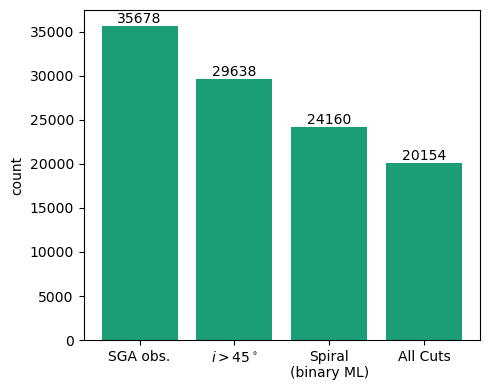

In [10]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [11]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [12]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [13]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [14]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [15]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [16]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [17]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$. Note that this still uses the Y1 dust correction!

In [18]:
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/jura_internalDust_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [20]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [21]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [22]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [23]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read('/global/homes/m/mjkeller/DESI_SGA/TF/SGA-2020_jura_Vrot_0pt_calib.fits')

In [24]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_jura_z0p1.fits', overwrite=True)
zeroptab[:5]

<Table length=5>
 SGA_ID     SGA_GALAXY            GALAXY         ...  MU_ERR    MU_SOURCE  
float64      bytes16             bytes29         ... float64     bytes22   
-------- --------------- ----------------------- ... -------- -------------
103123.0 SGA-2020 103123 SDSSJ074708.56+275429.4 ... 0.251383     SN2017ckx
108851.0 SGA-2020 108851                UGC10459 ... 0.399302 2009eu+2009fv
109750.0 SGA-2020 109750               PGC007299 ... 0.173532        2005hc
111934.0 SGA-2020 111934              PGC1881940 ...  0.21848        2010ai
111967.0 SGA-2020 111967  2MASXJ16235396+4040218 ... 0.399302 2009eu+2009fv

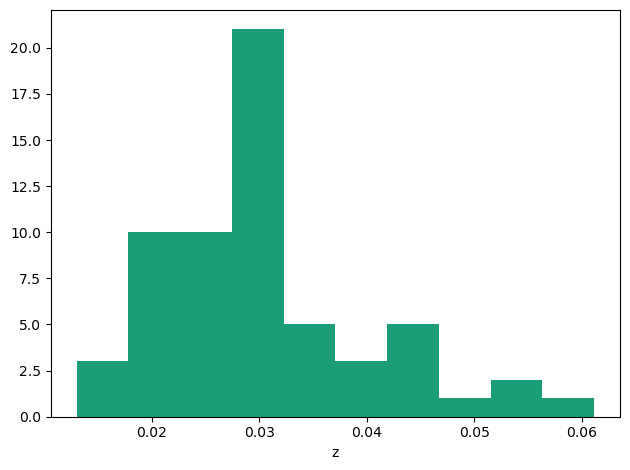

In [25]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [26]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [27]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=32>
        1999cc
        2000dg
        2001cj
        2001da
        2001ep
        2004bk
        2005hc
        2006az
        2006bt
        2006bw
        2006cq
        2007ba
           ...
 2013gy+2009kk
        2014ai
   ASASSN-15nr
   ASASSN-16ct
     AT2016bln
     AT2017cfc
       PS15aii
       PS16axi
       PS16ayd
       PS16bnz
        PS16fa
     SN2017ckx,
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  2,  1,  1, 19,  1,
         4,  3,  1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

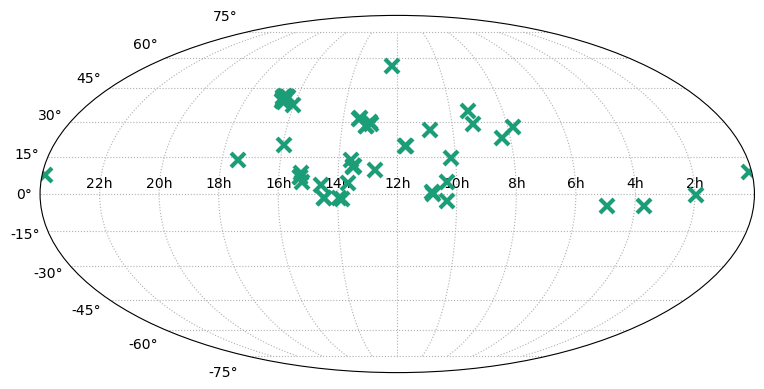

In [28]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_SNIa_calibrators.png', dpi=150);

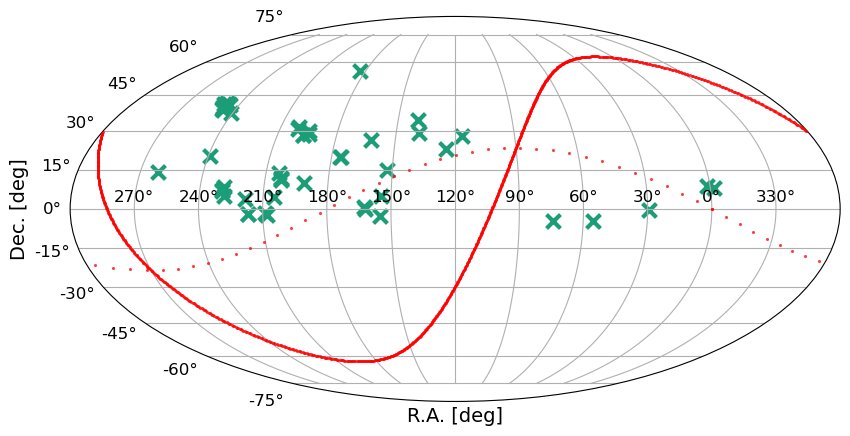

In [29]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y3/jura_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [30]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [31]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [32]:
clusters = Table.read('../Tully15-Table3.fits')
clusters[:5]

<Table length=5>
f_Nest  Nest   Nmb    PGC1   SGLON   ...  sigV    R2t    sigP     Mlum      CF  
                              deg    ... km / s   Mpc   km / s    Msun          
int16  int32  int16  int32  float64  ... int16  float64 int16   float64  float64
------ ------ ----- ------- -------- ... ------ ------- ------ --------- -------
     1 100001   136   44715  89.6226 ...    886   2.129   1045 1.710e+15    1.65
     1 100002   197   41220 103.0008 ...    670   1.440    707 5.290e+14    1.00
     1 100003   113   43296 156.2336 ...    822   1.520    746 6.230e+14    1.12
     1 100004    81   58265  71.5103 ...    740   2.153   1057 1.770e+15    2.26
     1 100005    61   36487  92.0255 ...    707   1.560    766 6.730e+14    1.58

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [33]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]
print(len(sgatab_sel))

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
z_sga_desi = sgatab_sel['Z_DESI']

20154


In [34]:
sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 20

# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    nest_id = clusters['Nest'][i]
    
    #- Sky coordinates of cluster
    cls_coord = SkyCoord(clusters['SGLON'][i], 
                         clusters['SGLAT'][i], 
                         unit='deg', 
                         frame='supergalactic')

    #- Cluster turnaround radius, velocity dispersion, and distance modulus
    R2t = clusters['R2t'][i]
    sigP = clusters['sigP'][i]
    mu = clusters['DM'][i]

    #- Convert distance moduli to velocities [in km/s]
    dist = 10 * 10**(0.2*mu)
    velo = 100 * (dist*1e-6) # Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0 

    #- Apply cuts on angular separation
    sep = cls_coord.separation(sga_coords)
    R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian

    #- Apply cluster cuts.
    in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster = in_cluster_1 | in_cluster_2

    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
        sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
        m_dwarf_clusters[nest_id] = -17 + mu

100%|██████████| 25474/25474 [06:22<00:00, 66.66it/s]


In [35]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100001  20 galaxies
 2  100002  34 galaxies
 3  100004  60 galaxies
 4  100007 107 galaxies
 5  100016  24 galaxies
 6  100041  24 galaxies
 7  100046  21 galaxies
 8  100067  30 galaxies
 9  100077  53 galaxies
10  100125  21 galaxies
11  100132  20 galaxies
12  100221  20 galaxies
13  100282  67 galaxies
14  100526  33 galaxies
15  100527  25 galaxies
16  100952  26 galaxies
17  100991  20 galaxies
18  101400  26 galaxies
19  101591  22 galaxies
20  101788  24 galaxies
21  101823  41 galaxies
22  103172  21 galaxies
23  103175  37 galaxies
24  103182  29 galaxies
25  103203  20 galaxies
26  103206  20 galaxies
27  103229  23 galaxies
28  103584  25 galaxies
29  200043  29 galaxies
30  200284  30 galaxies
31  200382  29 galaxies
32  200386  44 galaxies
33  200573  22 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

[ True  True False ... False False False]


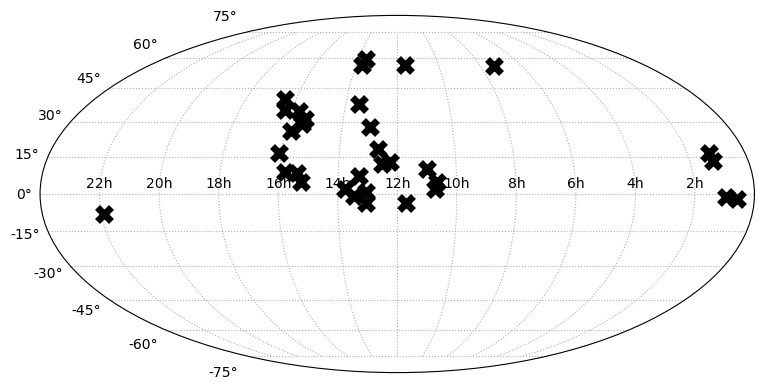

In [36]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], nest_ids)
print(idx)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150);

In [37]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [38]:
def plot_cluster_members(clusters, cluster_id, sgacat, sga_ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    colors = plt.get_cmap('Dark2').colors
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgacat['SGA_ID'], sga_ids)
    z_sga = sgacat['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    ax.plot(sga_coords.ra.deg, sga_coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, sga_coords_median.dec.deg, 'D', color = colors[1], transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor=colors[7], linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor=colors[7], linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_sga, sga_coords.dec.deg, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median, sga_coords_median.dec.deg, 'D', color = colors[1], ms=5, mew=5)
    ax.plot(cluster_v/c_kms, cluster_coord.dec.deg, 'kx', ms=10, mew=5)

    decmin = np.min(sga_coords.dec.deg) - 0.5
    decmax = np.max(sga_coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors=colors[7],
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords.ra.deg, z_sga, 'o', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median.ra.deg, z_sga_median, 'D', color = colors[1], ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v/c_kms, 'kx', ms=10, mew=5)

    ramin = np.min(sga_coords.ra.deg) - 0.5
    ramax = np.max(sga_coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors=colors[7],
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(sga_coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.ra.deg, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_coord.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    ax = plt.subplot(235)
    ax.hist(sga_coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.vlines(sga_coords_median.dec.deg, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_coord.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           ylim=(0,10))

    dz = 0.0025
    zmin = np.min(np.round(z_sga, 2)) - 4*dz
    zmax = np.max(np.round(z_sga, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_sga_median, 0, 50, colors=colors[1], linestyles='dotted')
    ax.vlines(cluster_v/c_kms, 0, 50, colors='k', linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           ylim=(0,10))

    fig.suptitle(f'TF Jura Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (194.75582168, 27.93269246)>
7345.138681571143 +/- 1045 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (110.17218675, 55.6898024)>
12022.64434617413 +/- 1037 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.82189669, 10.09092567)>
11066.237839776675 +/- 744 km/s
<S

/tmp/ipykernel_1546065/805910609.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


<SkyCoord (ICRS): (ra, dec) in deg
    (230.99936671, 31.21107645)>
23550.492838960086 +/- 1707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (206.10730715, 2.1097726)>
23120.647901755987 +/- 1693 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (236.07424061, 34.69623742)>
22803.420720004207 +/- 1458 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (201.84149945, -1.00863004)>
23768.402866248827 +/- 1465 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (202.33739481, 37.62288797)>
17782.794100389227 +/- 783 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (14.13239492, -1.08658284)>
13243.415351946644 +/- 1077 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (17.93151711, 13.53834251)>
16904.409316432666 +/- 1285 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (328.77363049, -8.05653143)>
20044.72027365159 +/- 2055 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (18.44359042, 16.98990087)>
19860.949173573757 +/- 2303 km

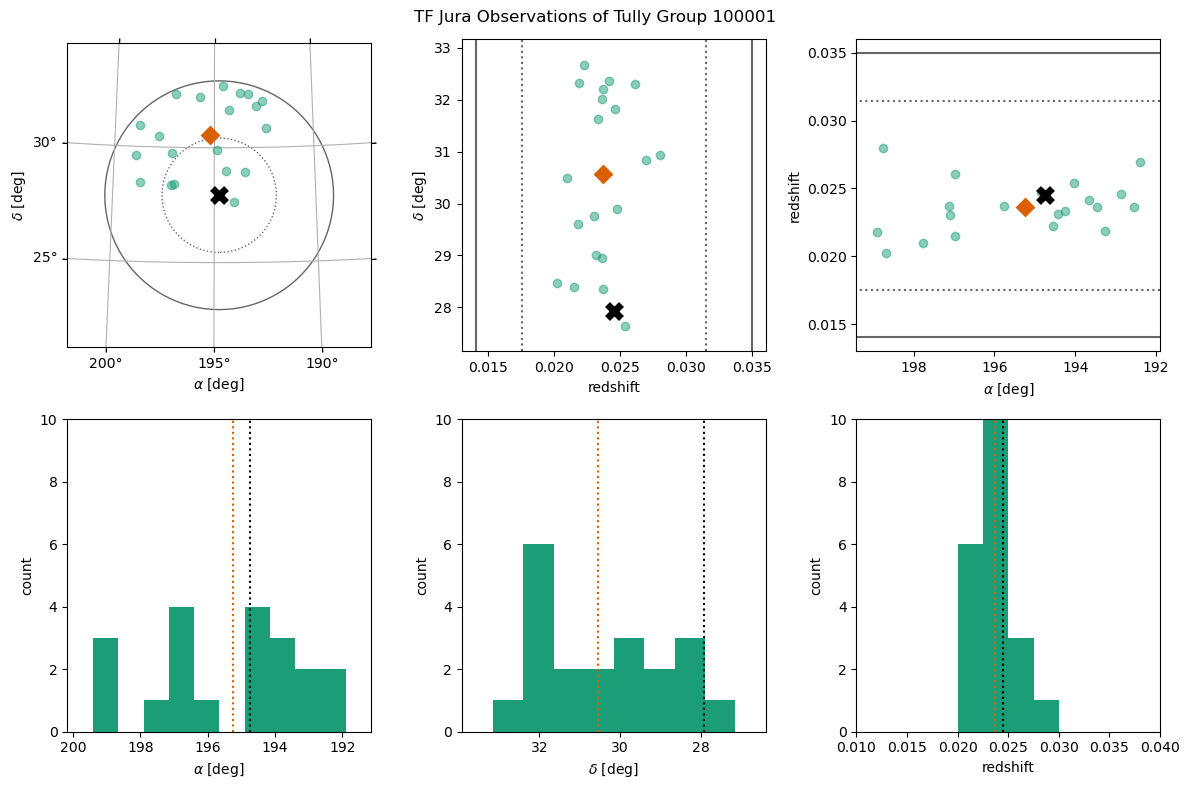

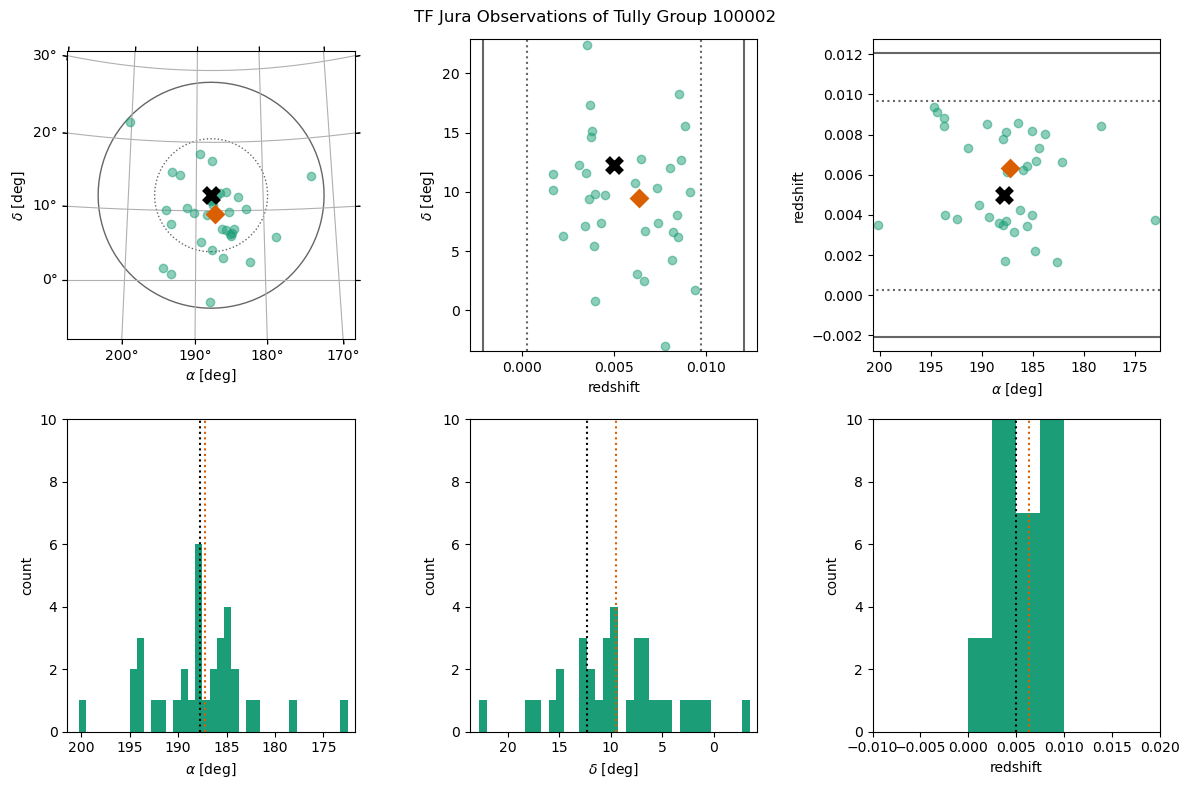

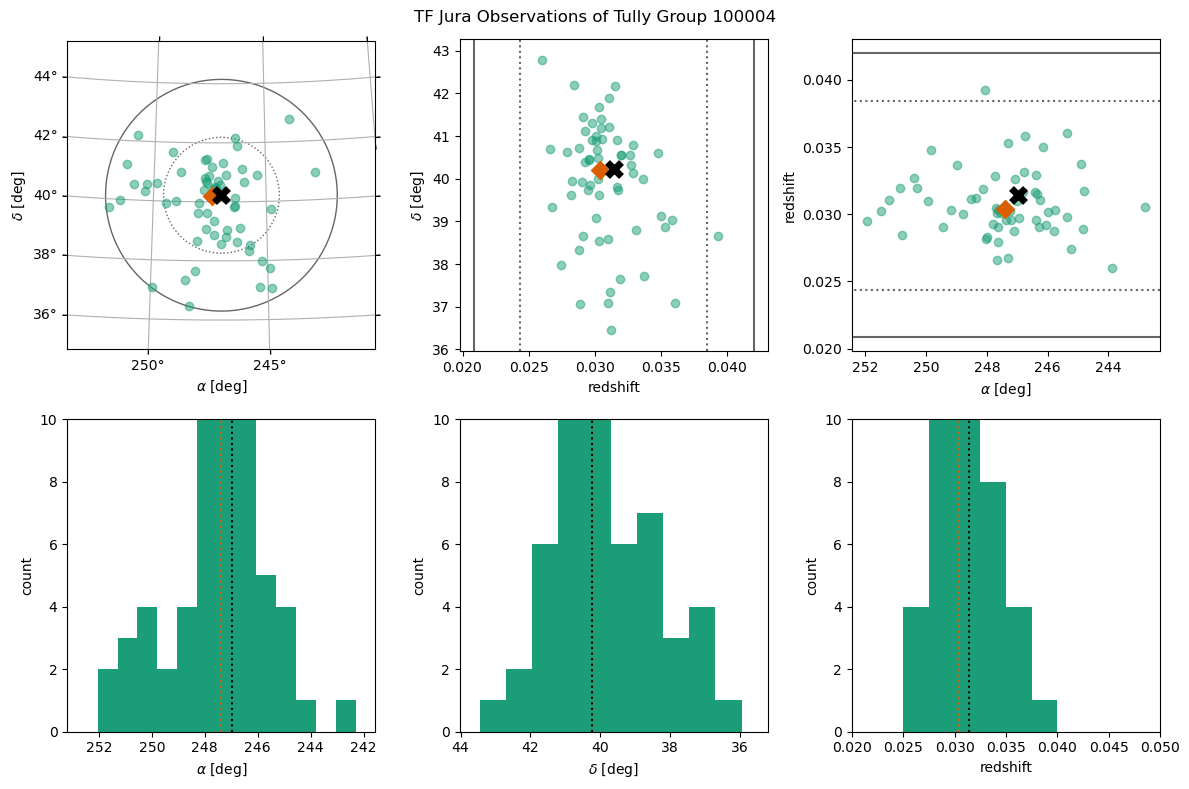

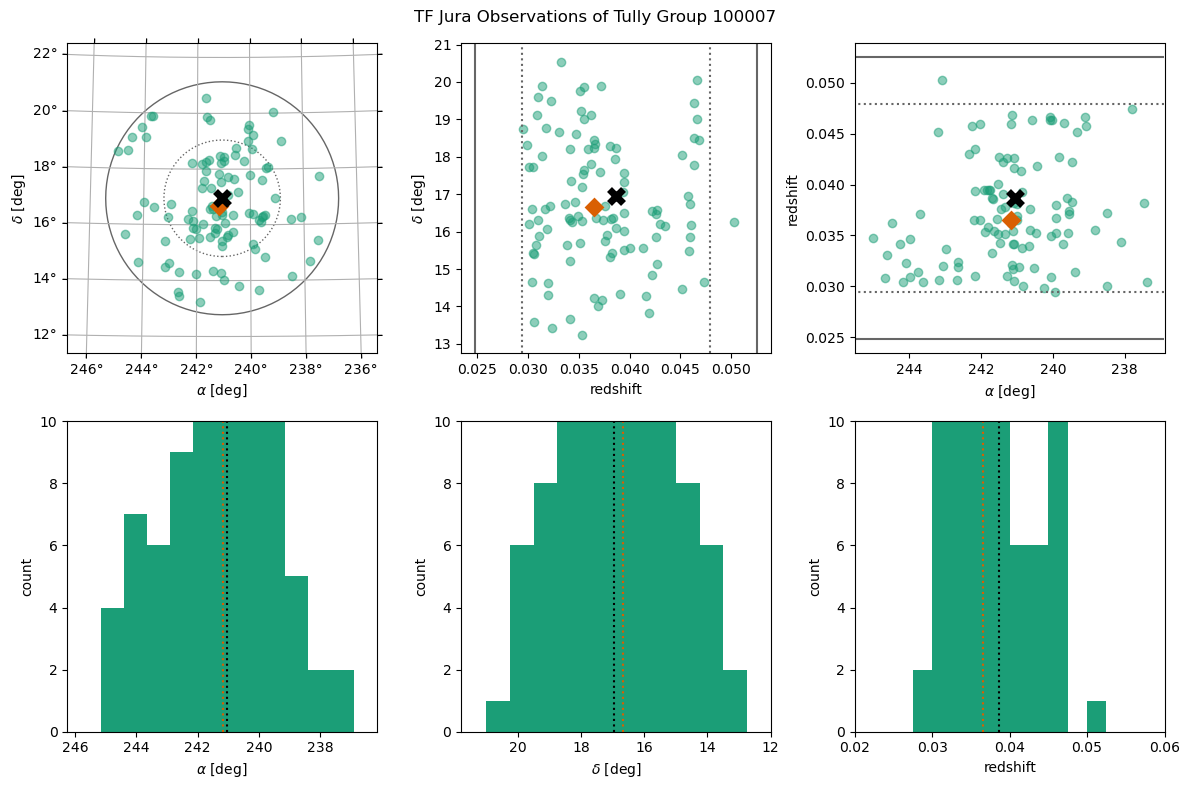

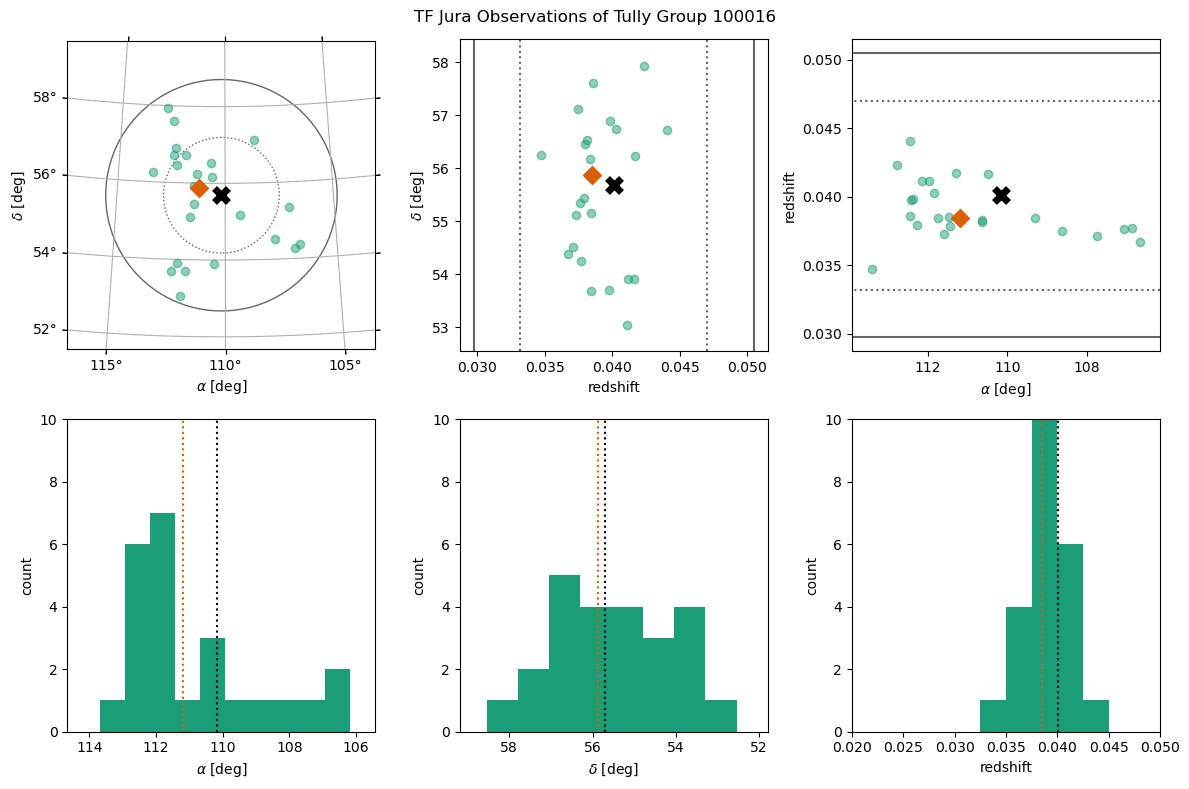

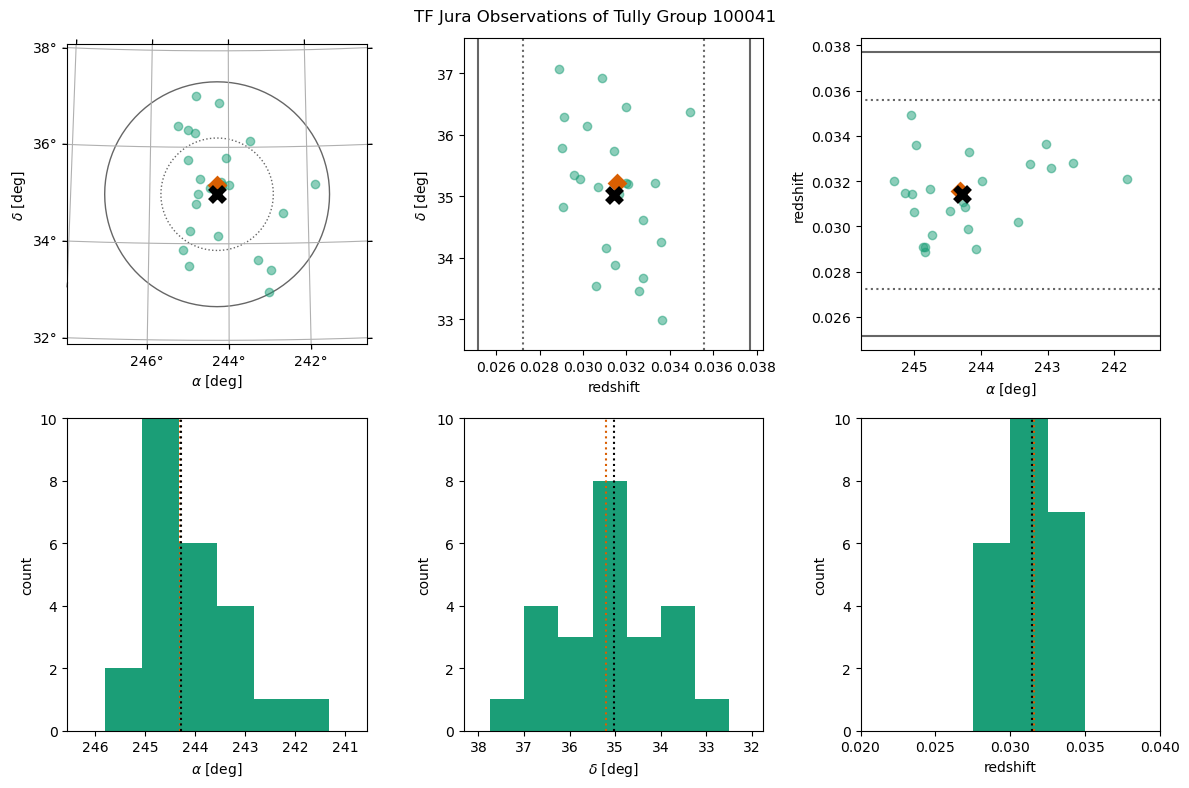

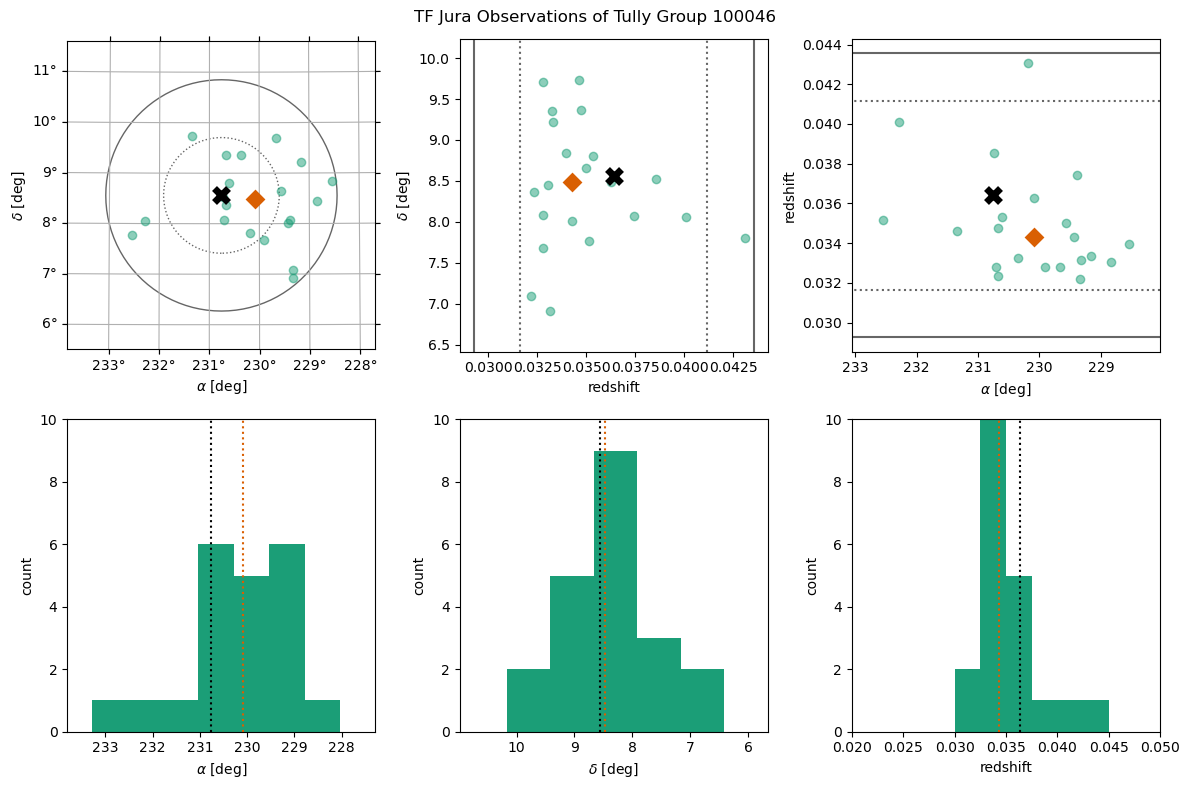

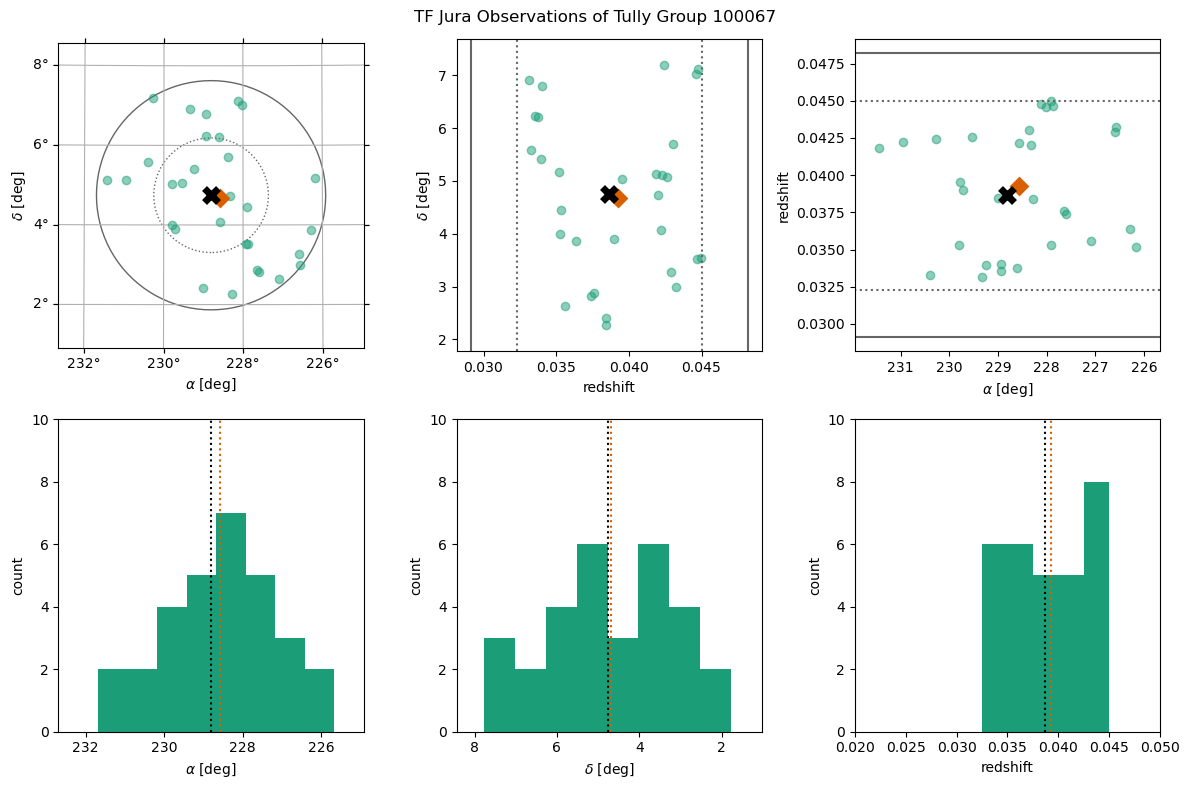

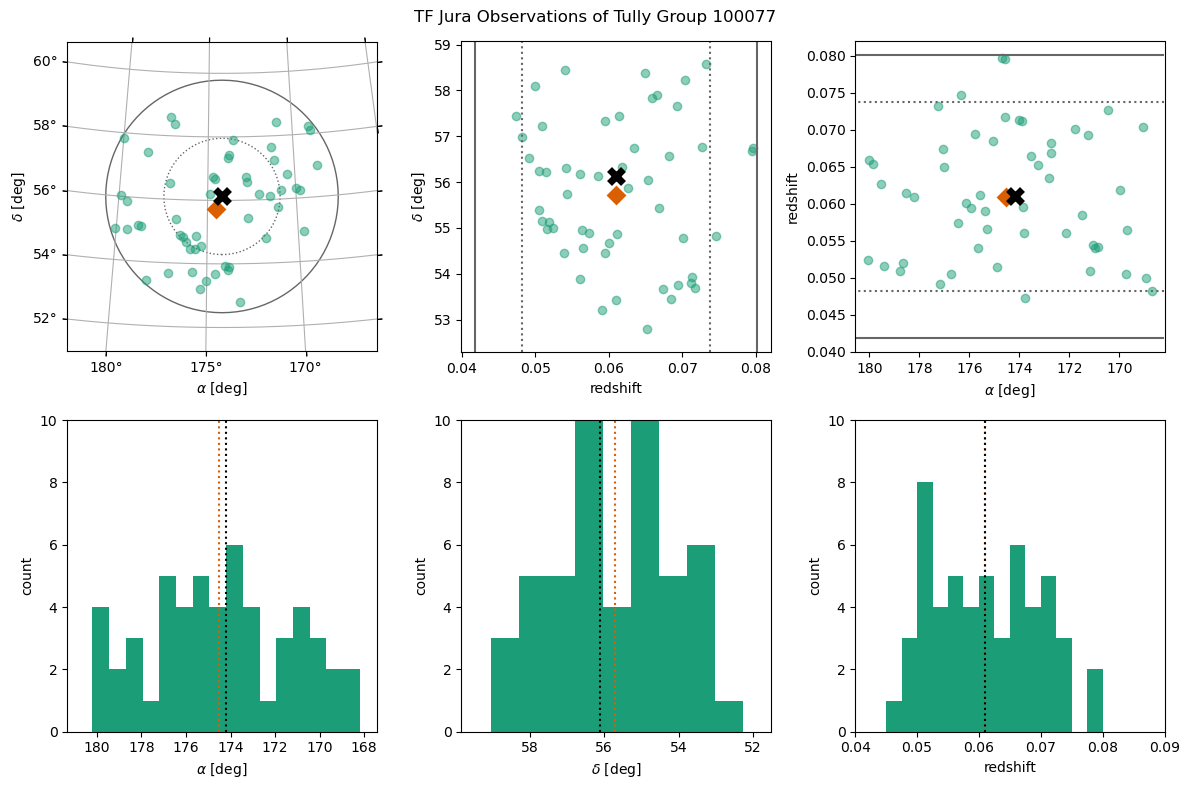

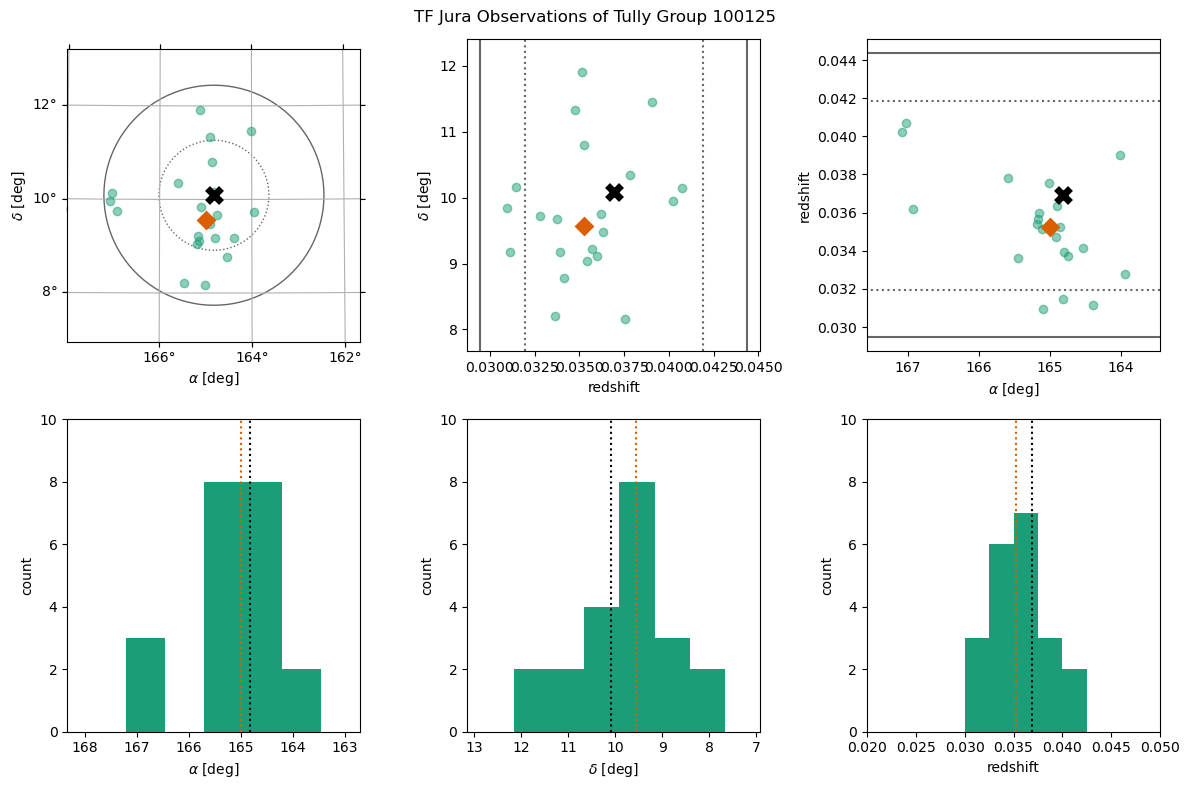

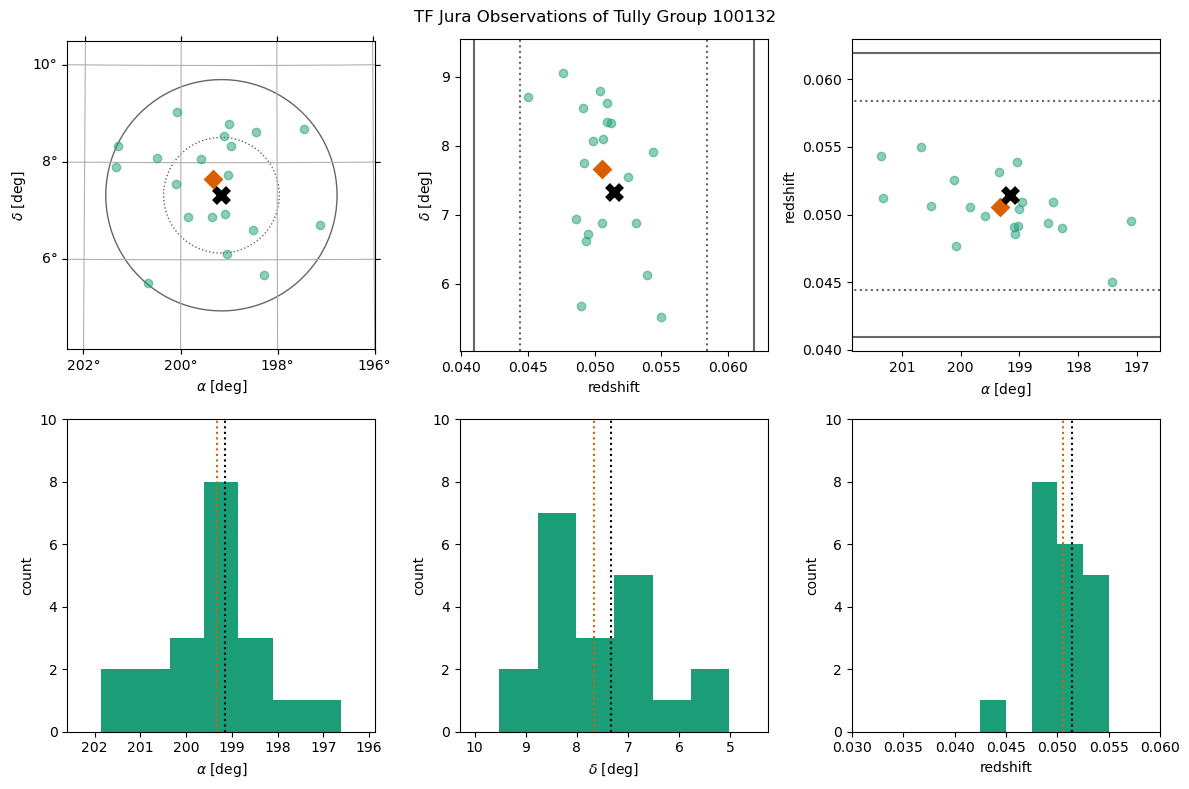

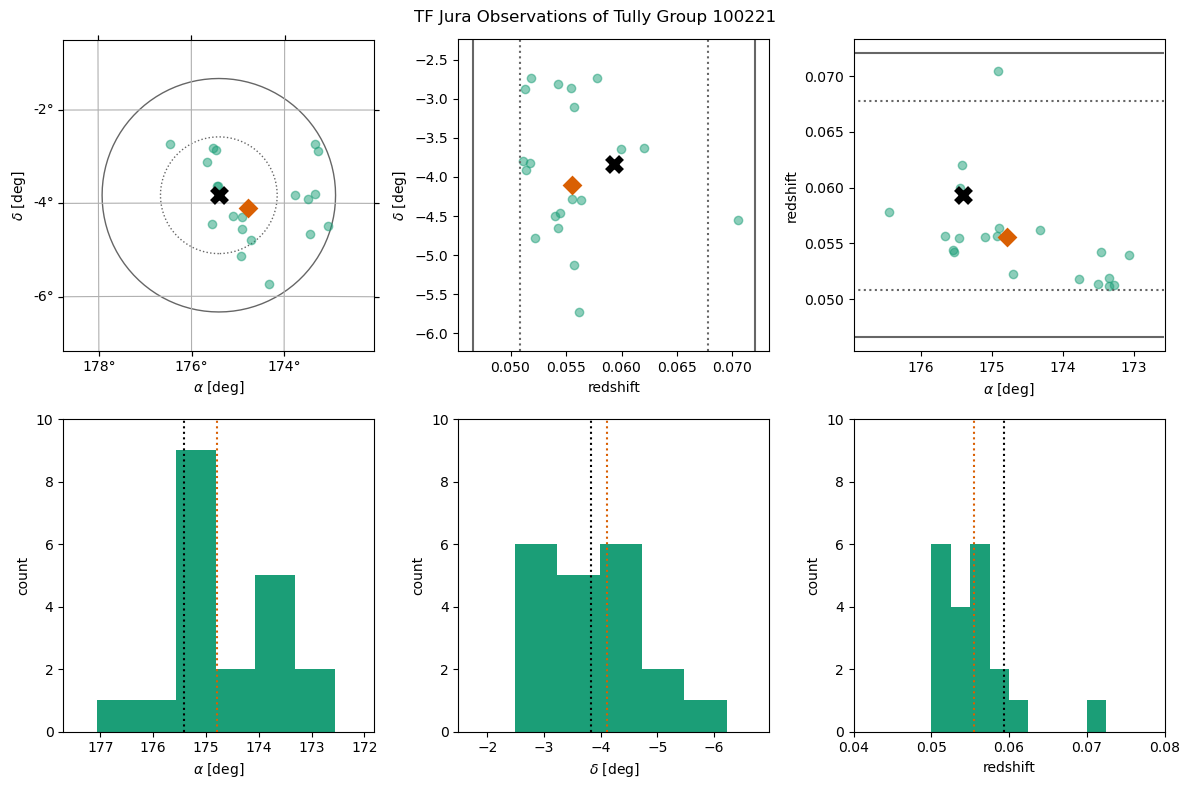

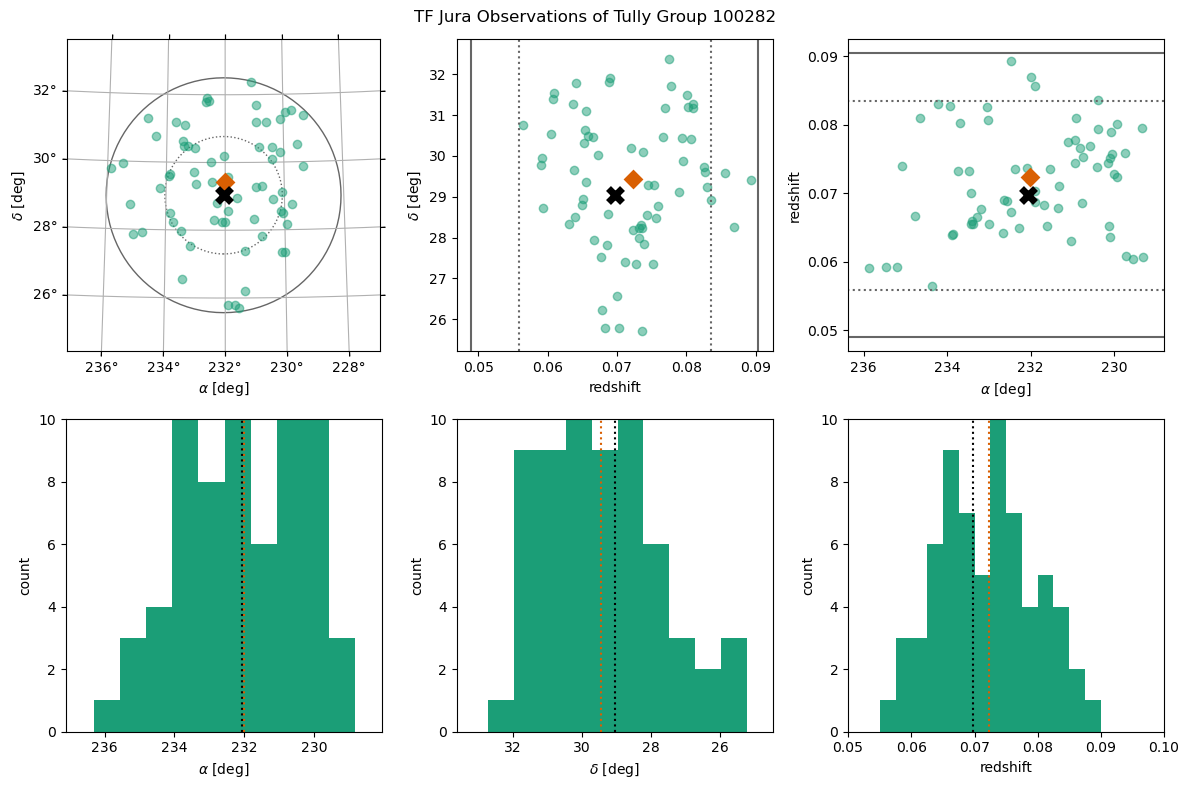

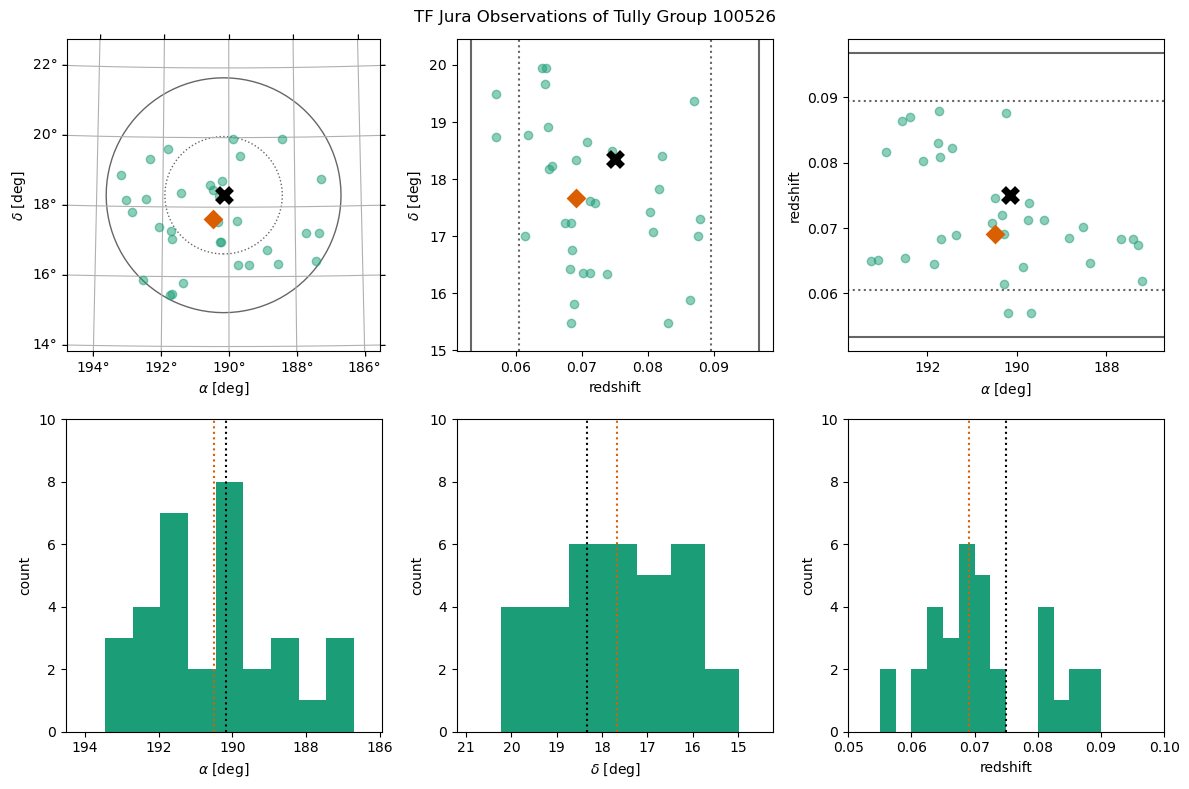

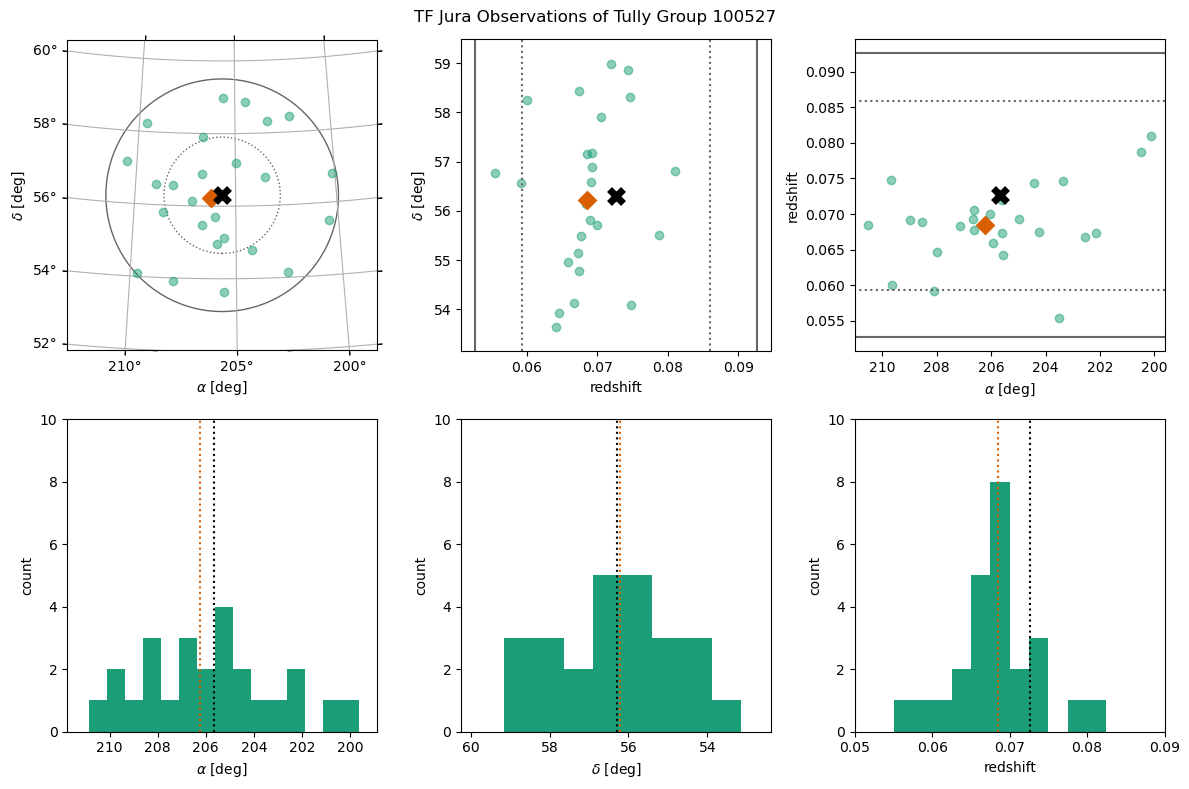

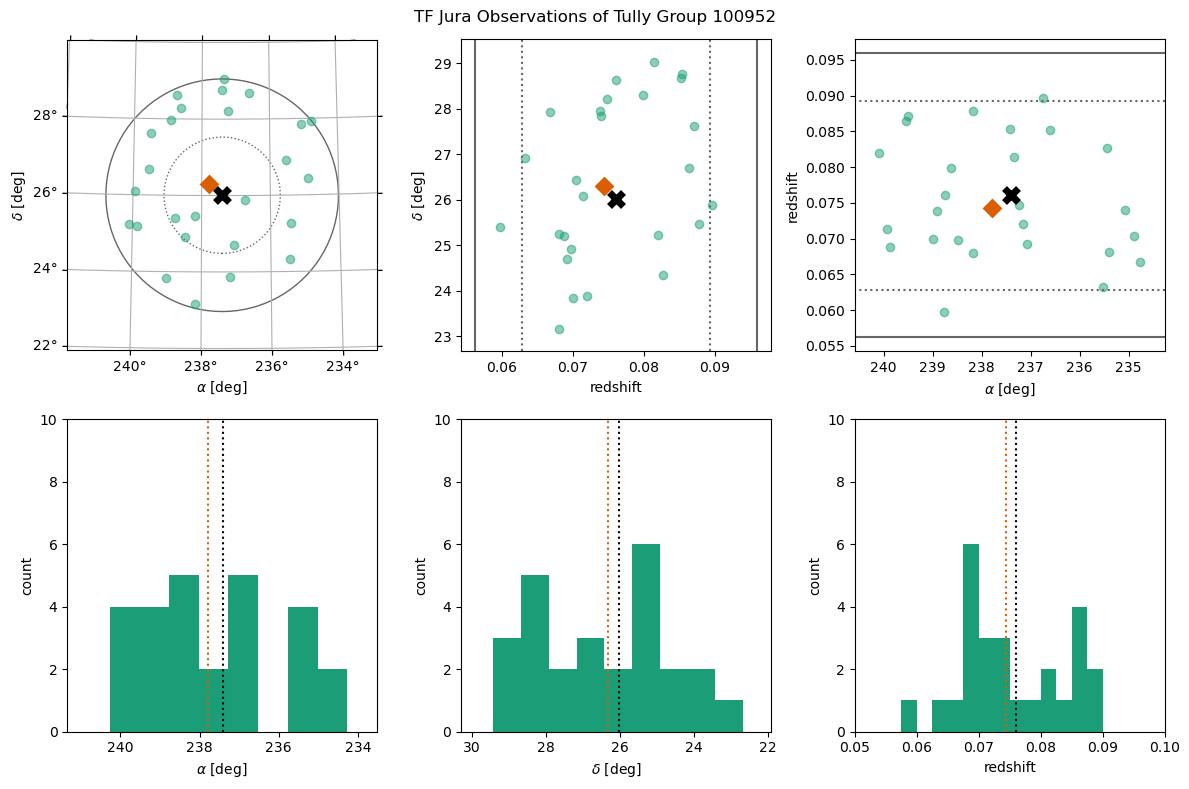

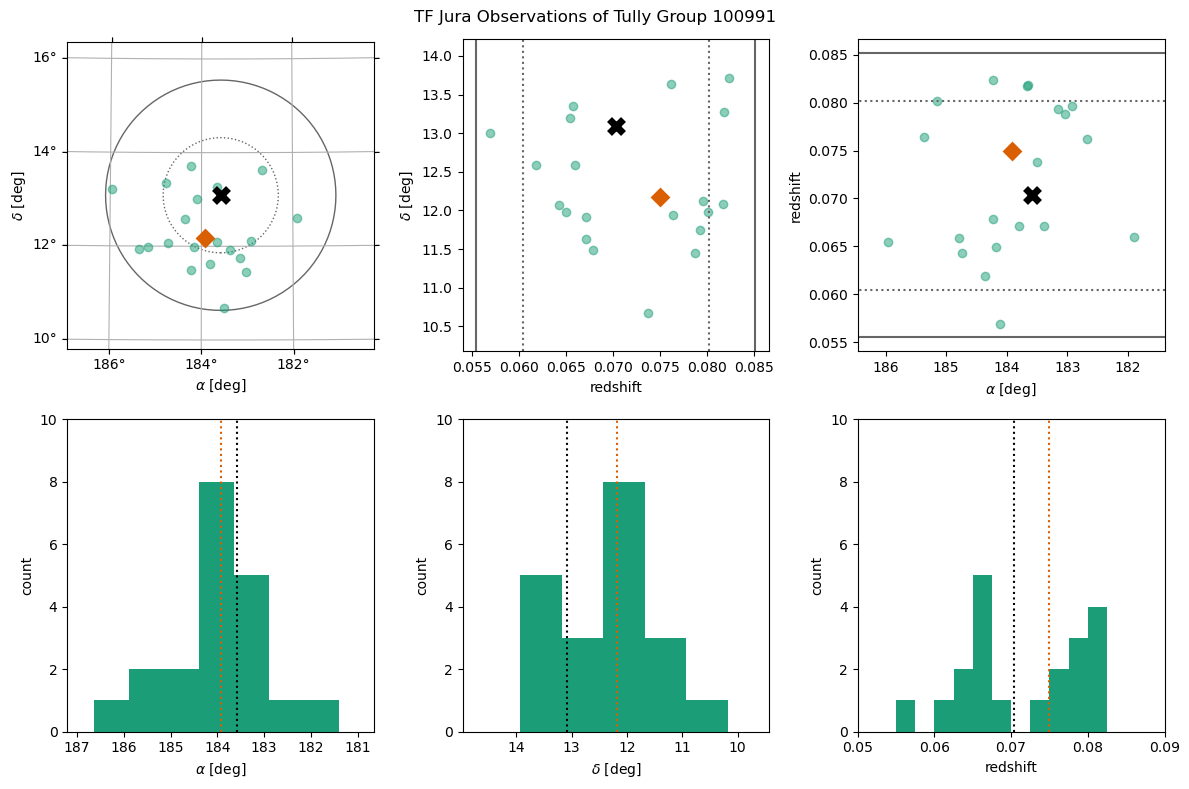

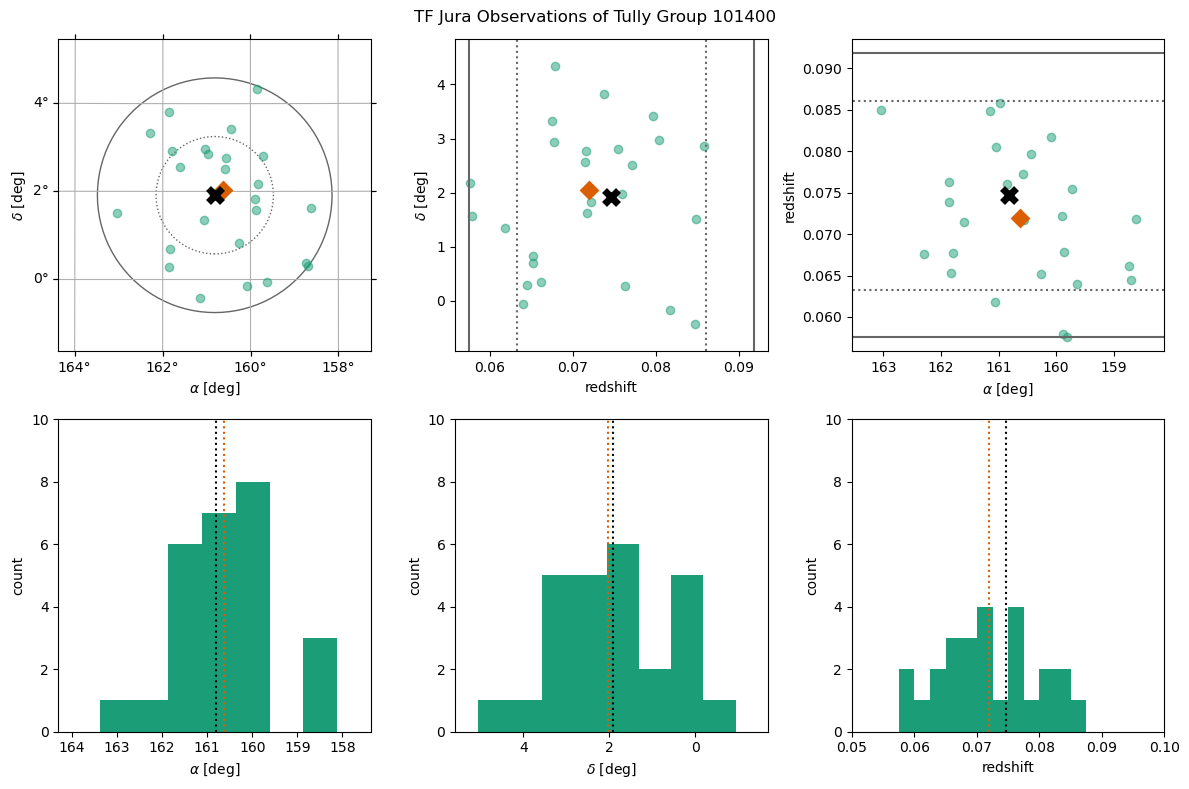

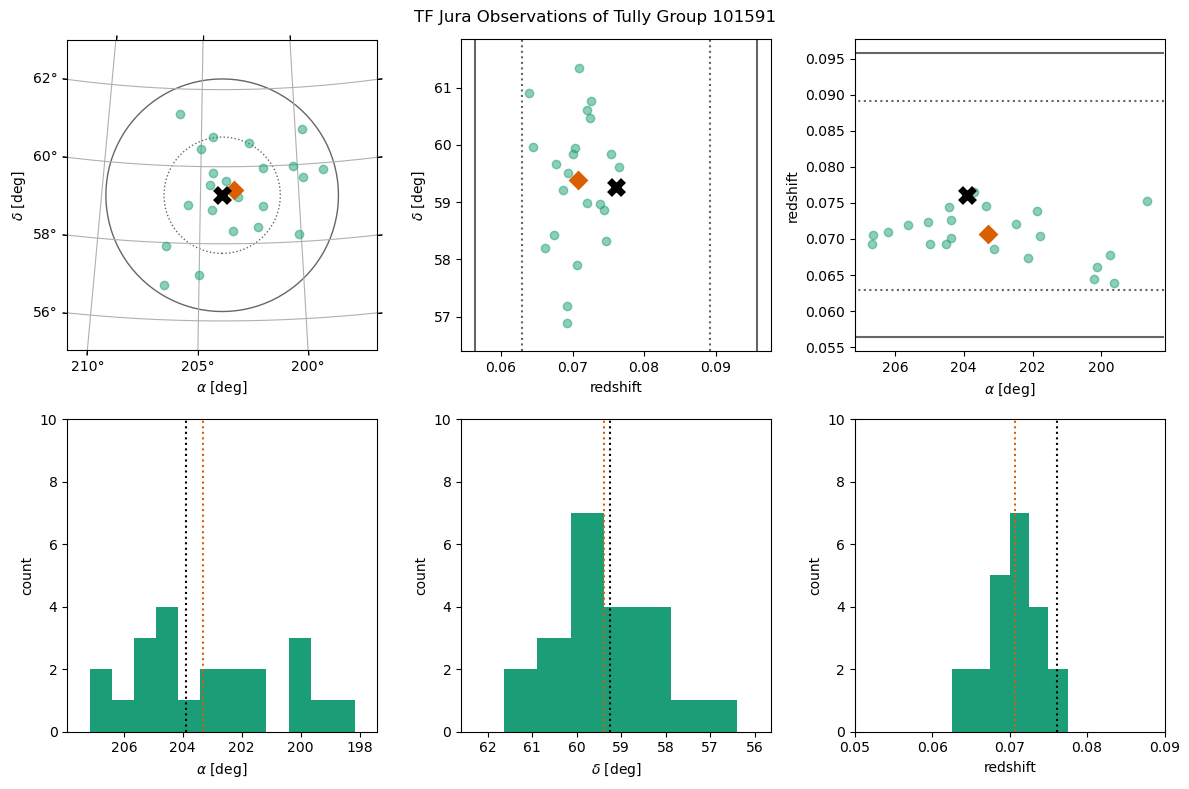

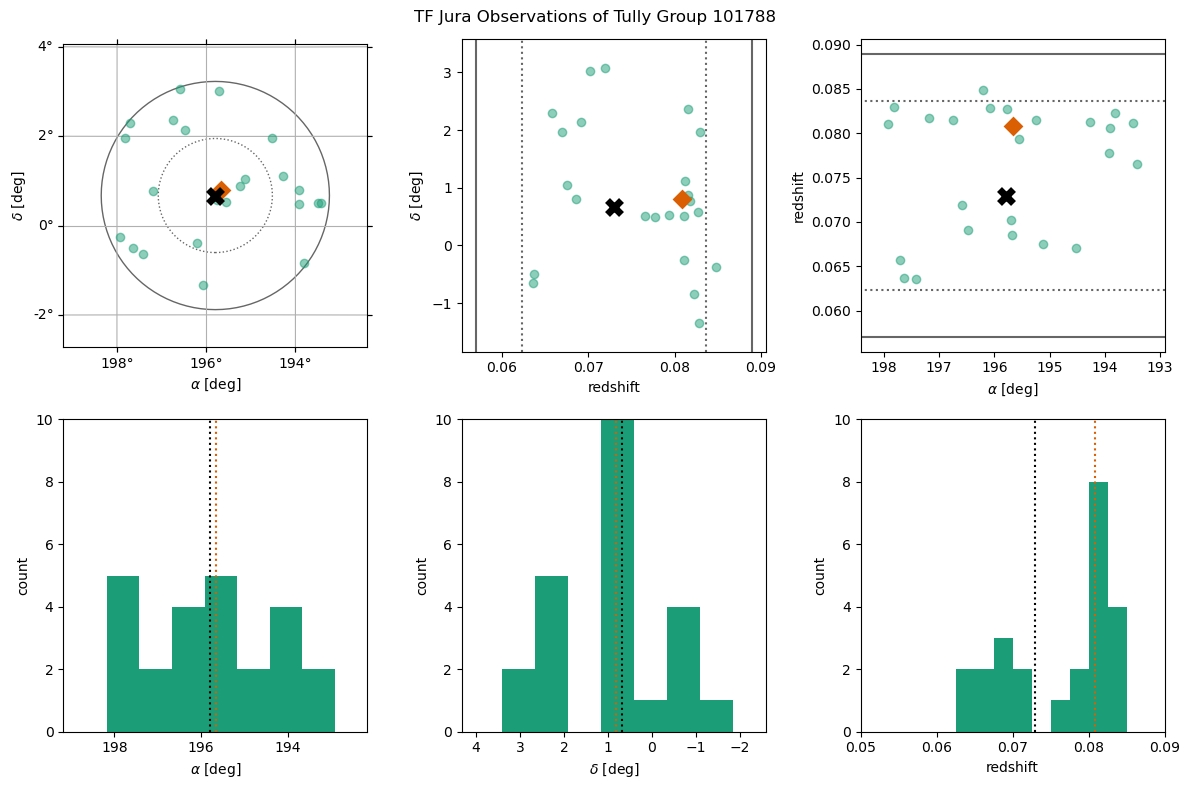

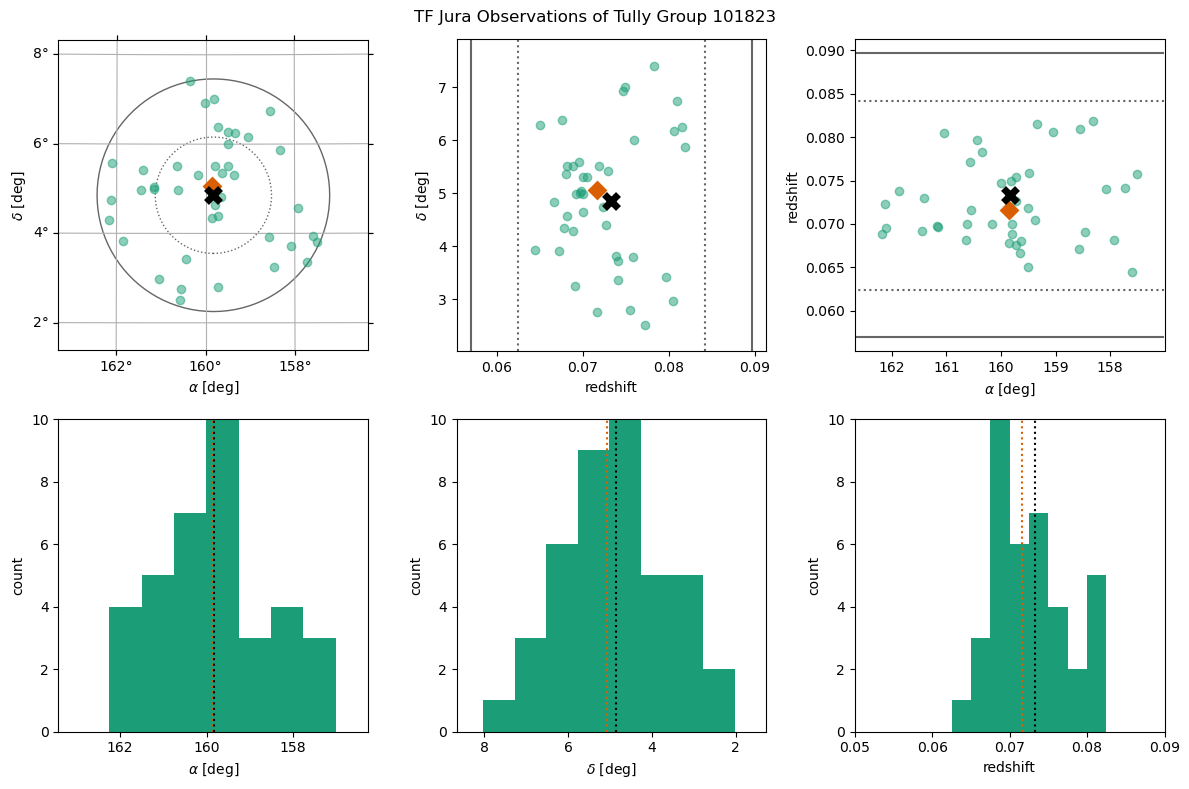

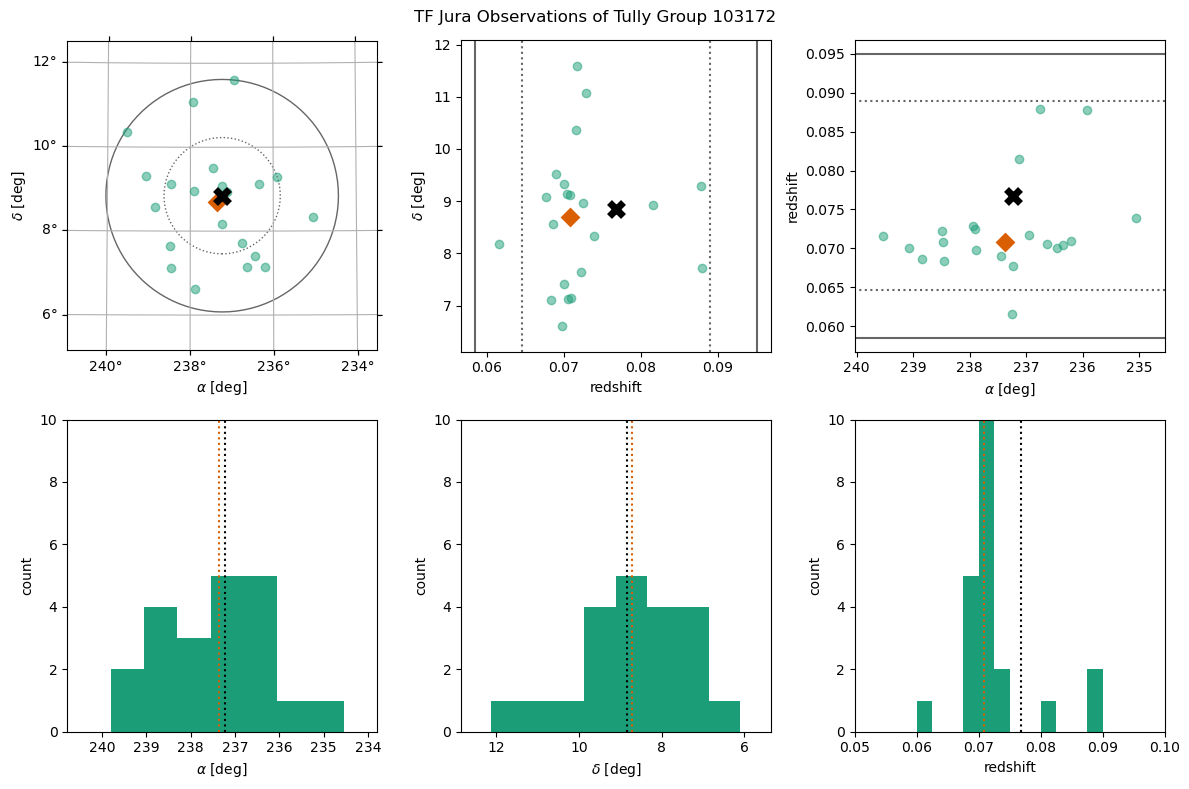

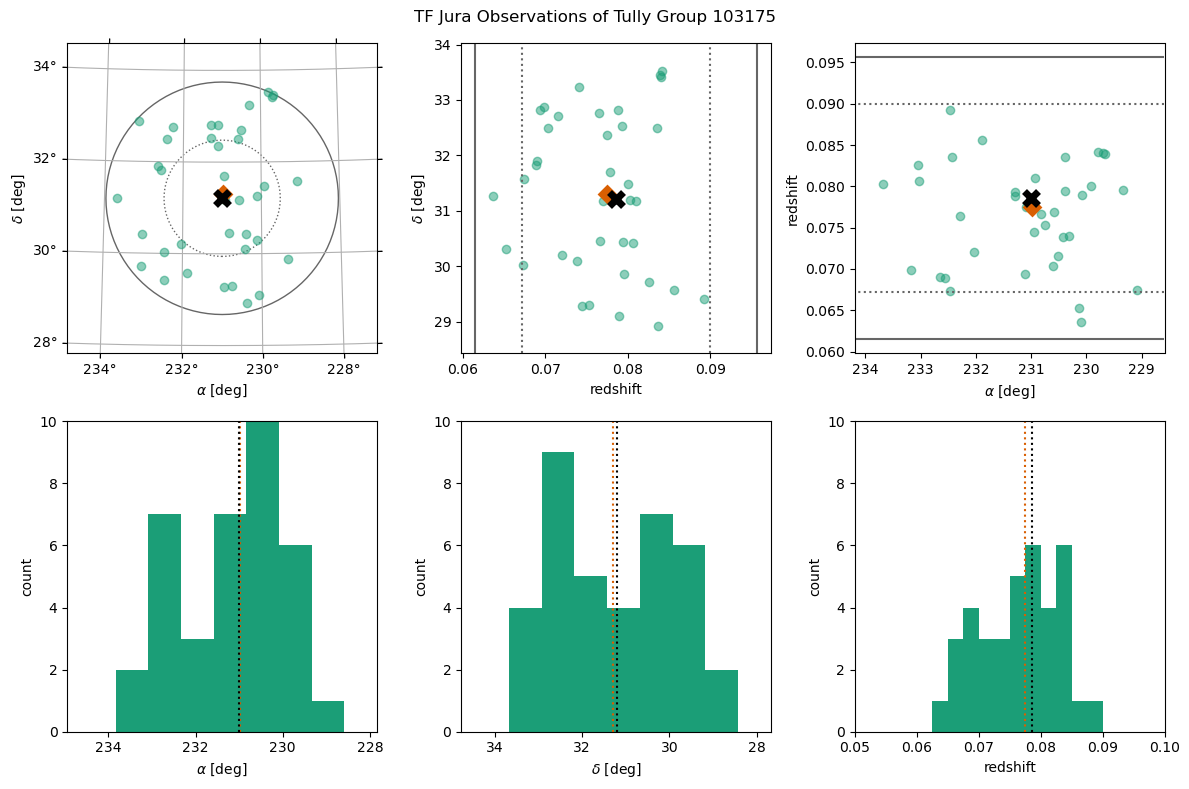

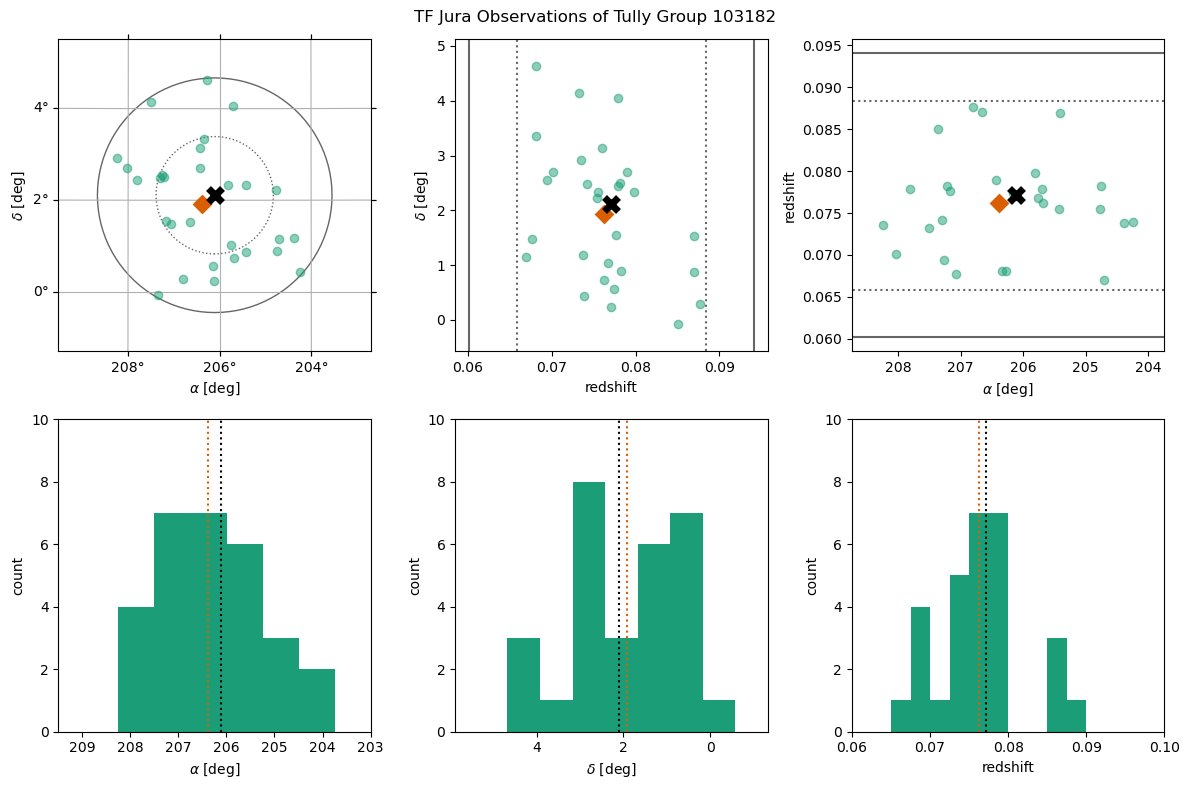

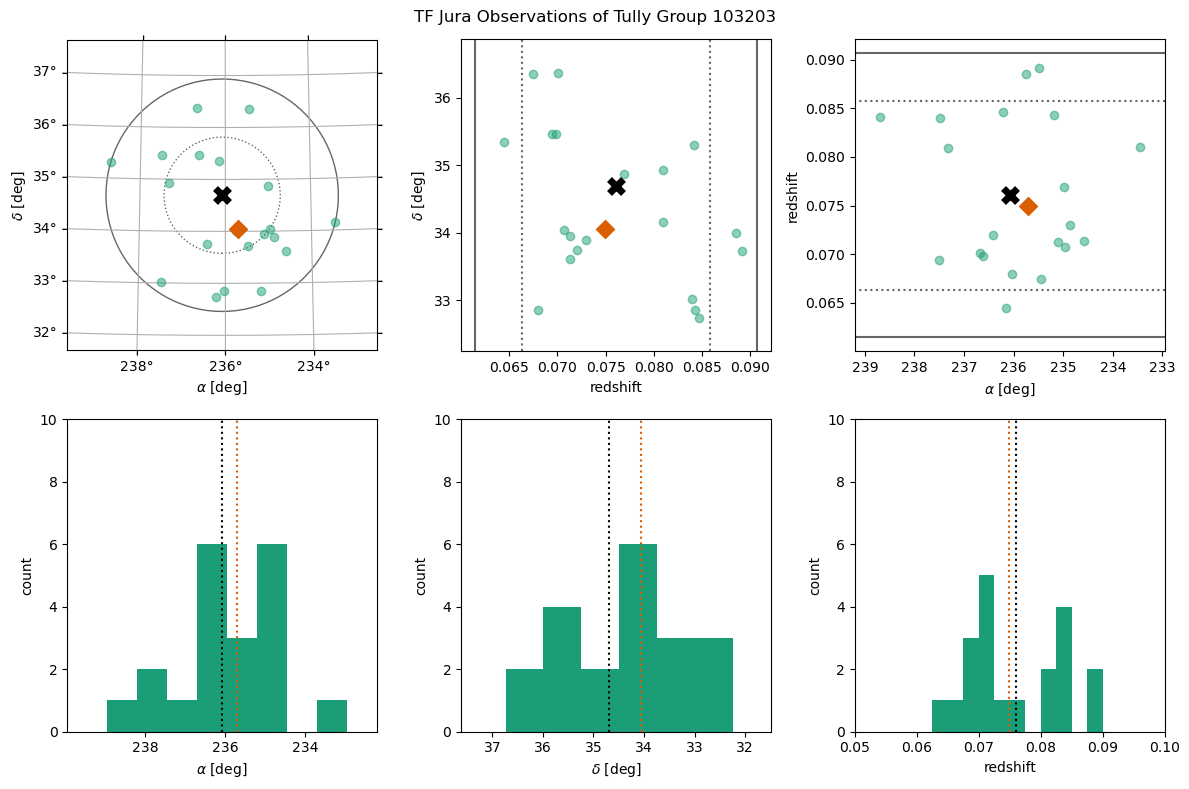

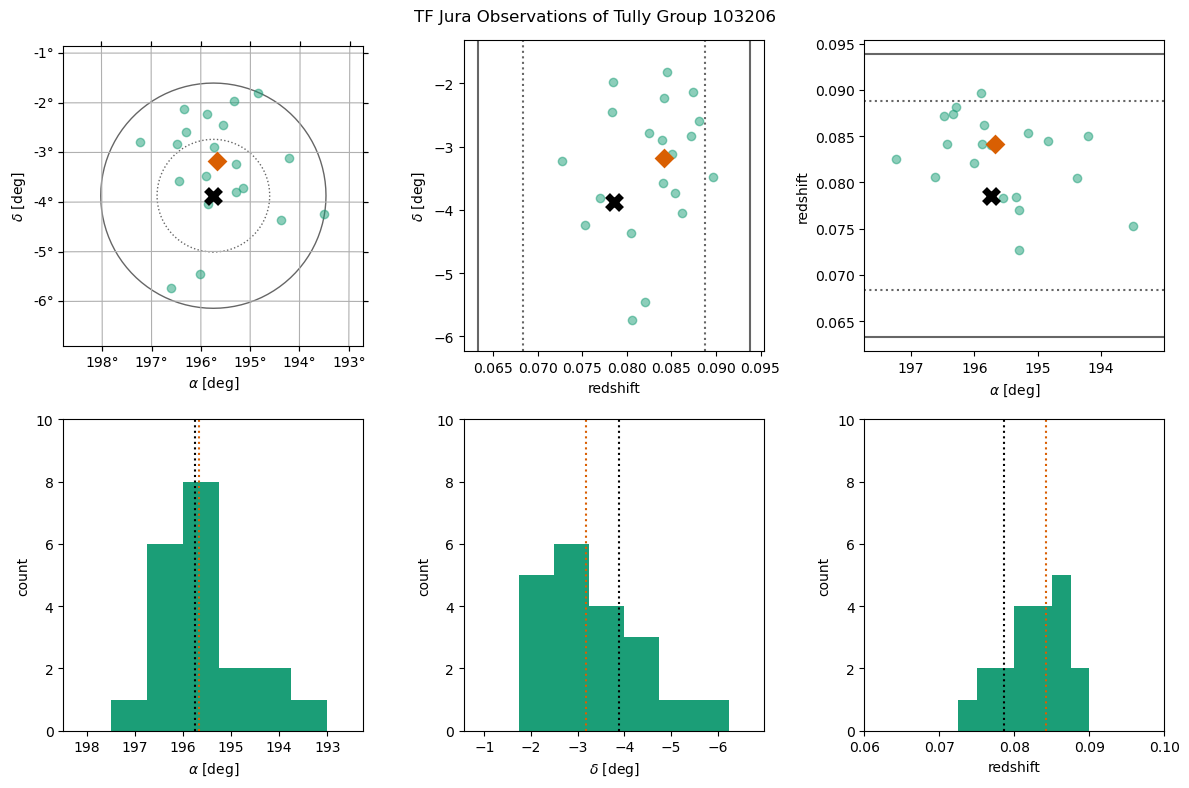

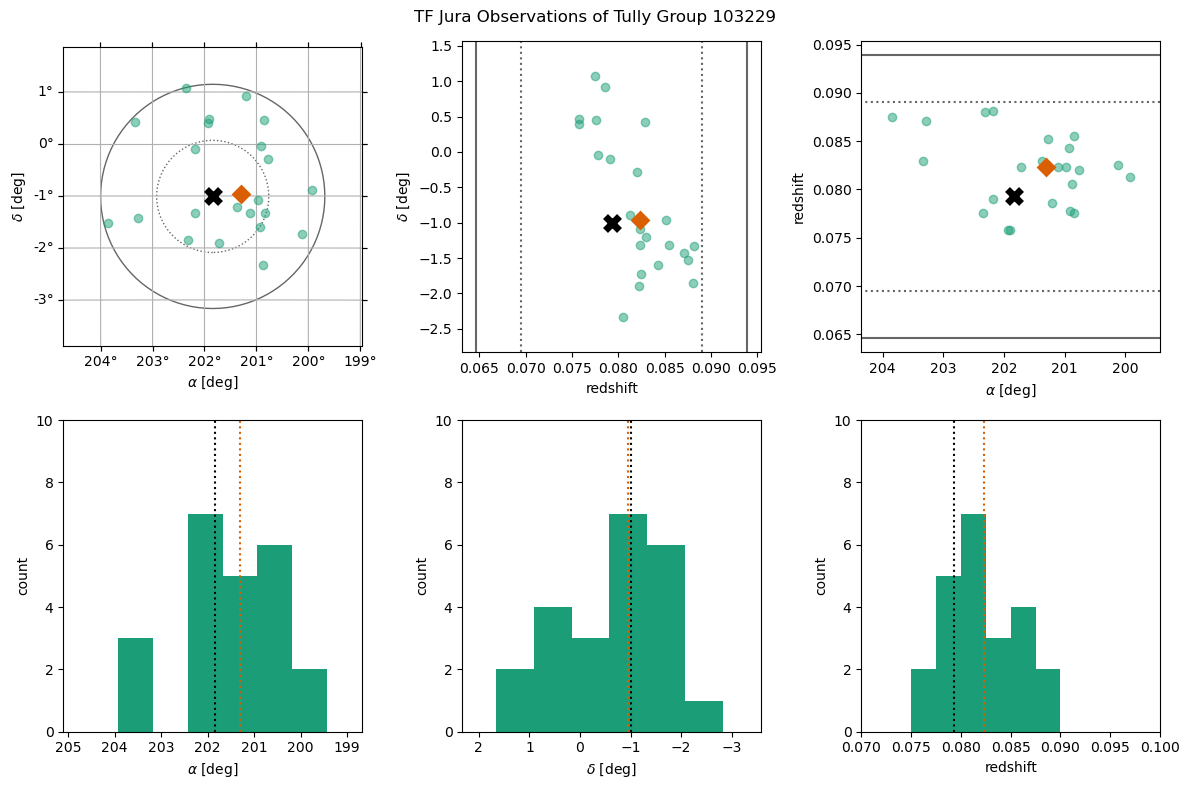

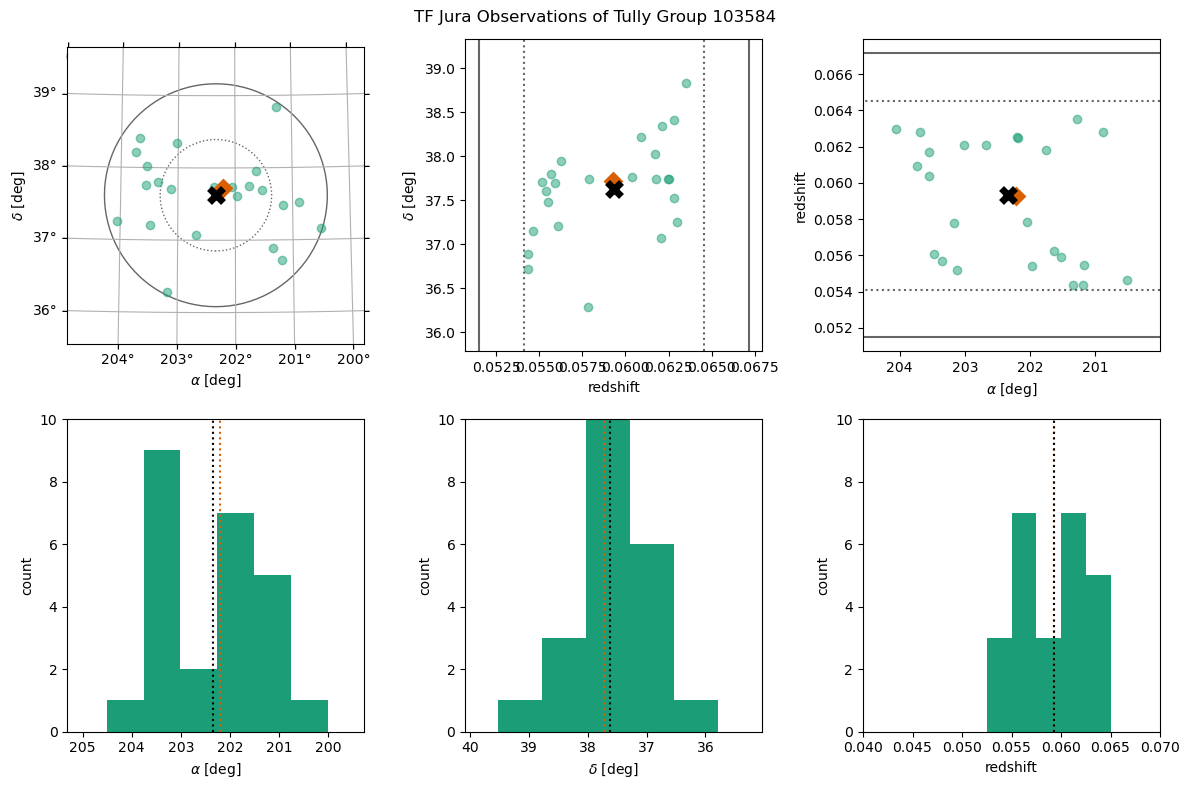

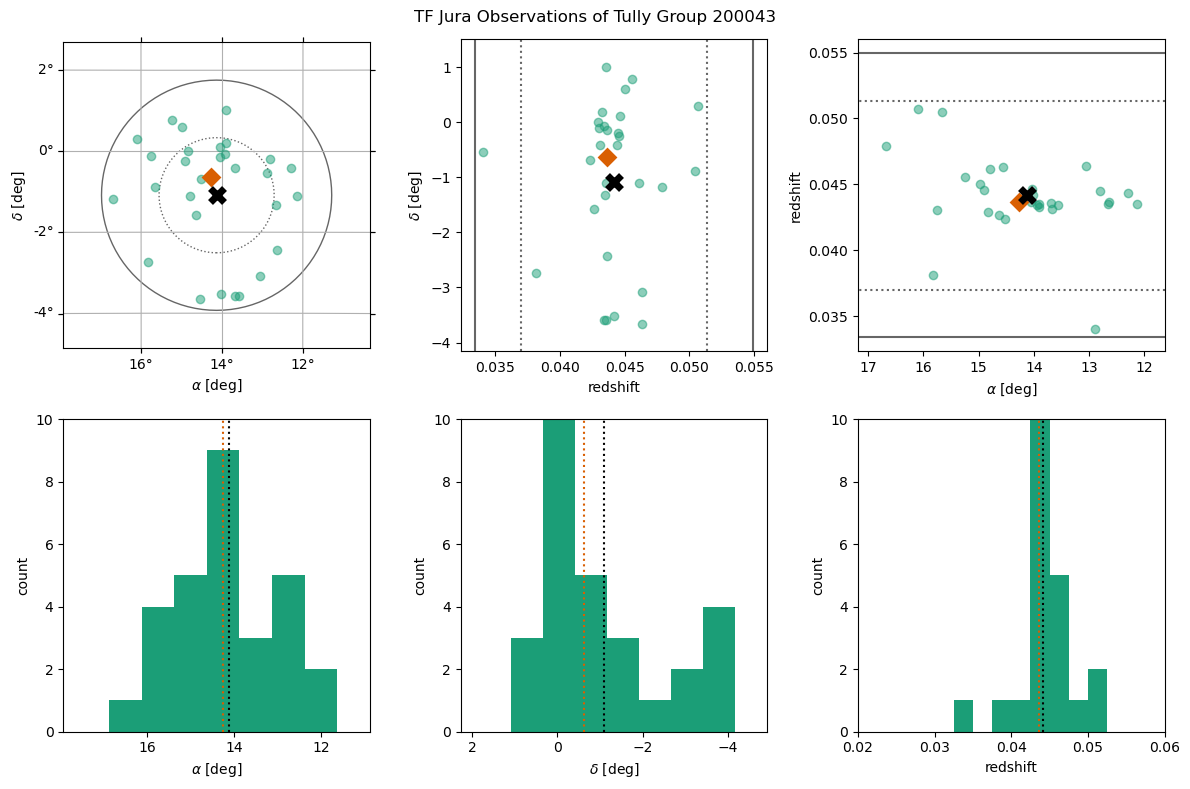

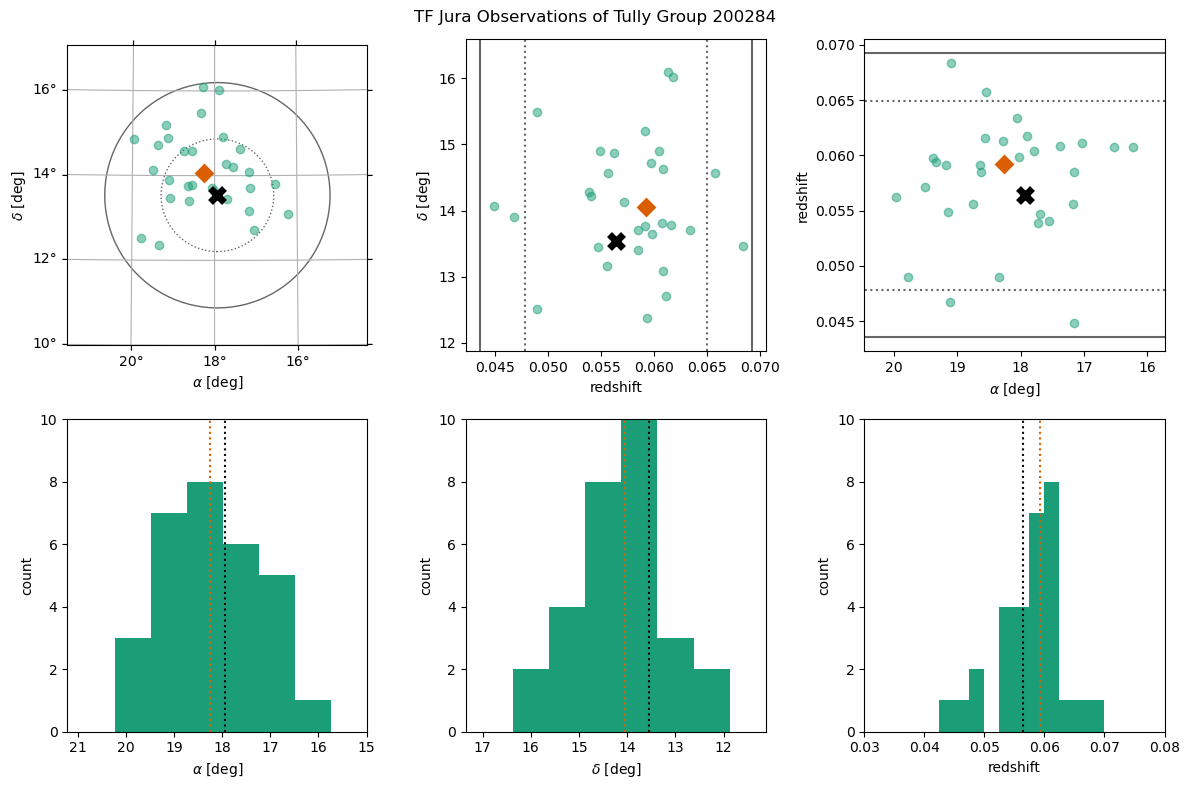

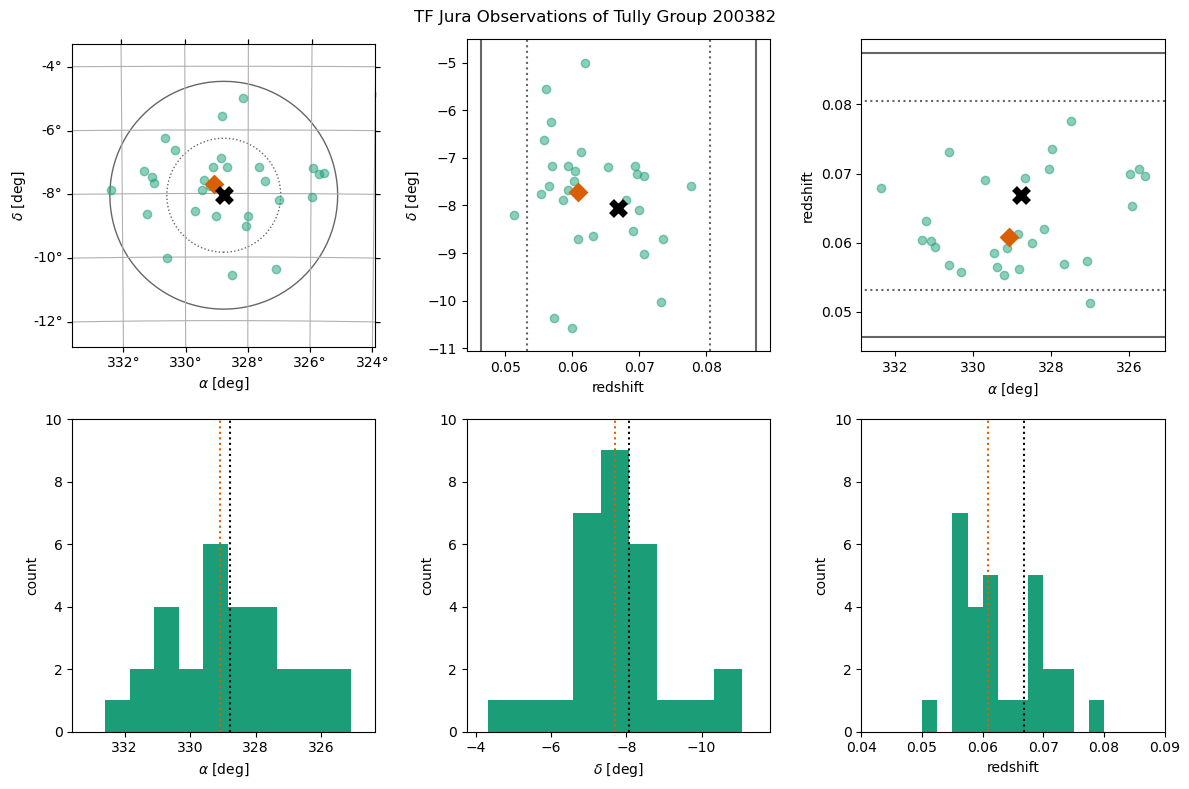

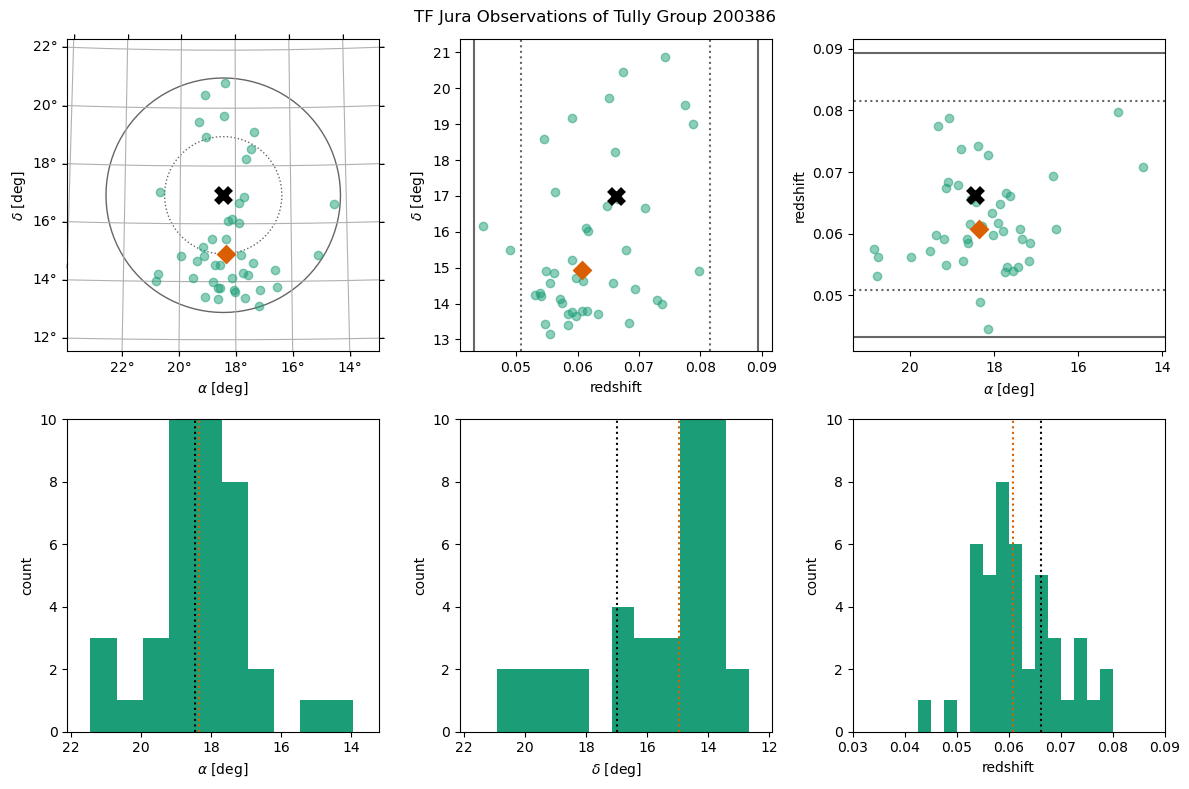

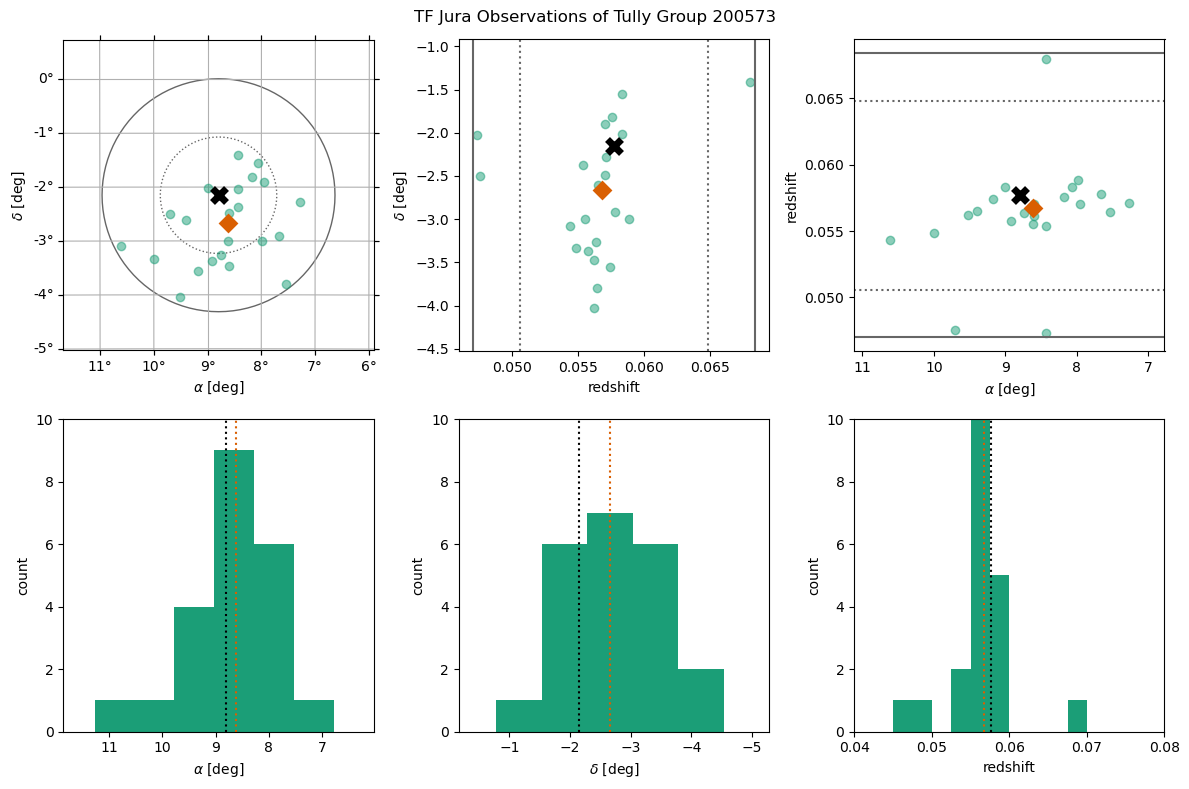

In [39]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100001       253.938 km/s    1045.000 km/s       0.243       2.663 deg       1.660 deg       1.069
100002       408.128 km/s     707.000 km/s       0.577       2.831 deg       5.510 deg       0.343
100004       302.197 km/s    1057.000 km/s       0.286       0.313 deg       1.309 deg       0.159
100007       647.295 km/s    1385.000 km/s       0.467       0.311 deg       1.395 deg       0.149
100016       492.564 km/s    1037.000 km/s       0.475       0.606 deg       1.006 deg       0.402
100041        45.724 km/s     627.000 km/s       0.073       0.182 deg       0.777 deg       0.156
100046       633.781 km/s     714.000 km/s       0.888       0.670 deg       0.764 deg       0.585
100067       182.845 km/s     954.000 km/s       0.192       0.244 deg       0.961 deg       0.169
100077         5.555 km/s    1914.000 km/s       0.003       0.451 deg       1.222 deg       0.246
100125       493.298 km/s     744.000 km/s       0.663       0.553 deg       0.784 deg       0.470
100132    

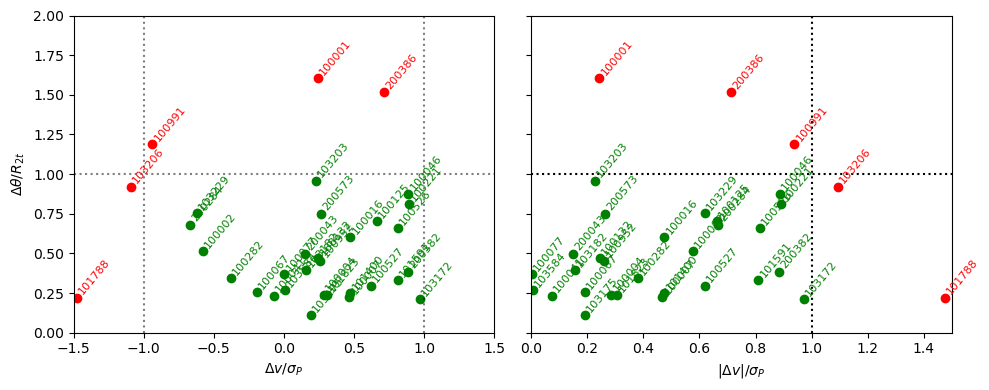

In [40]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.in1d(clusters['Nest'], cluster_id)
    cluster_lon = clusters['SGLON'][idx][0]
    cluster_lat = clusters['SGLAT'][idx][0]
    cluster_mu = clusters['DM'][idx][0]
    cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    cluster_v = H0*cluster_dist
    cluster_sigma = clusters['sigP'][idx][0]
    cluster_R2t = clusters['R2t'][idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.in1d(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5));

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_clusters_selection.png', dpi=150);

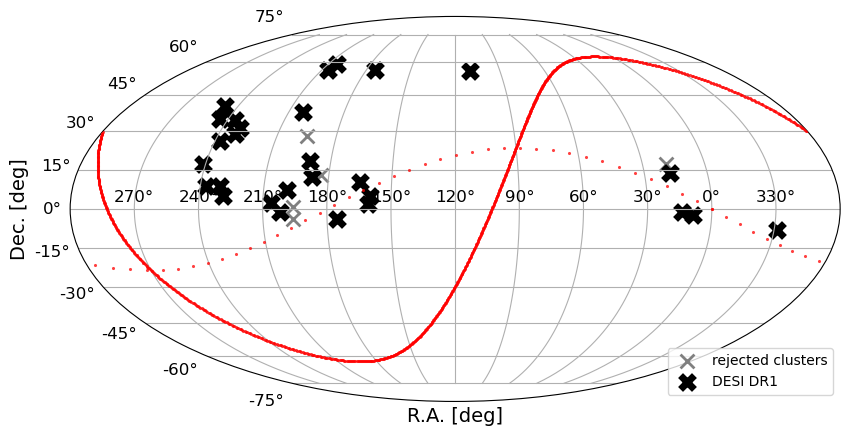

In [41]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.in1d(clusters['Nest'], nest_ids[select])
bad_idx = np.in1d(clusters['Nest'], nest_ids[~select])
good_cluster_coords = SkyCoord(clusters['SGLON'][good_idx], clusters['SGLAT'][good_idx], unit='deg', frame='supergalactic')
bad_cluster_coords = SkyCoord(clusters['SGLON'][bad_idx], clusters['SGLAT'][bad_idx], unit='deg', frame='supergalactic')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected clusters')
ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y3/iron_clusters_sky.png', dpi=150, facecolor='none');

In [42]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100001  20 galaxies  N
 2  100002  34 galaxies  Y
 3  100004  60 galaxies  Y
 4  100007 107 galaxies  Y
 5  100016  24 galaxies  Y
 6  100041  24 galaxies  Y
 7  100046  21 galaxies  Y
 8  100067  30 galaxies  Y
 9  100077  53 galaxies  Y
10  100125  21 galaxies  Y
11  100132  20 galaxies  Y
12  100221  20 galaxies  Y
13  100282  67 galaxies  Y
14  100526  33 galaxies  Y
15  100527  25 galaxies  Y
16  100952  26 galaxies  Y
17  100991  20 galaxies  N
18  101400  26 galaxies  Y
19  101591  22 galaxies  Y
20  101788  24 galaxies  N
21  101823  41 galaxies  Y
22  103172  21 galaxies  Y
23  103175  37 galaxies  Y
24  103182  29 galaxies  Y
25  103203  20 galaxies  Y
26  103206  20 galaxies  N
27  103229  23 galaxies  Y
28  103584  25 galaxies  Y
29  200043  29 galaxies  Y
30  200284  30 galaxies  Y
31  200382  29 galaxies  Y
32  200386  44 galaxies  N
33  200573  22 galaxies  Y


## Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (194.75582168, 27.93269246)>
7345.138681571143 +/- 1045 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (183.57780685, 13.09060247)>
21086.281499332887 +/- 1482 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.7953898, 0.67439744)>
21877.616239495565 +/- 1599 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (195.74616921, -3.87530193)>
23550.492838960086 +/- 1529 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (18.44359042, 16.98990087)>
19860.949173573757 +/- 2303 km/s


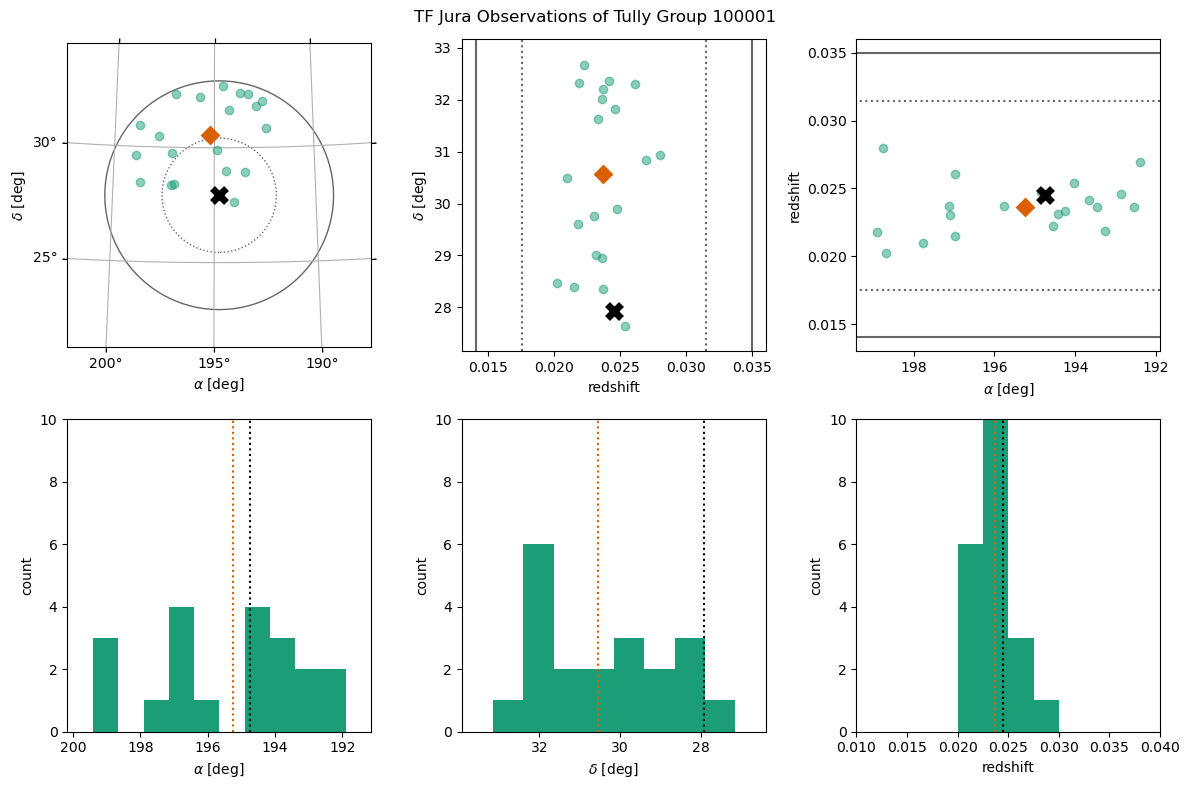

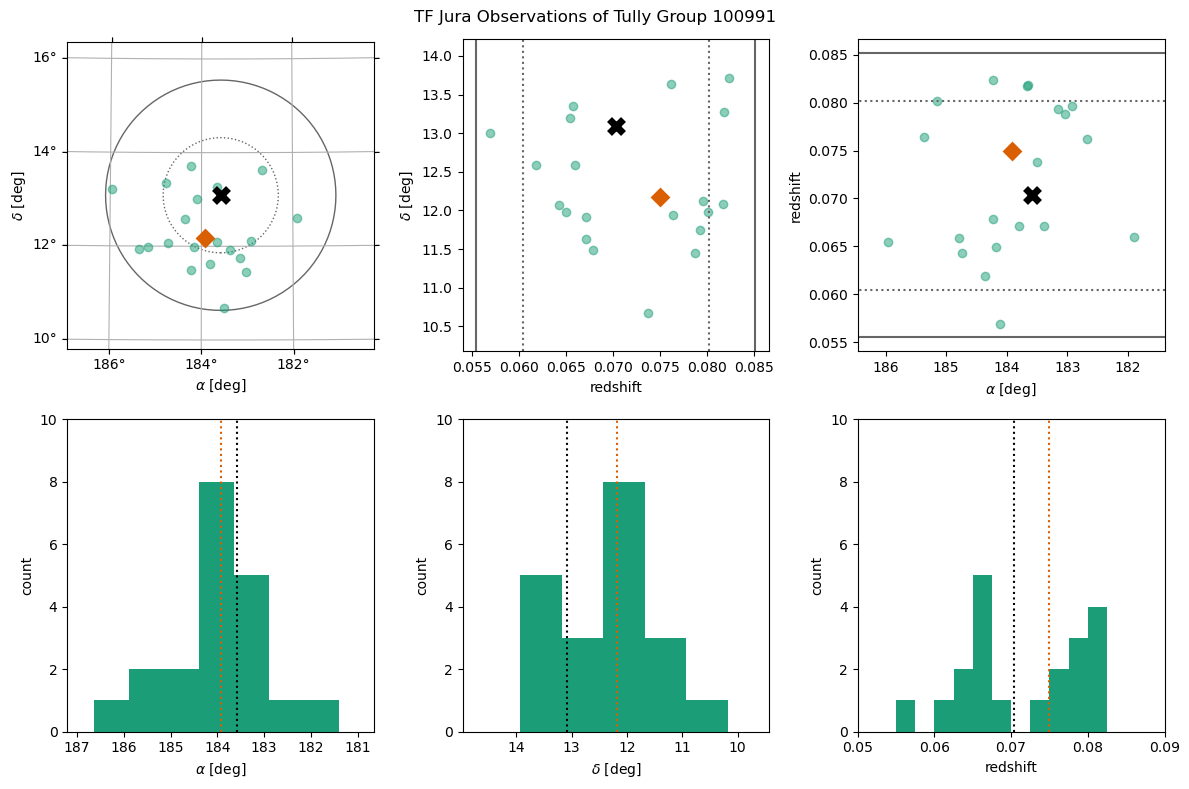

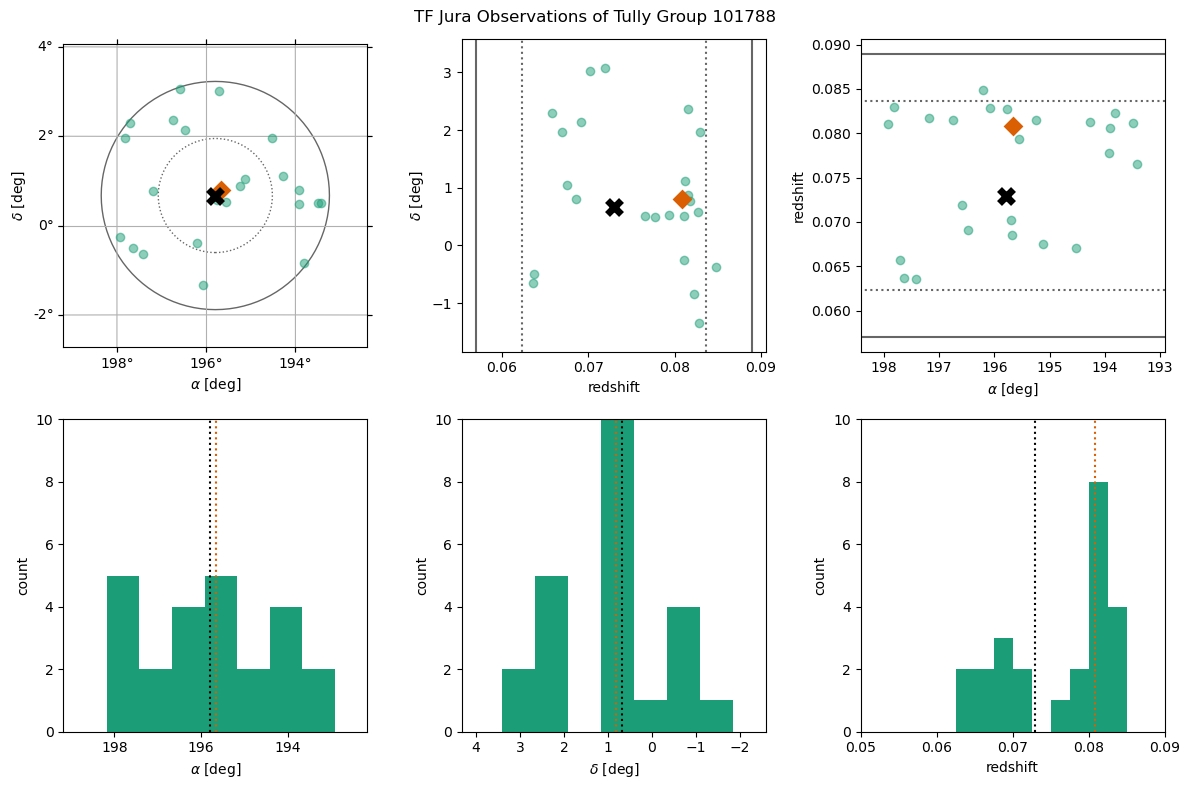

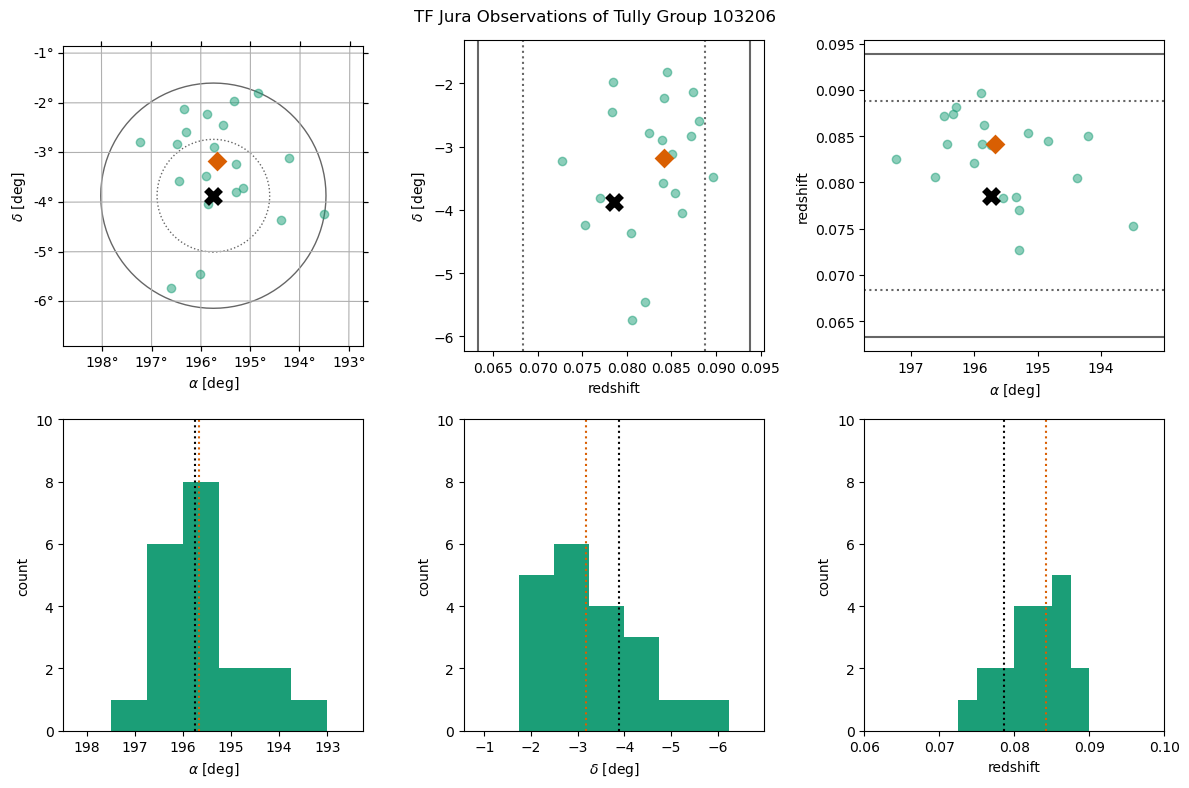

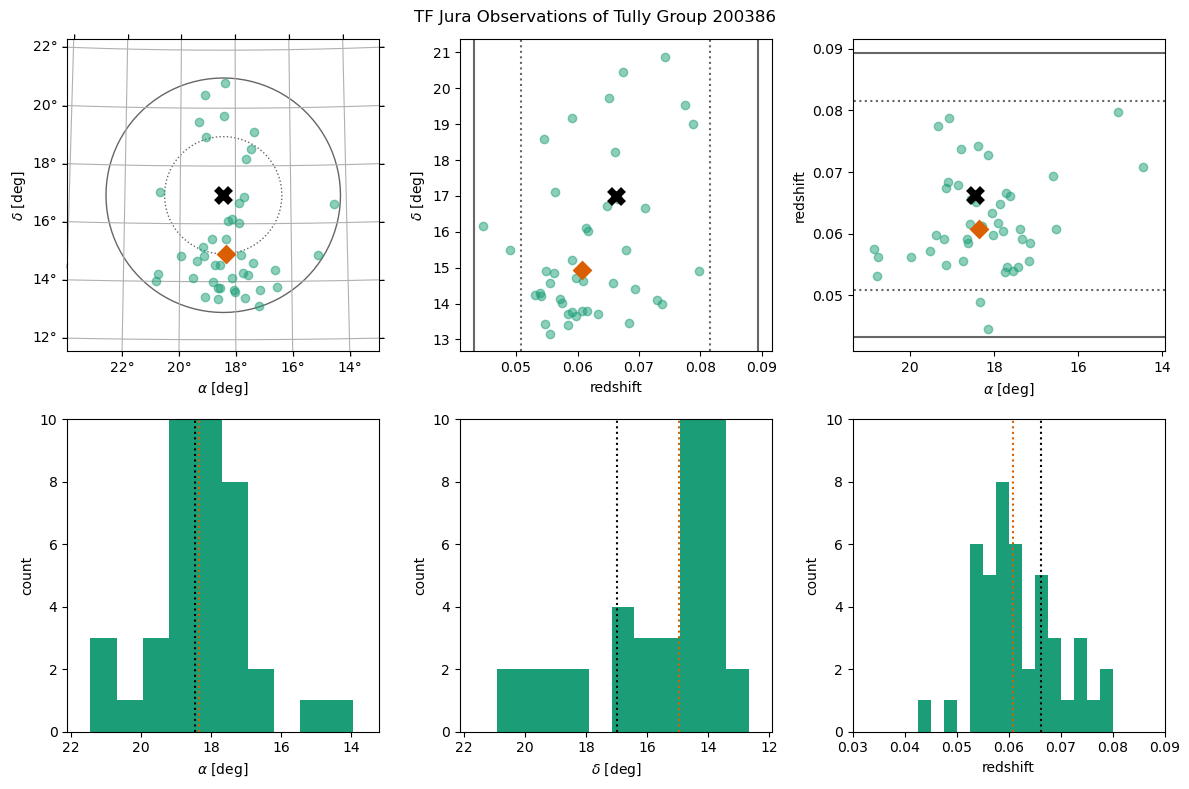

In [43]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1492.7944095789974 +/- 707 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1385 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (110.17218675, 55.6898024)>
12022.64434617413 +/- 1037 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 1914 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.82189669, 10.09092567)>
11066.237839776675 +/- 744 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (199.15794579, 7.32962624)>
15417.004529495585 +/- 1049 km/s
<S

/tmp/ipykernel_1546065/805910609.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8), tight_layout=True)


<SkyCoord (ICRS): (ra, dec) in deg
    (202.33739481, 37.62288797)>
17782.794100389227 +/- 783 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (14.13239492, -1.08658284)>
13243.415351946644 +/- 1077 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (17.93151711, 13.53834251)>
16904.409316432666 +/- 1285 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (328.77363049, -8.05653143)>
20044.72027365159 +/- 2055 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (8.7960233, -2.15186295)>
17298.163592150995 +/- 1069 km/s


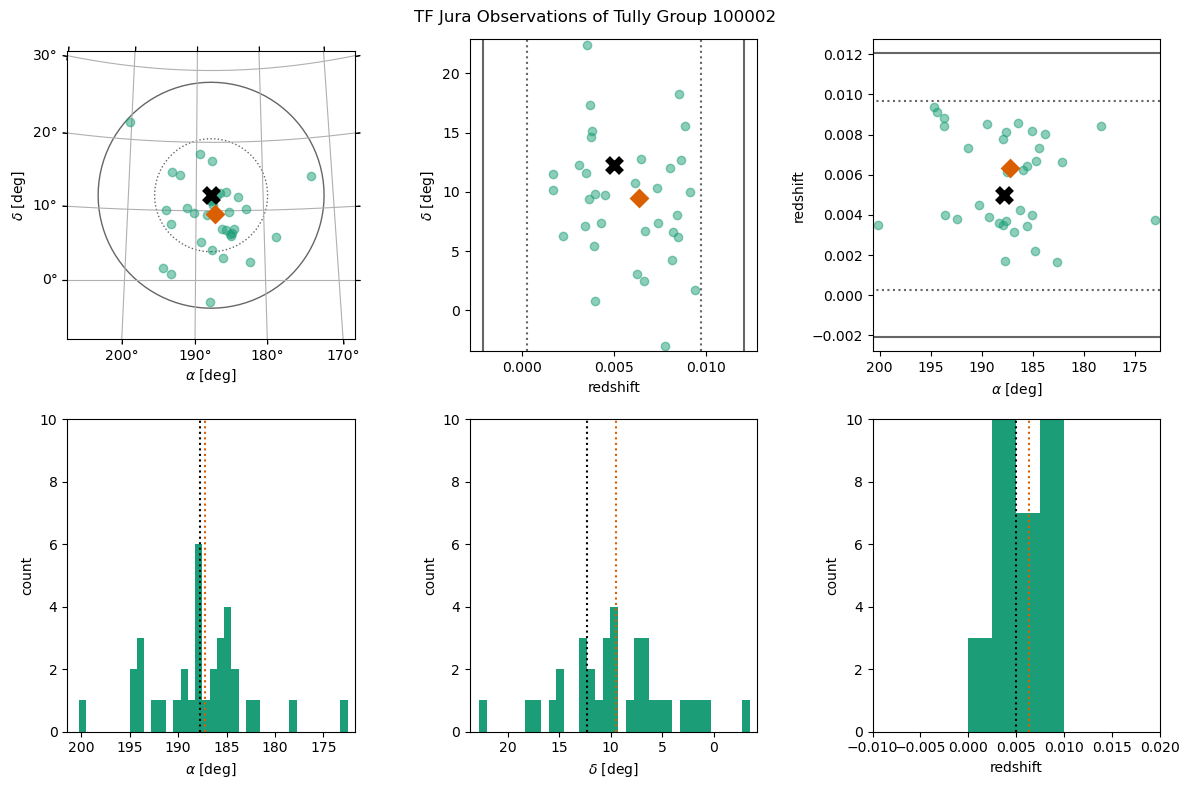

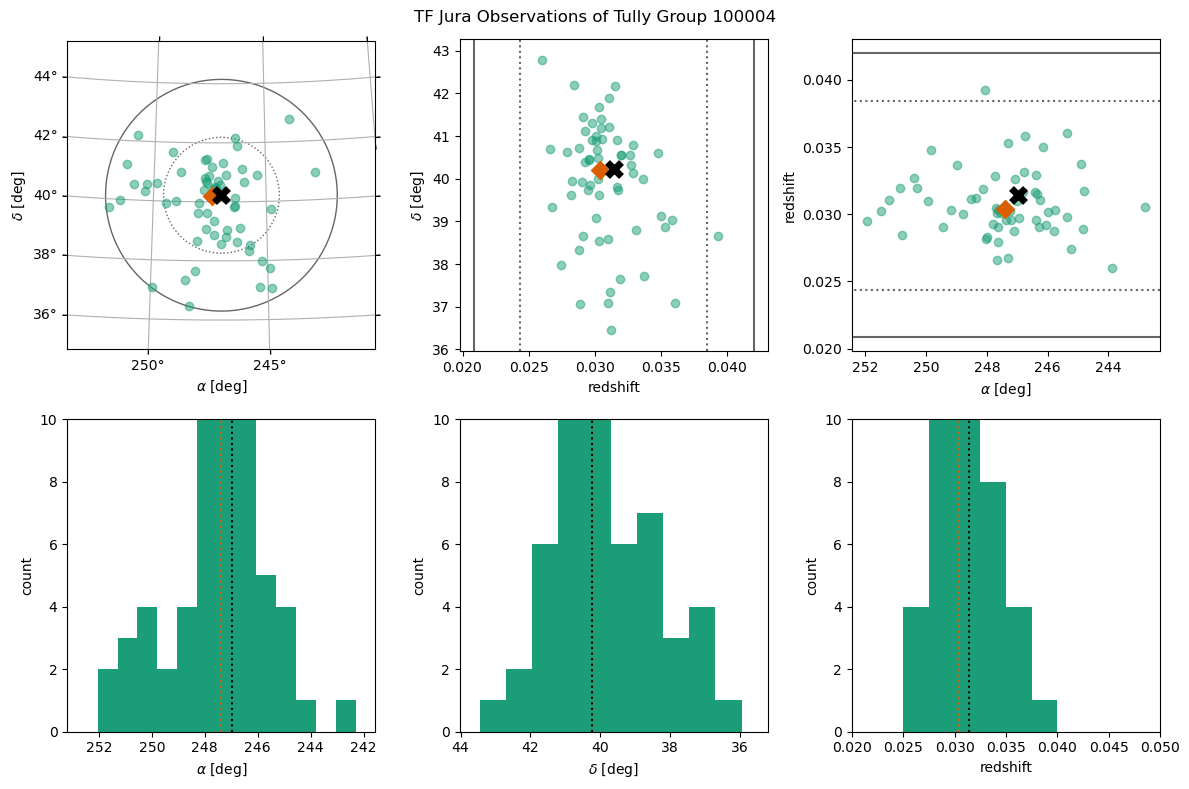

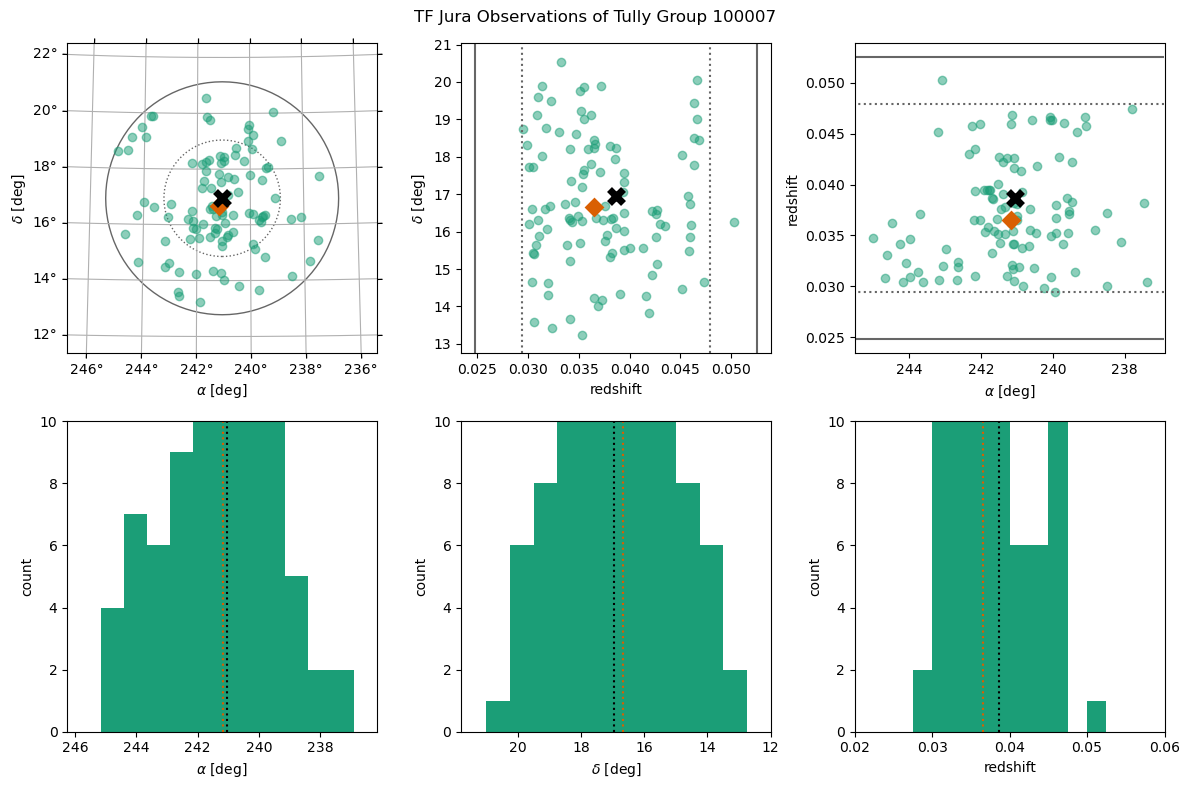

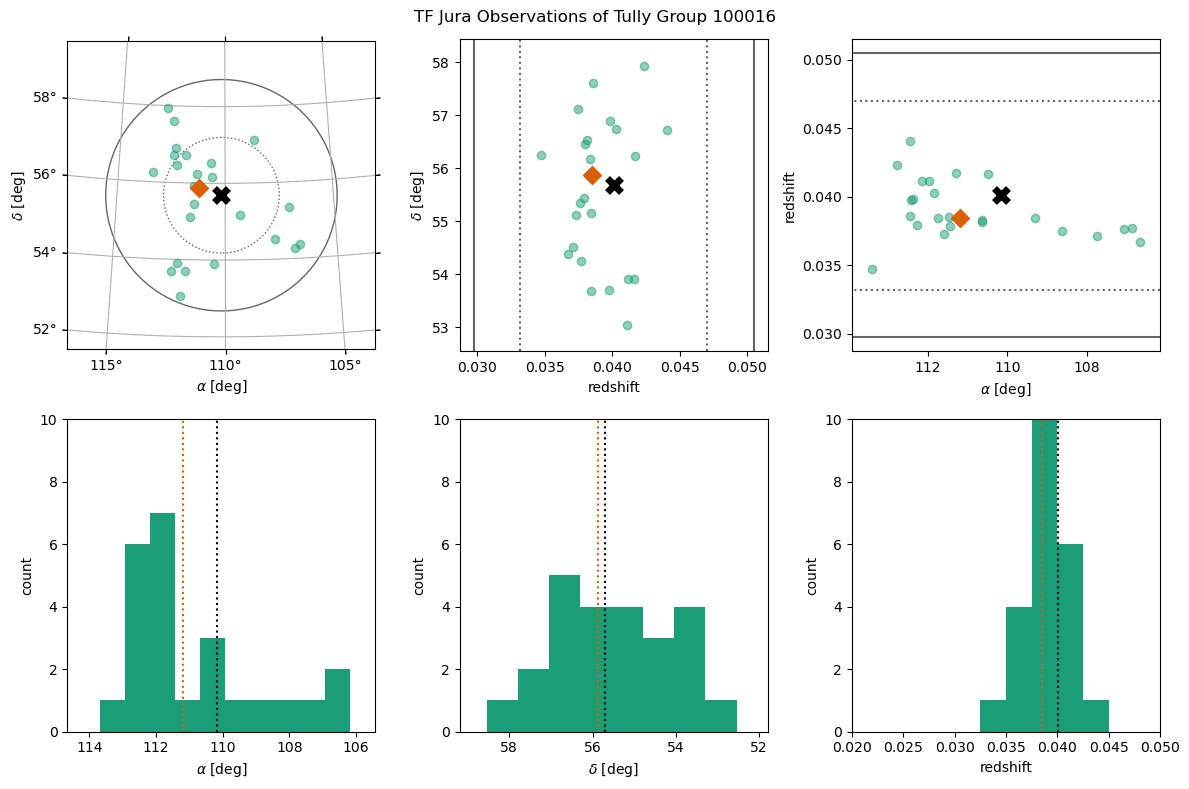

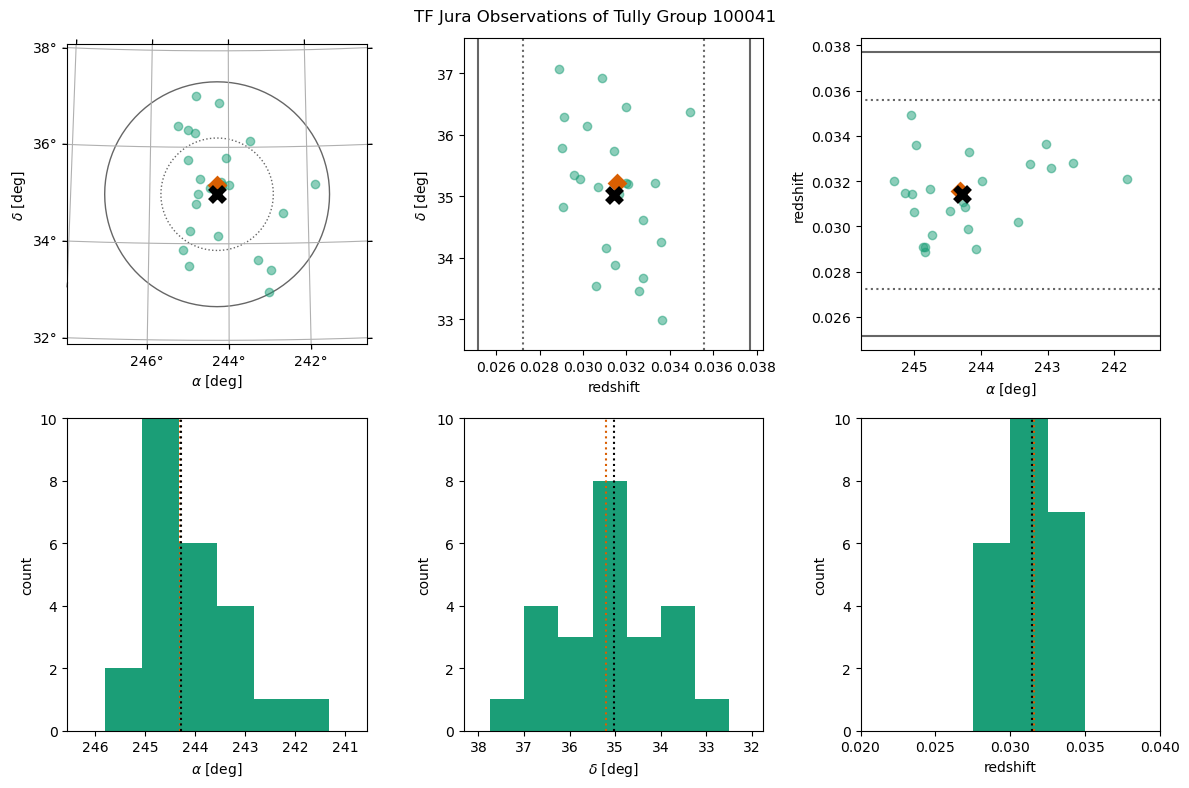

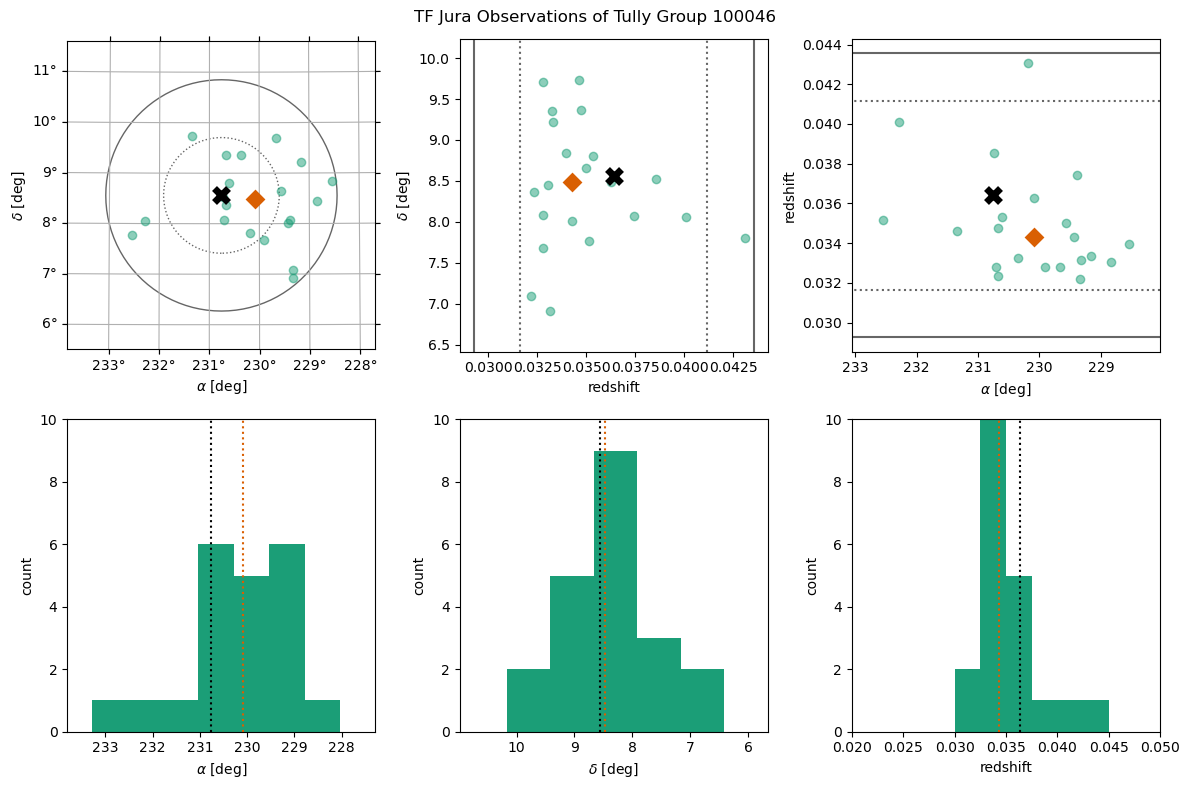

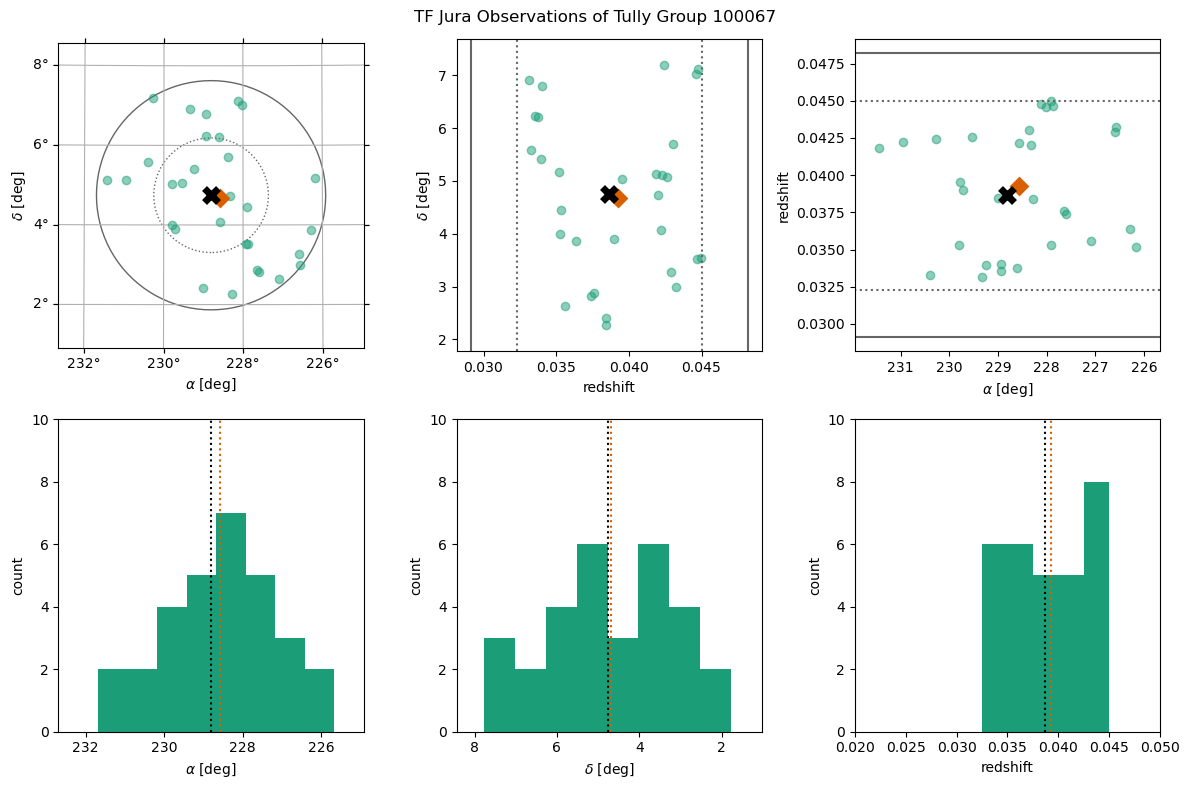

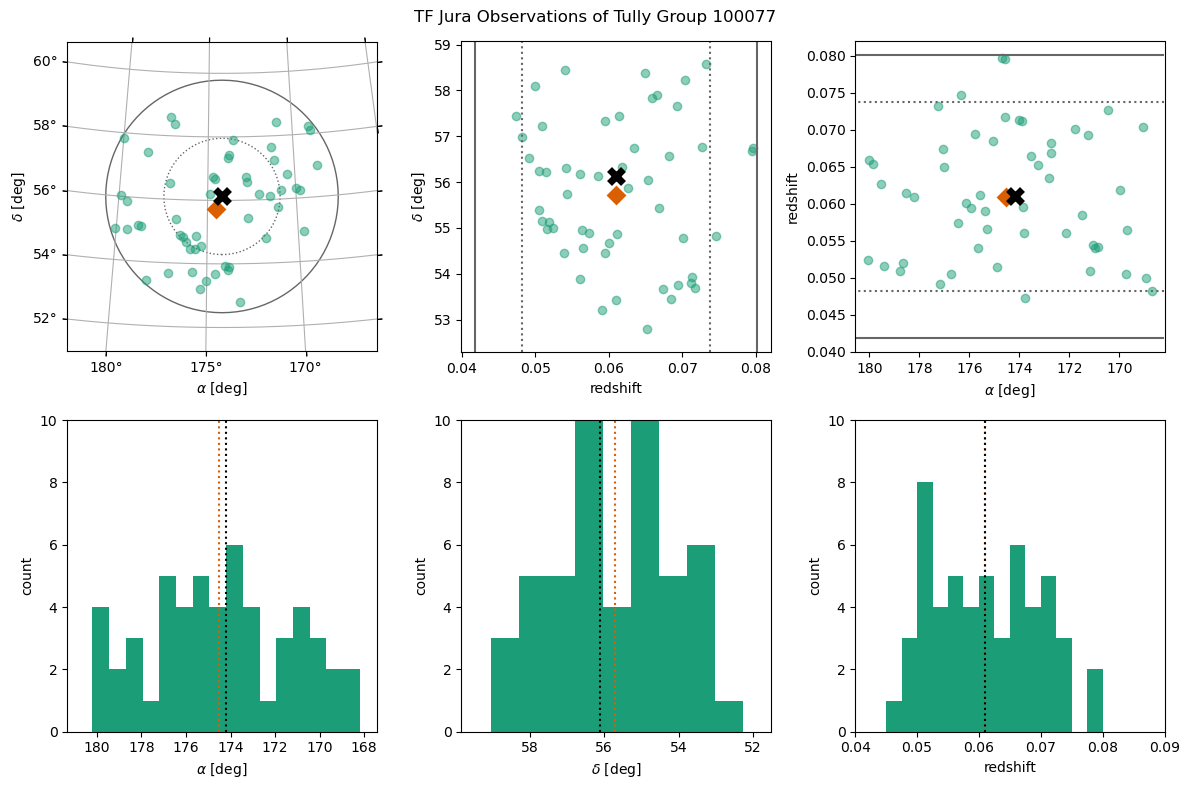

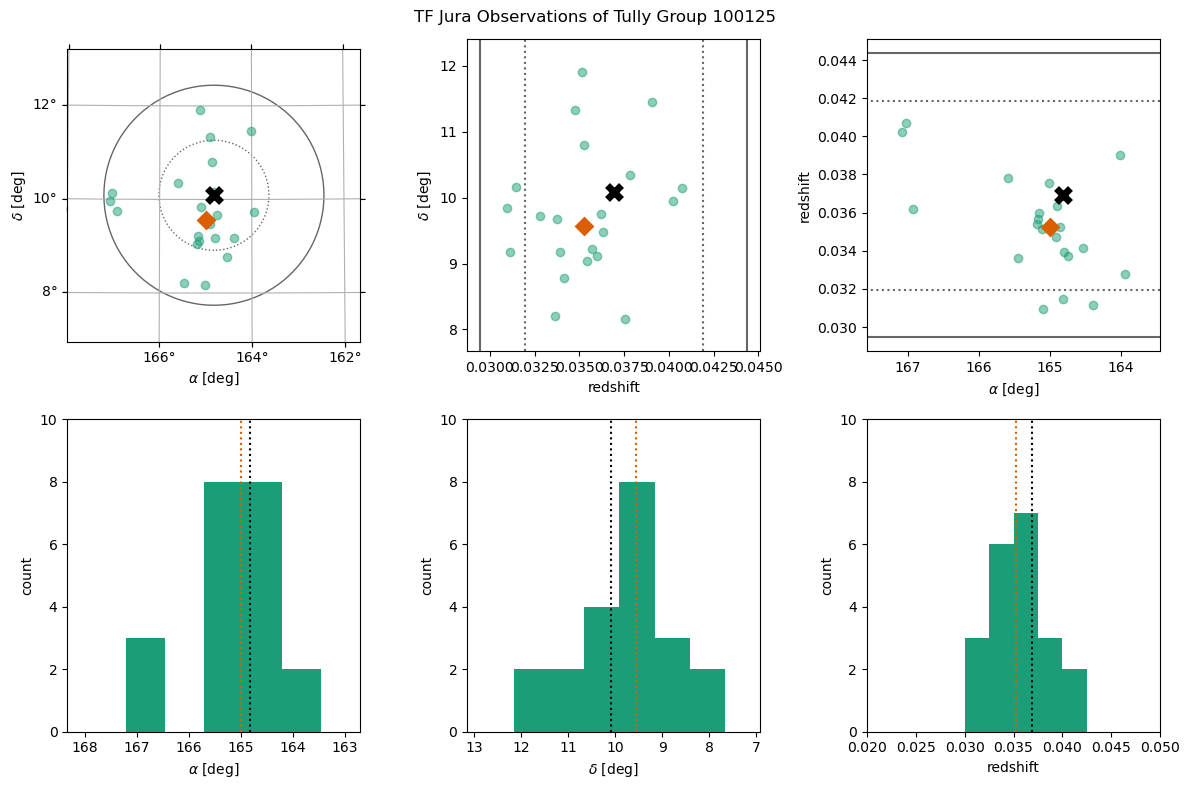

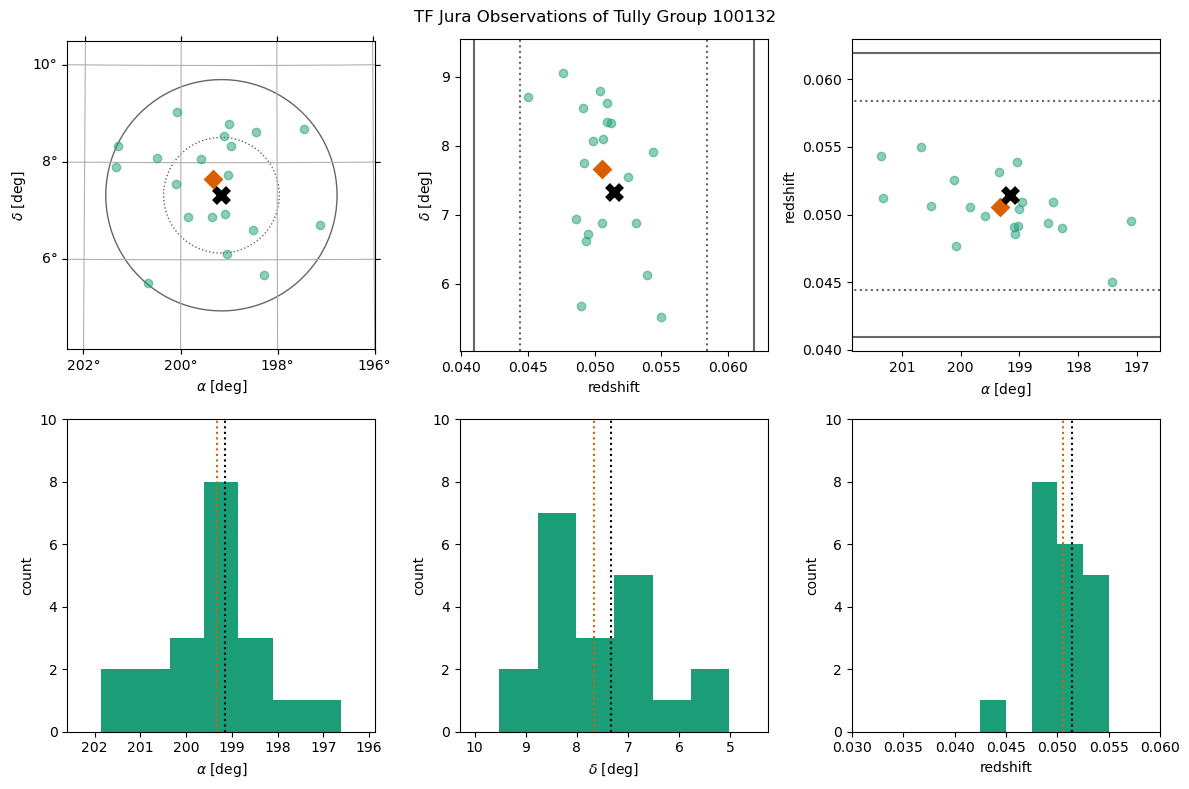

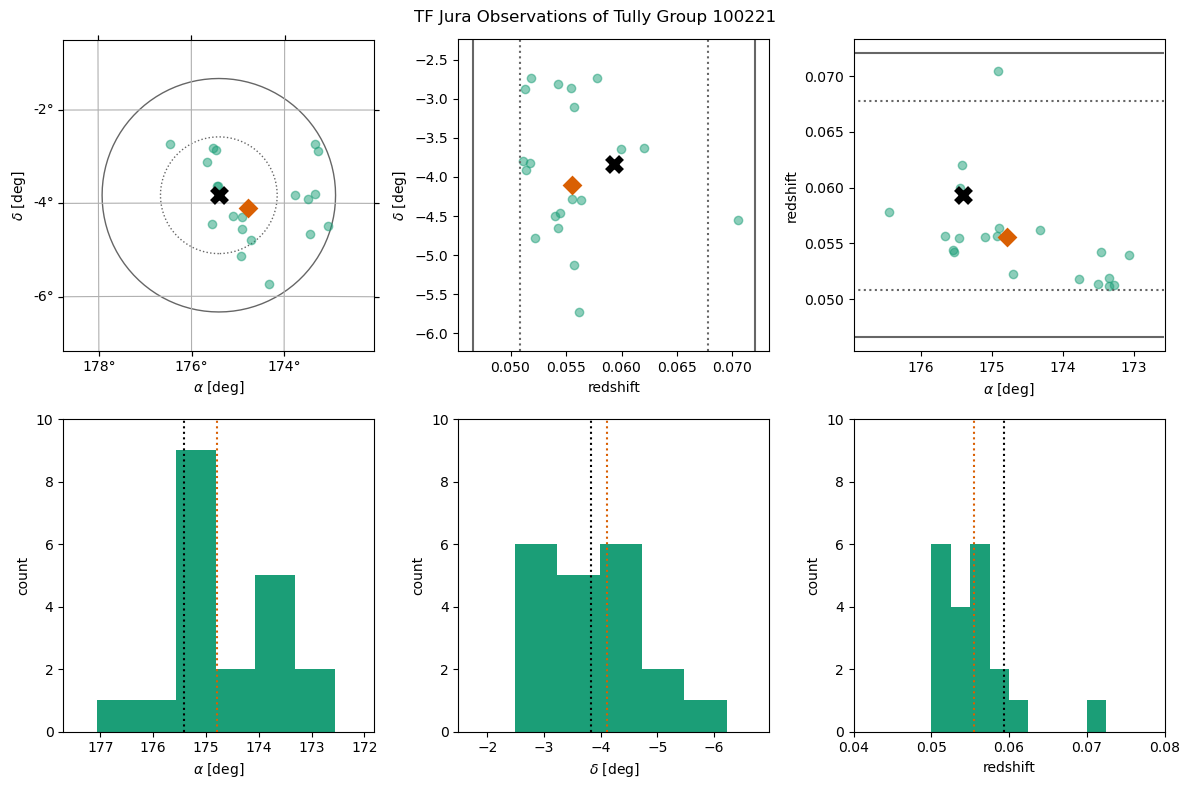

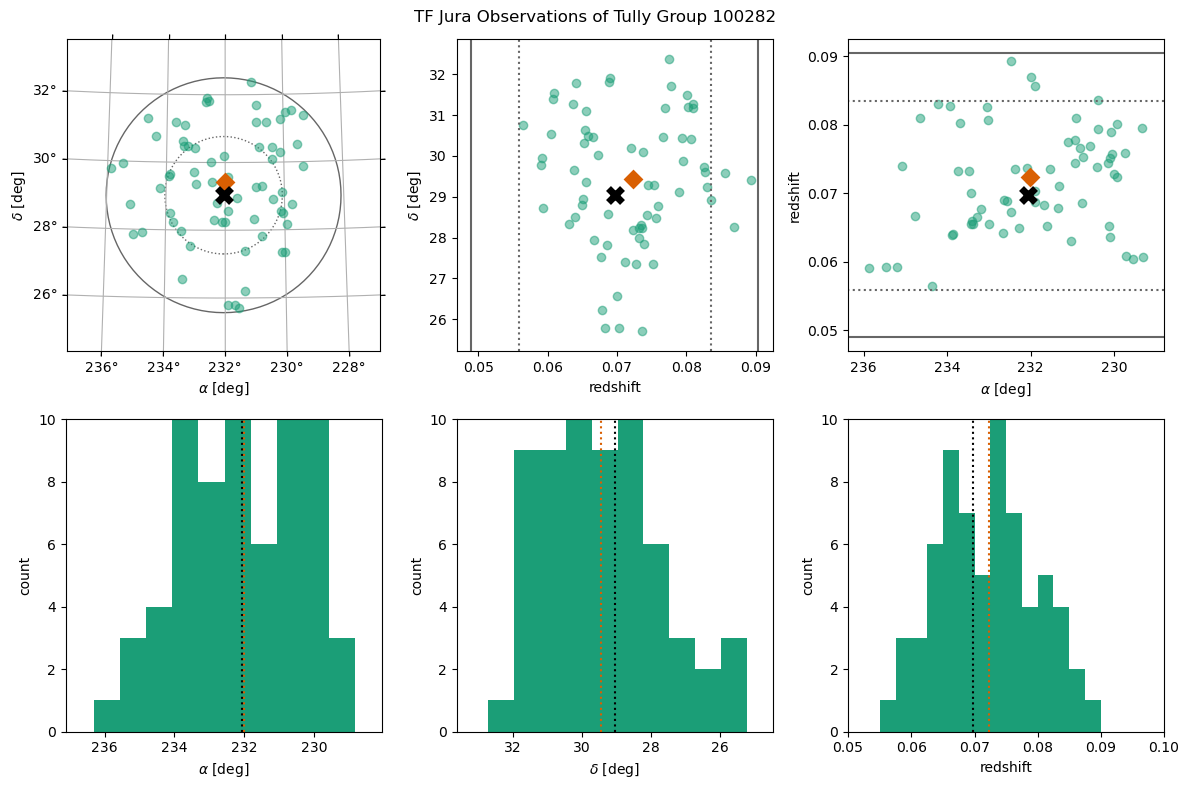

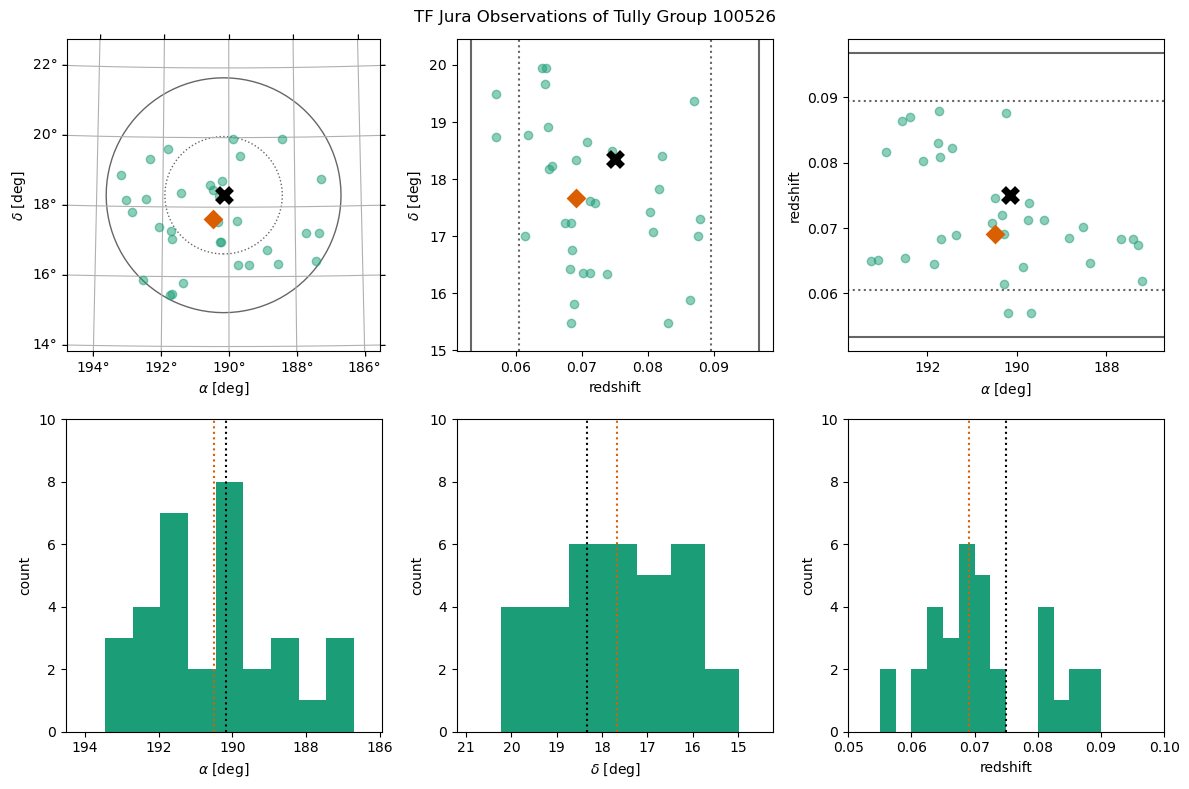

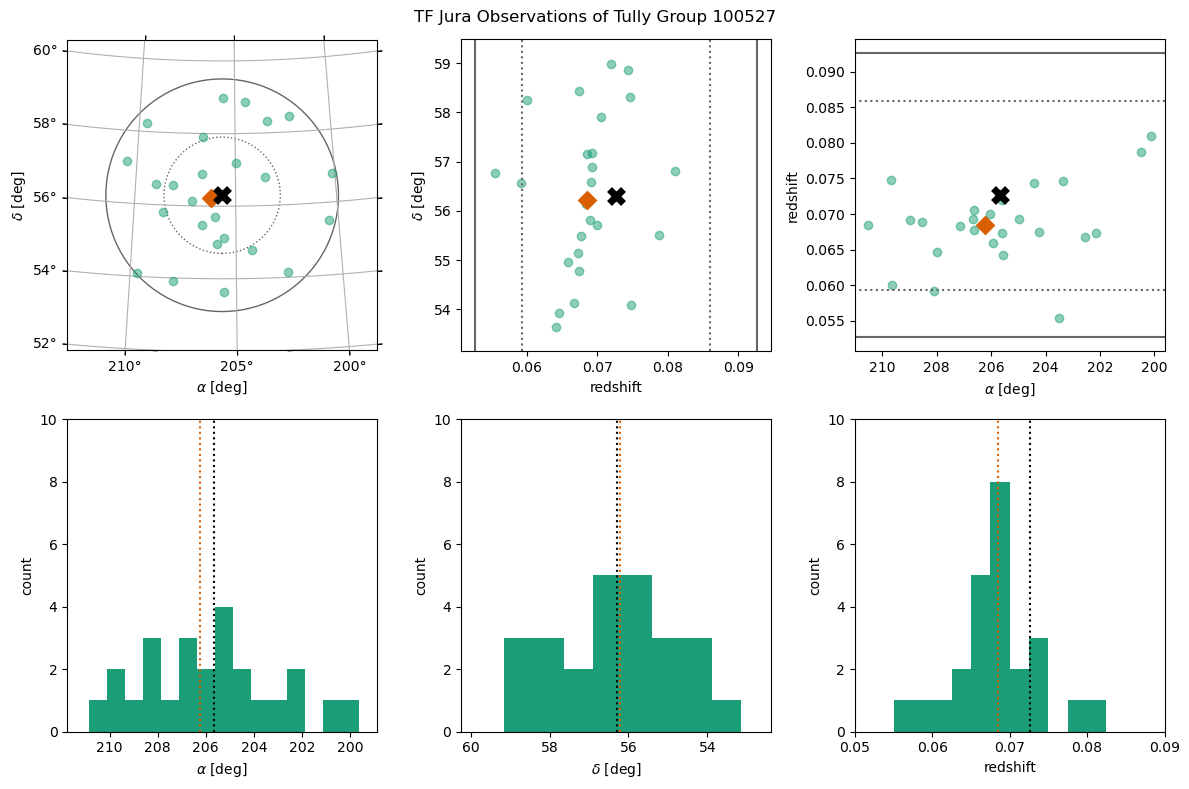

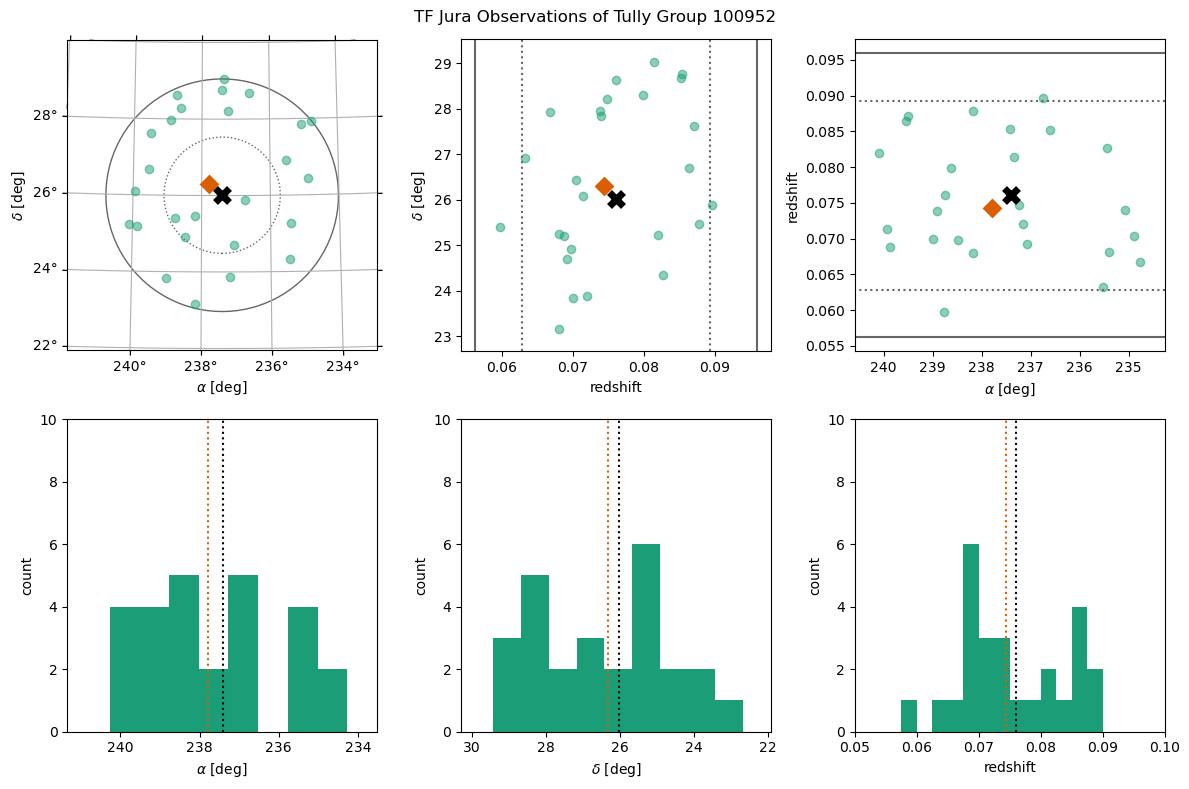

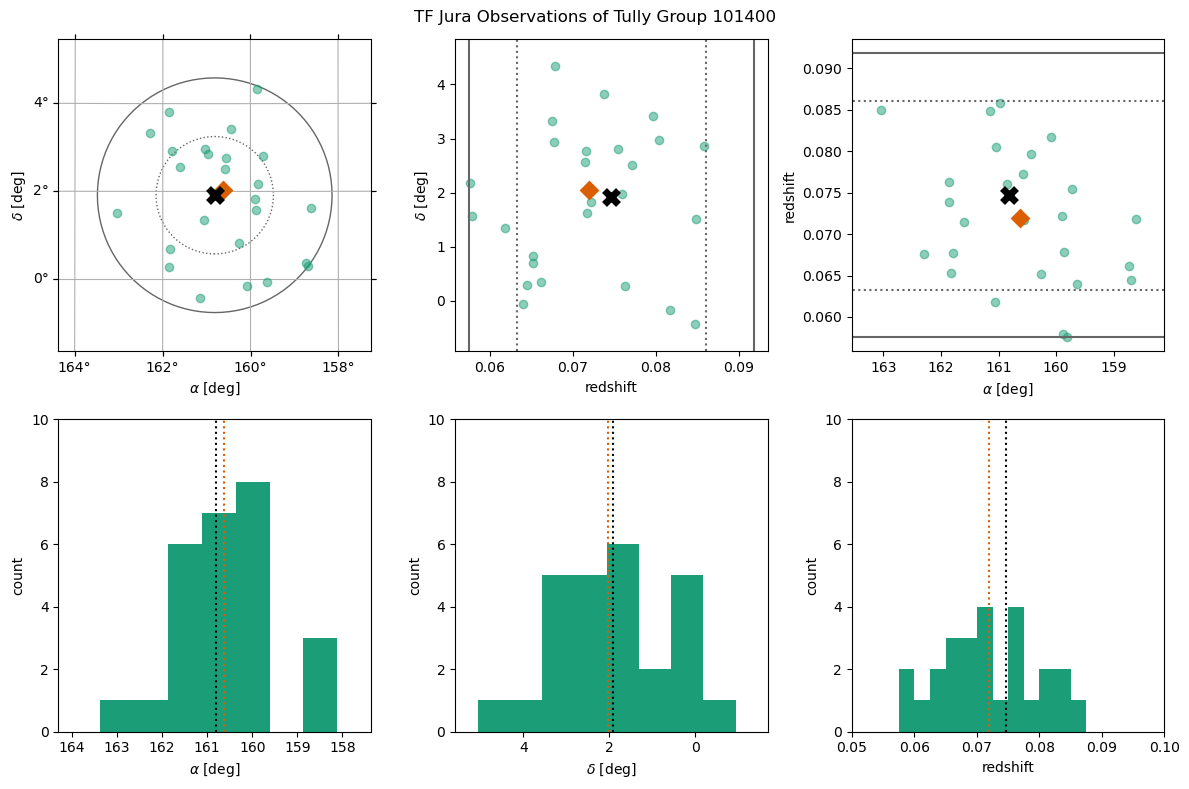

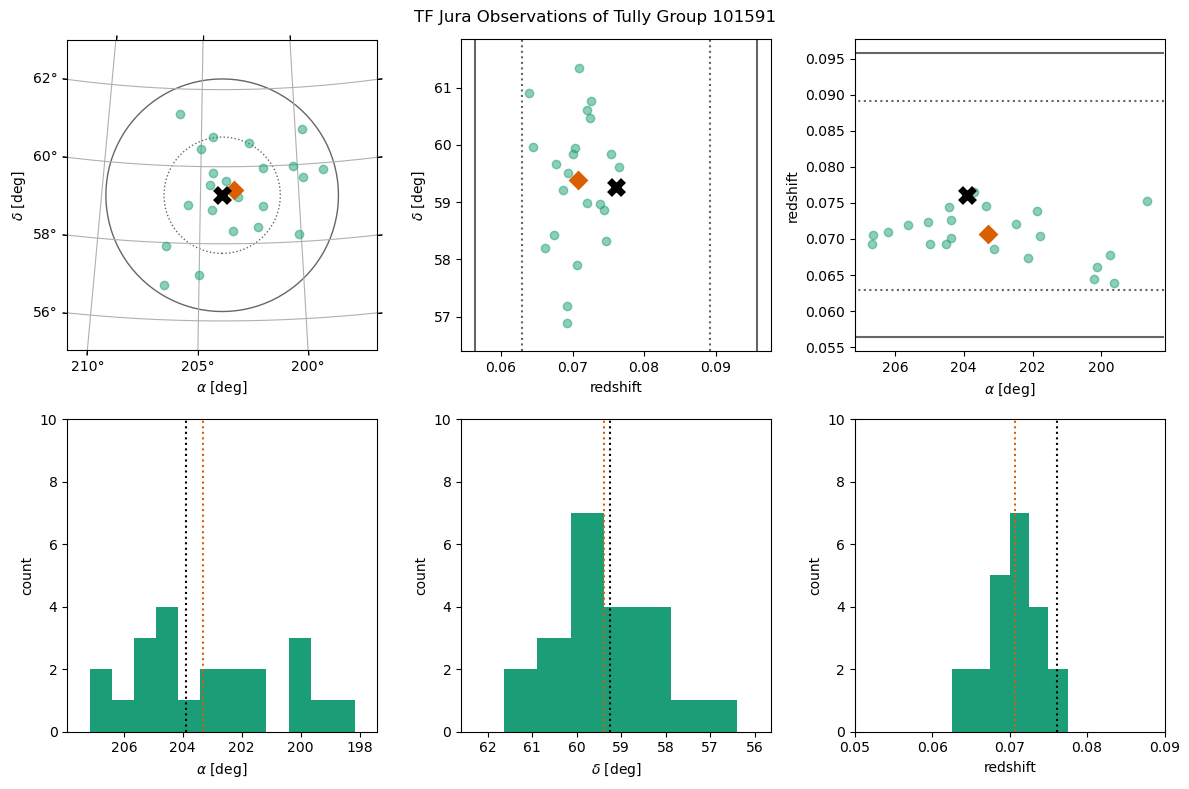

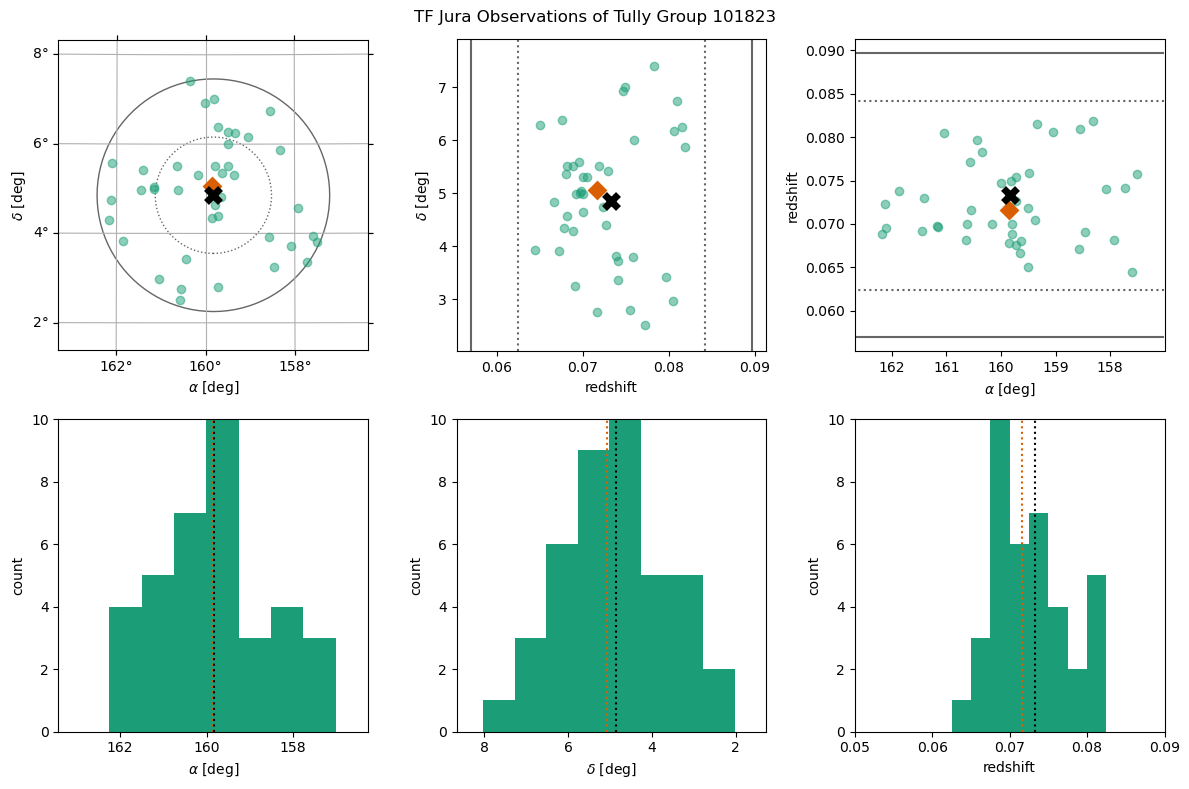

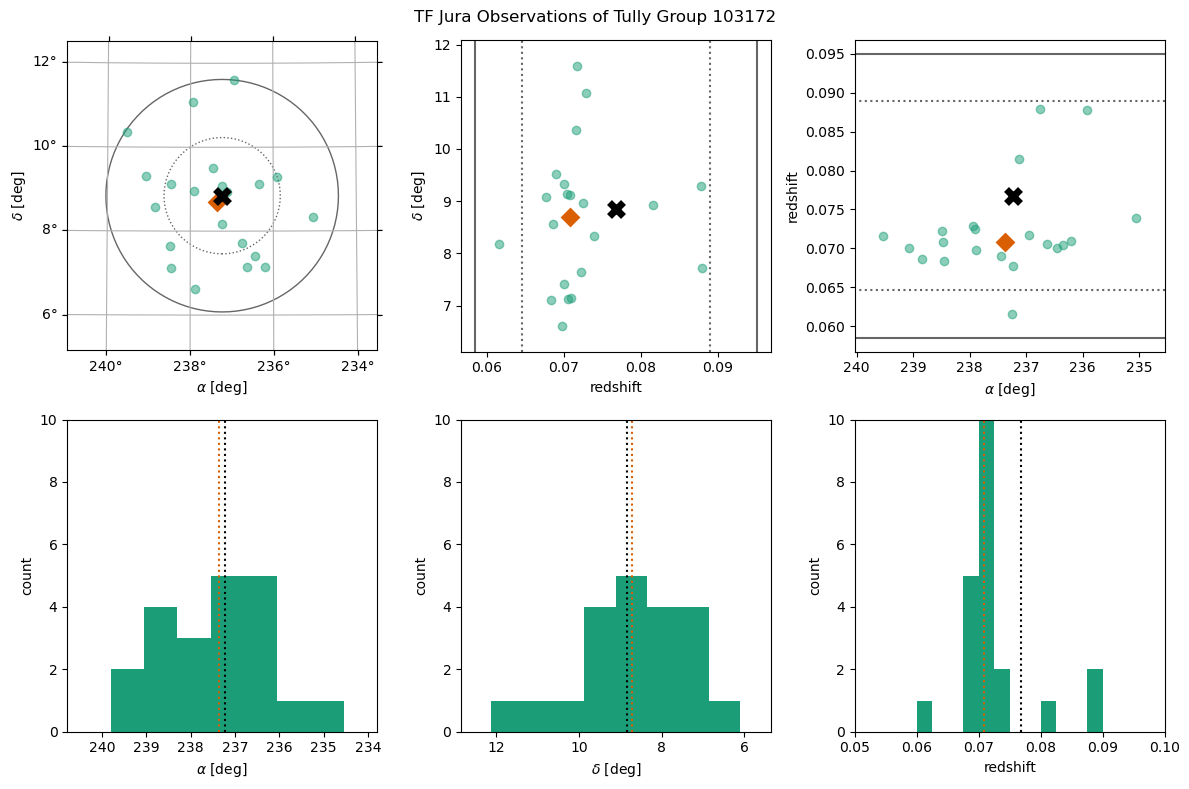

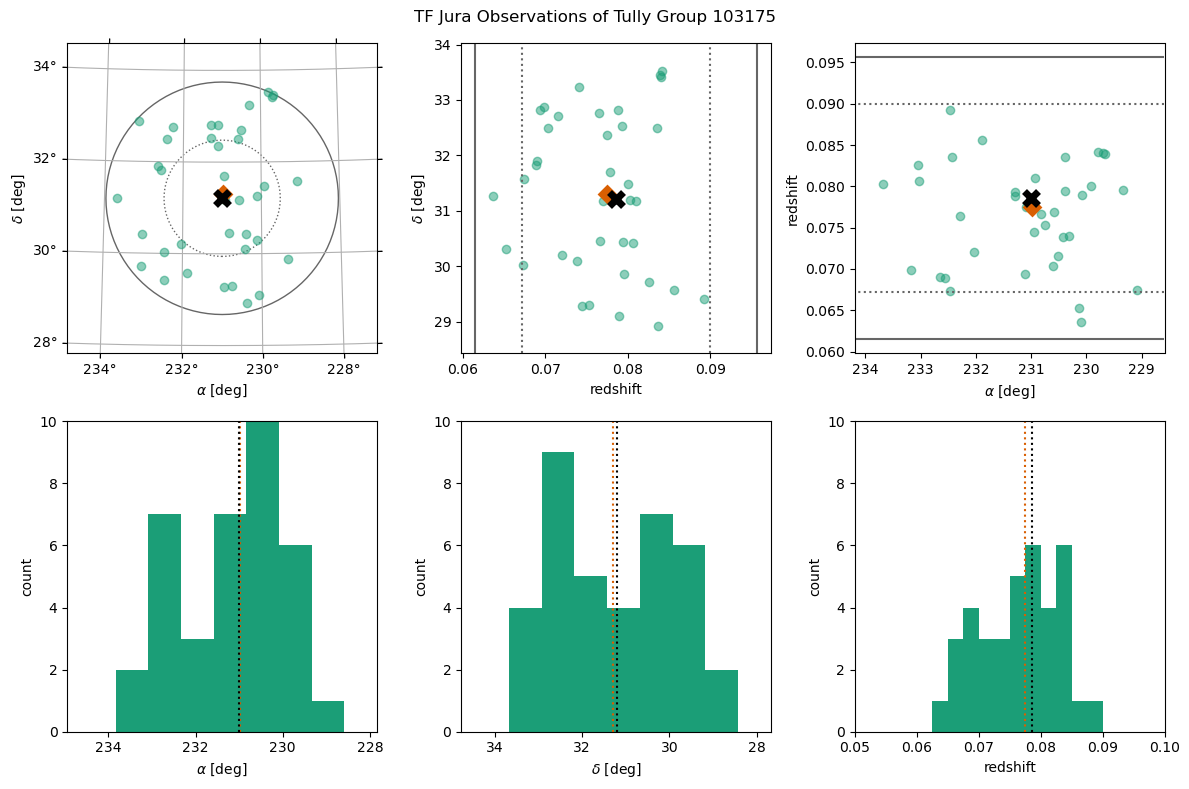

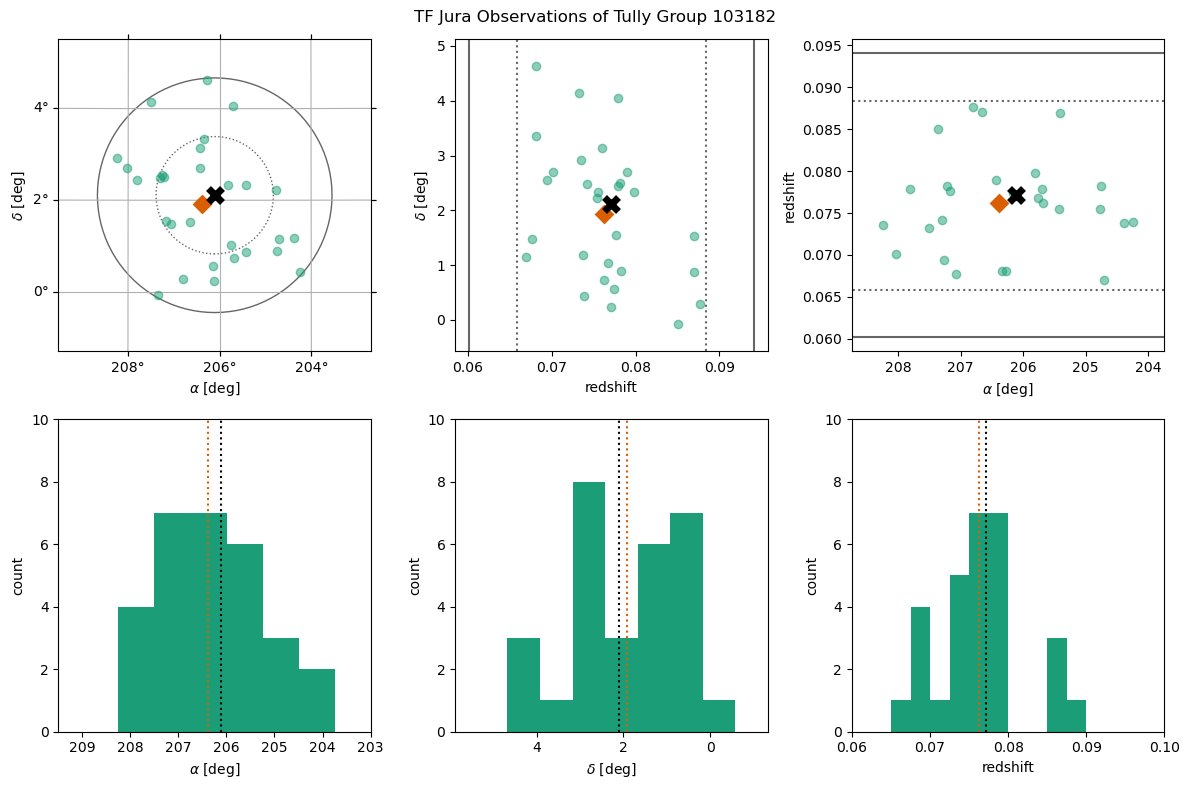

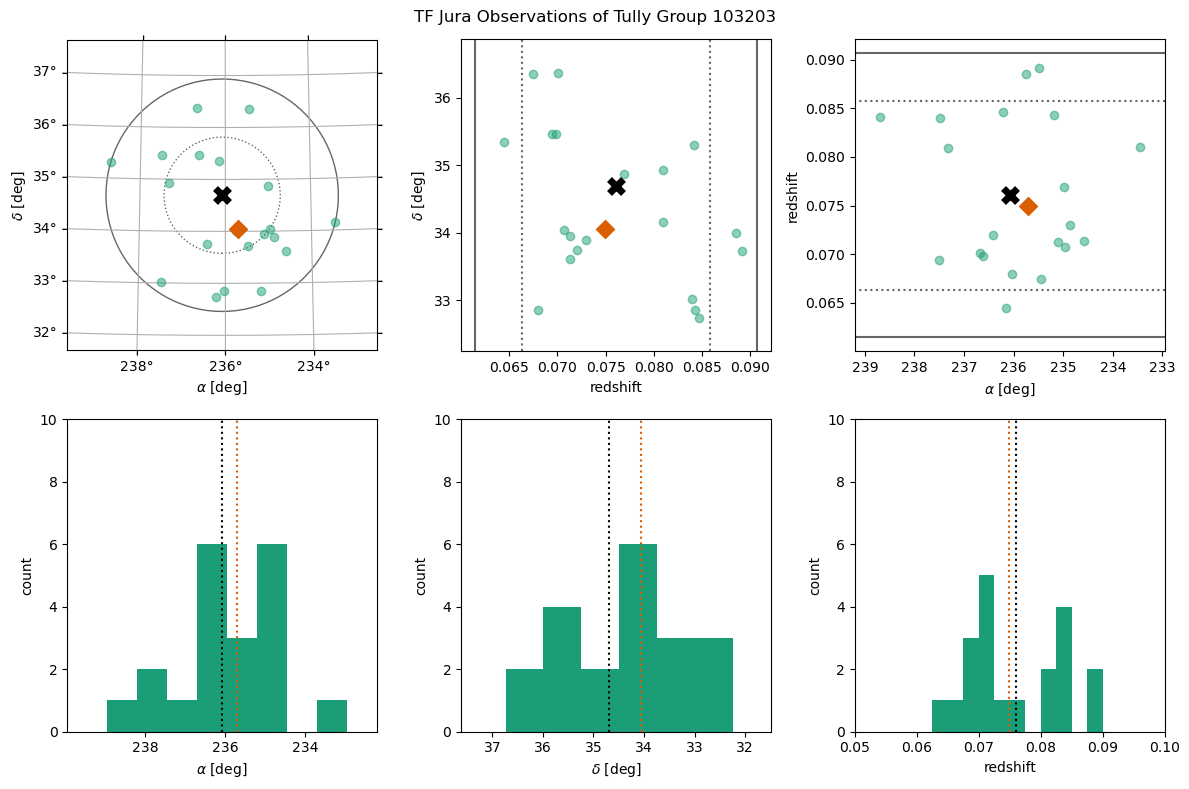

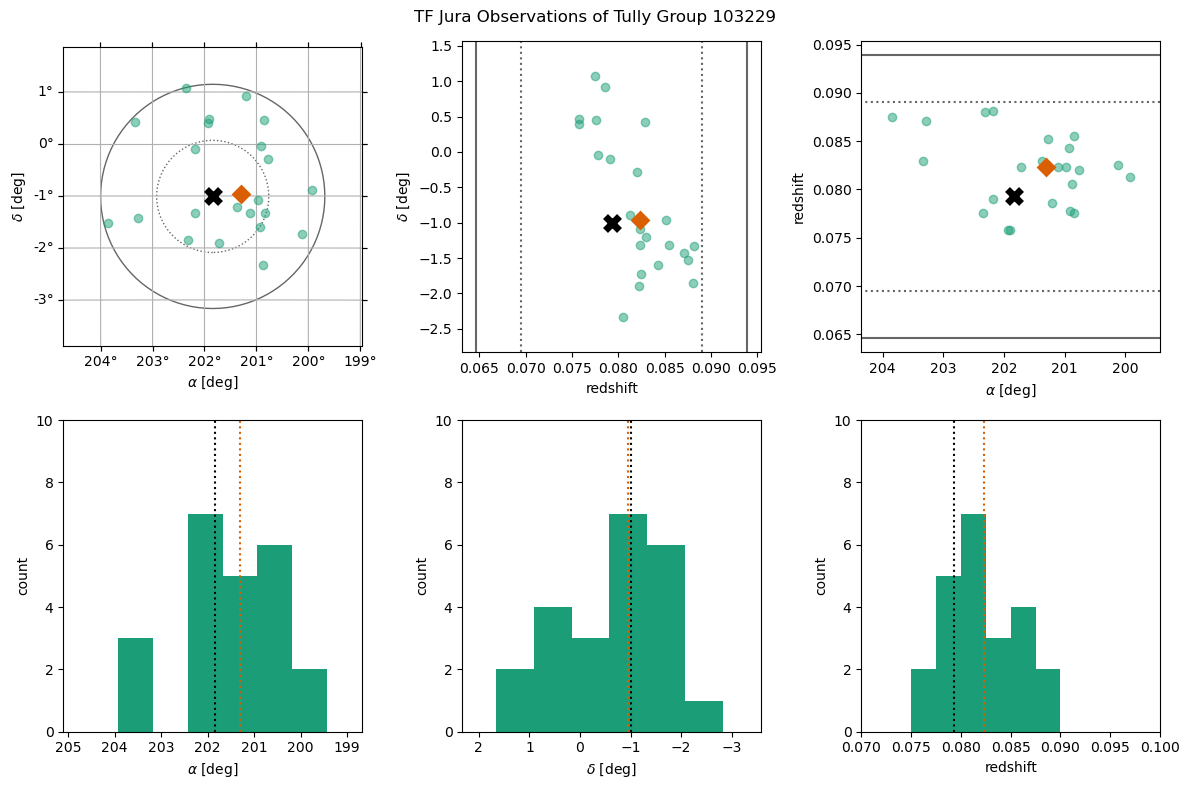

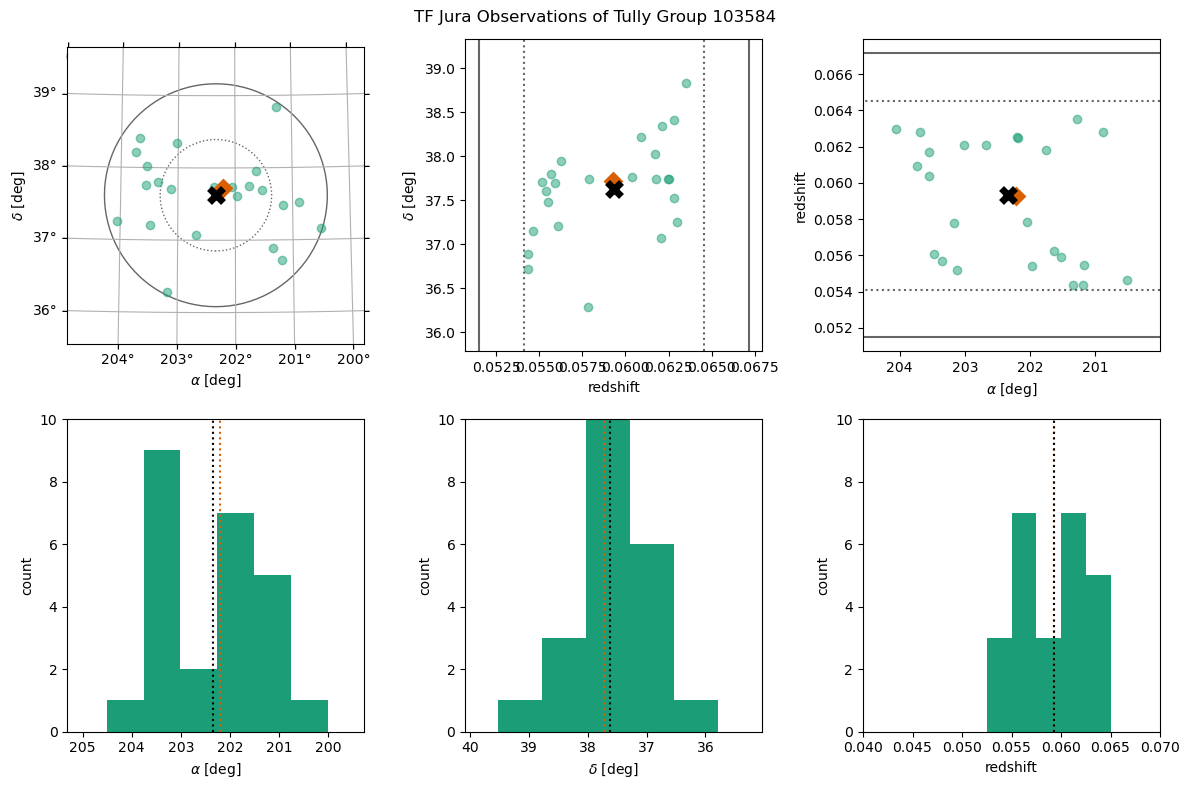

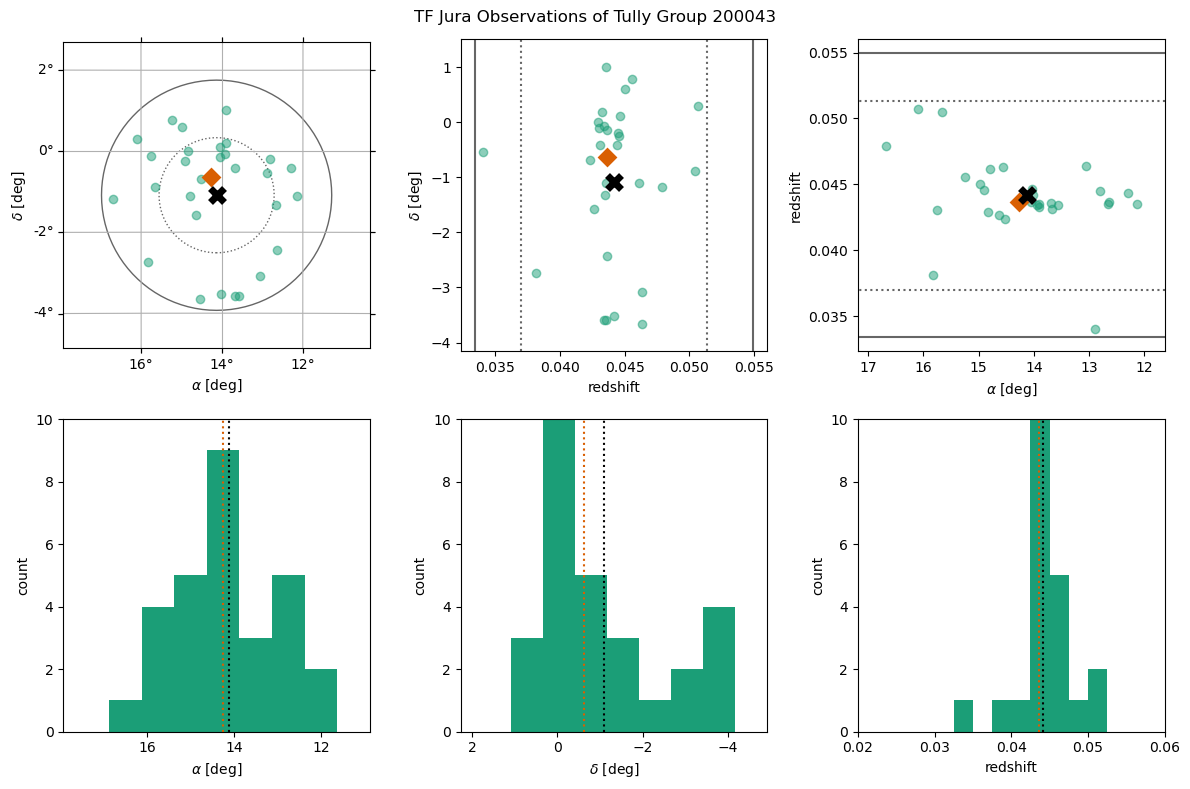

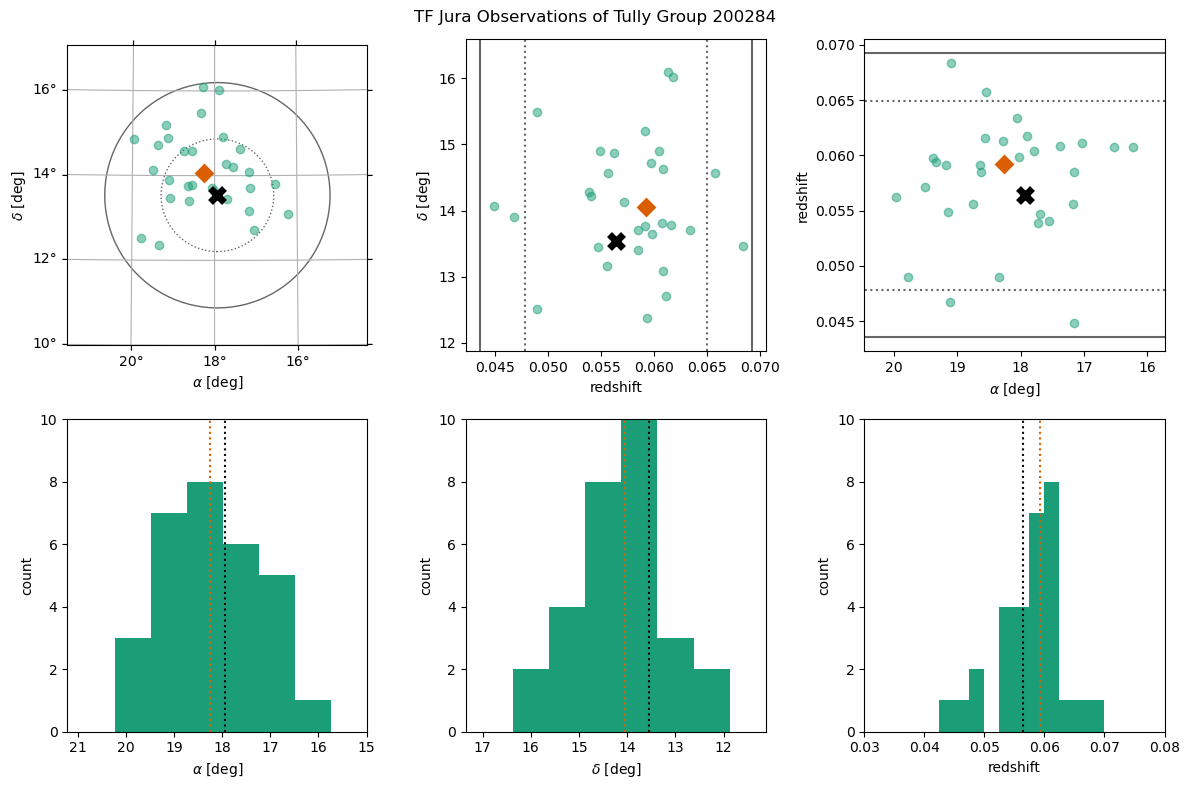

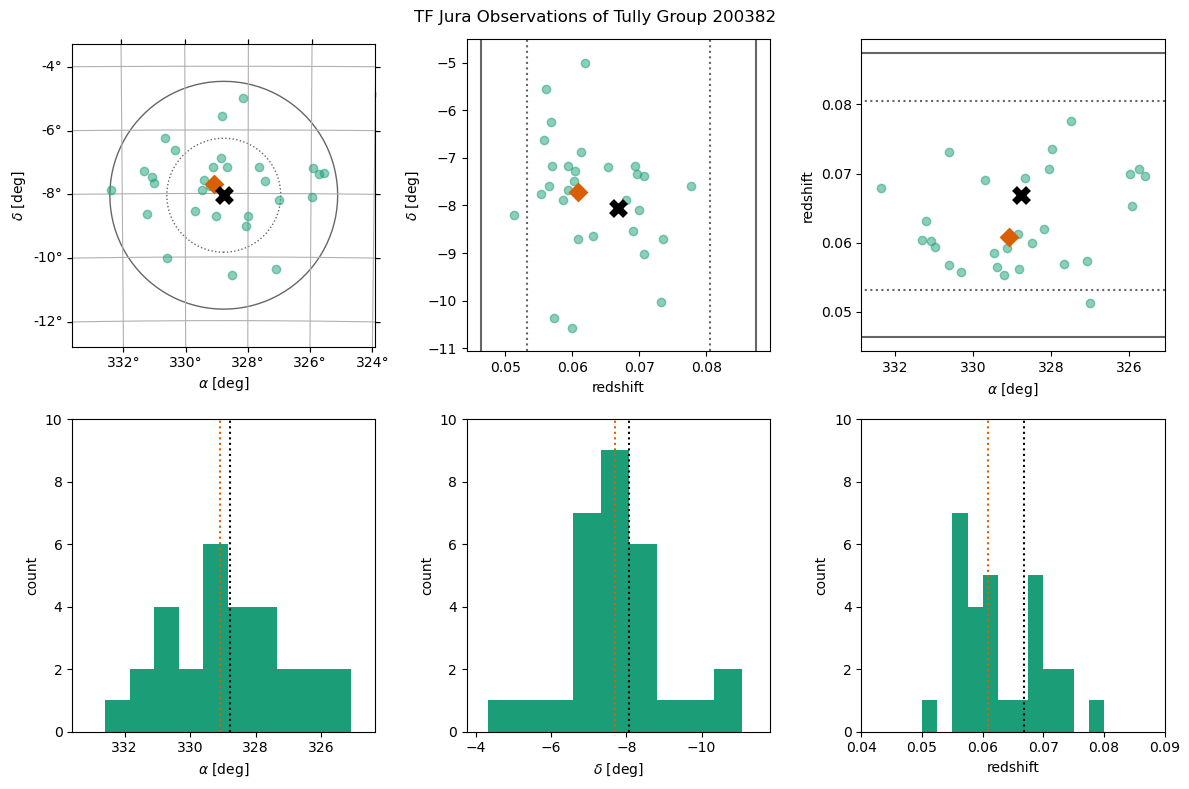

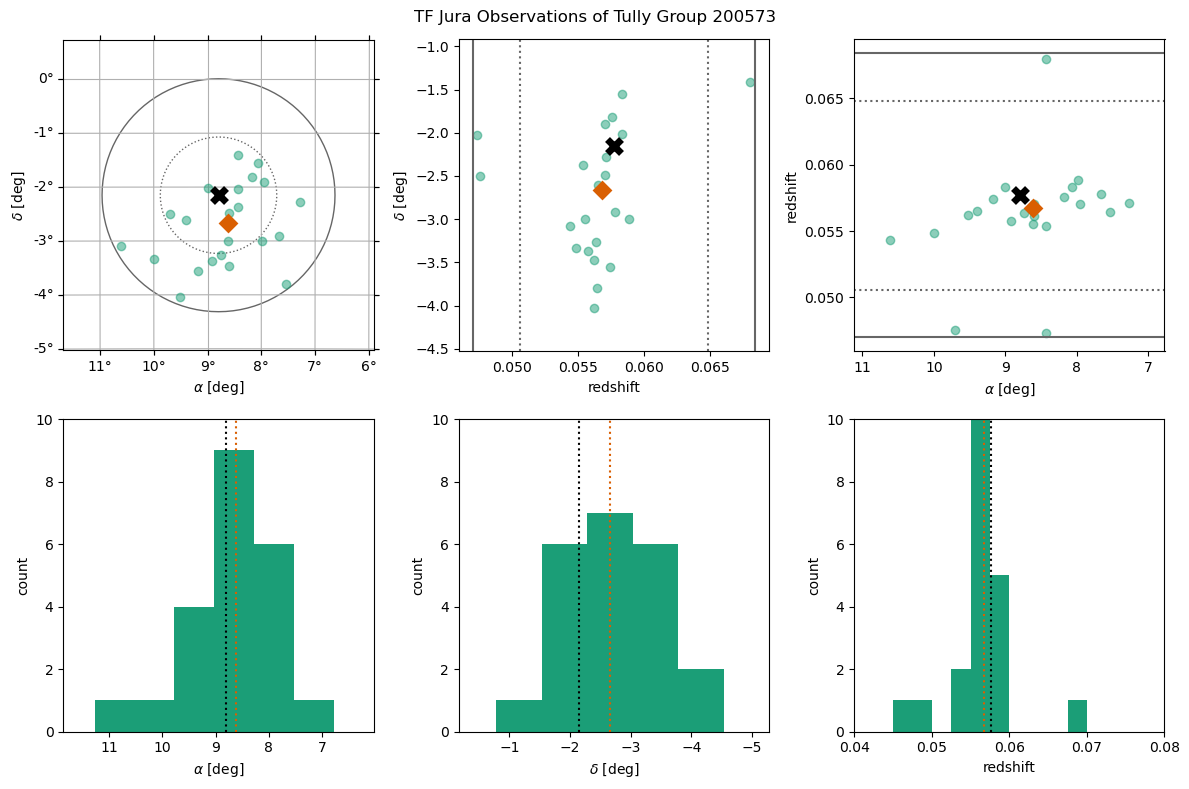

In [44]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [45]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.in1d(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

if caltab is not None: 
    print(len(caltab))
elif caltab is None: 
    print('no groups')
    
caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

919


<Table length=919>
CLUSTER_ID   SGA_ID  ...      V_0p4R26         V_0p4R26_err   
  int32     float64  ...      float64            float64      
---------- --------- ... ------------------ ------------------
    100002    2056.0 ...  34.50674217444195   7.07388415930831
    100002    8508.0 ...  174.2609331425823  7.316958003439503
    100002  246089.0 ... 52.496790889842906  7.173969935376275
    100002  272621.0 ...  36.89095240847077 12.957249994342819
    100002  277652.0 ... 36.355084558543226  3.867439633549786
    100002  278987.0 ... 22.874100367973096  7.084289994221817
    100002  284683.0 ...  33.53370098752667 16.054928078752997
    100002  351331.0 ...  45.69857330777425  14.19930445443449
    100002  358009.0 ...  43.84315982219643  6.733007283466576
    100002  396108.0 ... 162.77271283769775    17.903639259177
       ...       ... ...                ...                ...
    200573  856565.0 ... 161.15100291238429  8.881035276585951
    200573  871148.0 ... 109.99725233864564  8.915212425763608
    200573  875881.0 ... 220.08566889564065  7.518726847905377
    200573 1044992.0 ... 169.13064746149158  6.170724600694856
    200573 1058048.0 ...  169.7023906945717  4.509625807978655
    200573 1068500.0 ... 166.86550417757496 11.467894552285054
    200573 1163809.0 ...  171.4842028987253  7.456060426705872
    200573 1299624.0 ... 111.31634939303245  4.994481583038445
    200573 1327094.0 ... 193.97090435679203  8.037168101083214
    200573 1421985.0 ...  208.2553308758846   5.91407014372598

In [46]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [47]:
if rejtab is None: 
    print('no rejects')
else:
    print(len(rejtab))
    rejtab[:5]

128


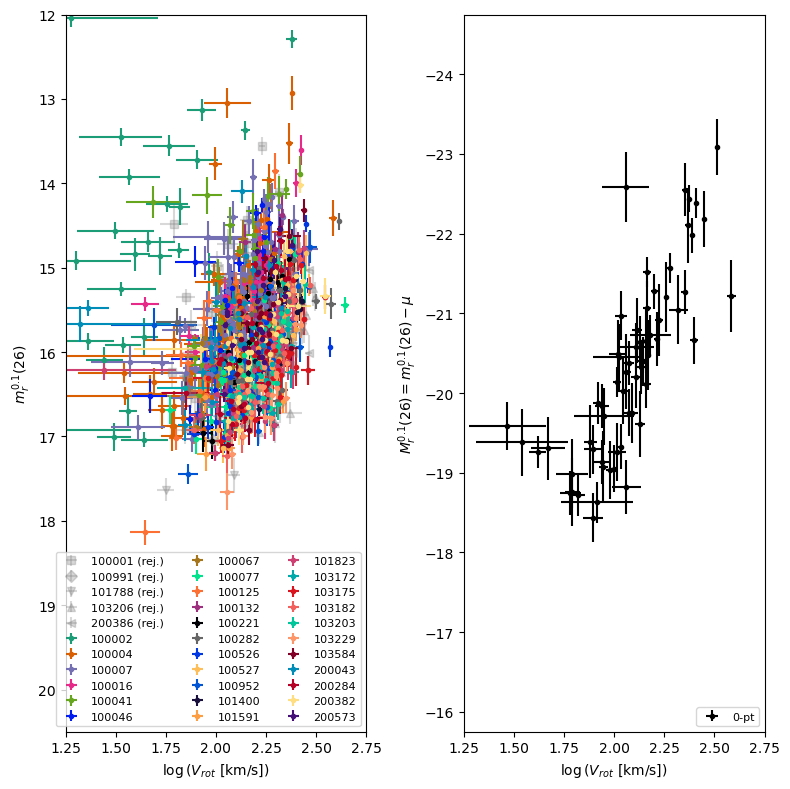

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(8,8), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
if rejtab is not None: 
    _cluster_ids = np.unique(rejtab['CLUSTER_ID'])
    markers = 'sDv^<>'
    for j, _cluster_id in enumerate(_cluster_ids):
        select_cluster = np.in1d(rejtab['CLUSTER_ID'], _cluster_id)
    
        #- Store independent variable for each cluster
        logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
        logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data
    
        #- Store dependent variable for each cluster
        mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
        mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
        
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[20.5, 12],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='lower right', fontsize=8, ncol = 3)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='k.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-15.75, -24.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='lower right', fontsize=8);

# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration_0pt.png', dpi=150);

# Apply the Joint TFR Fit

In [49]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.in1d(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])

logV0 = 2.1799597594012576


## Multiline Fit using HyperFit

In [50]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -74557.88217753888
     jac: array([ 0.23283065,  0.12514646,  0.12514646, -0.2881279 , -0.03783498,
       -0.04074536,  0.09895302,  0.02910383,  0.00582077,  0.12805684,
        0.0669388 ,  0.05820766,  0.        ,  0.20663718, -0.17462297,
       -0.01455191,  0.00582077, -0.02910383, -0.0844011 , -0.04947651,
       -0.02328306, -0.26484484,  0.        , -0.03492459, -0.06984919,
       -0.08585629,  0.03783498, -0.09458744,  0.04802132,  0.01600711,
       -0.06257324])
 message: 'Optimization terminated successfully.'
    nfev: 157185
     nit: 336
 success: True
       x: array([ -6.69948747, -20.89318831,  11.98072334,  14.68300826,
        15.00686277,  15.02670359,  14.60340648,  14.83290018,
        15.11532656,  16.17527516,  14.71198872,  15.60685681,
        15.92531233,  16.4246004 ,  16.17614656,  16.30202295,
        16.34517058,  16.57682438,  16.40089367,  16.49628435,
        16.50229924,  16.73642538,  16.47583998,  16.65167058,
        16.88258222,  16

100%|██████████| 1000/1000 [02:46<00:00,  6.02it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [87.0332483  94.37281944 88.28678638 89.88908694 92.19687842 92.96720167
 92.66006961 90.34220166 88.95031772 91.46828851 89.3305322  87.39646701
 87.37257911 89.80245954 92.07472884 90.36603153 88.75962339 89.66975997
 94.38566591 88.55912504 89.14405393 89.62933197 92.63524237 92.39083877
 85.79103437 84.60038385 85.04358224 90.79281593 93.90794955 94.42655103
 91.80749269] / 4721.327551594643


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [129.25682589 116.30593663 132.29754694 112.30479922 110.2636827
 119.0826579  128.35551162 126.16772517 122.03010983 113.58041582
 127.98791443 124.9512205  132.07655552 121.36124919 122.95085583
 121.43461682 115.00479525 127.59716234 124.73639759 121.63838284
 121.87946254 119.01957875 121.8949831  125.96183037 118.99588746
 124.70635855 119.57710951 128.14210404 123.98085709 118.92316274
 131.00064095] / 6614.877347211453


100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.68558734 141.26411053 148.95774152 142.25561011 139.34055064
 138.96618735 154.78558791 146.2364965  156.26415338 146.77607558
 143.55880354 149.04271028 136.80074834 140.4570063  140.06998482
 148.89479255 149.14981674 148.36786396 156.87863378 151.49146015
 147.13475318 145.05981294 152.09056815 146.24557061 150.82999348
 145.80210409 148.79658837 142.99430911 145.78675881 142.19143097
 146.97273974] / 8084.27936701442


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [175.42097373 152.89014829 176.28550026 149.49332997 151.19026167
 162.27603947 171.00465717 175.16685804 162.50540122 147.63154804
 154.53294603 164.16537336 173.18020322 159.71294206 153.18782598
 165.4634519  160.04632153 168.68610786 161.75453579 157.93628529
 156.19614921 158.35246144 155.13137763 160.93875592 161.52450197
 161.18789889 146.65140795 171.04177353 164.4536181  161.90655189
 171.8873077 ] / 8814.275012935372


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [174.44809528 168.95669476 177.27913308 184.19650871 160.73308286
 167.740437   204.58766339 191.94309562 185.72125427 183.48264459
 173.32725075 176.37917925 191.6748664  182.68457499 177.70819484
 194.97219039 184.89535024 198.53337927 174.50001187 167.61622892
 171.54545244 170.67733749 183.58805457 189.6921298  193.59127688
 171.52570928 170.17589701 182.78622431 175.82559734 176.58515083
 175.68088179] / 10229.38316940051


100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [192.32189602 176.59355494 187.47840823 188.73787314 163.32266464
 199.35934375 199.95869418 201.49852134 188.08418201 203.44191942
 182.11046224 197.17313262 192.14730587 174.34696006 184.53219655
 194.3547872  191.48385851 204.20999784 180.56657704 197.08138208
 195.91353605 182.1582148  206.98393386 205.29440269 196.12057732
 193.48986652 176.28310837 183.16674101 177.96892314 200.96561643
 191.74135969] / 10349.196693131298


100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [206.09160182 195.36668365 214.29832884 212.37042788 171.15413092
 221.75619187 204.47987499 231.24772989 211.13443973 219.78689763
 205.09701581 209.75229148 220.09705738 185.79968778 211.79649337
 214.17535546 209.53723245 239.9279486  227.44116059 217.59753389
 222.16070569 203.93590165 217.2250697  218.86333155 213.66936527
 215.26751307 199.48075487 224.29613746 205.48182108 216.32863818
 212.31837041] / 11996.397429854256


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [225.73293161 212.72292613 211.39318825 212.89596643 203.68690848
 216.42396927 217.39908783 222.18909914 220.33834089 210.98493501
 221.98857648 217.33433815 231.77207789 199.30178227 224.3689539
 220.1170309  215.60370681 242.85076827 235.19571513 212.80827811
 229.45454565 215.4850706  240.14501754 226.67086581 221.05739572
 219.82897448 213.60002364 238.21305154 219.91669602 225.83783711
 217.11464493] / 12142.538413332657


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [227.62741499 229.9237966  230.30485959 228.10307807 222.97041673
 225.0883533  216.13635897 227.06738823 243.23554878 226.19388675
 234.78088065 245.77649937 244.71976747 225.07014588 249.74130896
 231.09297589 238.95254805 247.66586025 256.25155376 223.27505333
 254.41212157 211.46245827 246.55668256 235.14376053 243.97065008
 223.92888264 227.13772595 254.78816055 227.97873122 235.30764365
 232.49833409] / 12812.577688086432


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [223.63274413 245.22147792 235.21167141 241.38975886 221.25424686
 236.68960063 217.99925379 230.48578264 247.48412403 223.83432216
 232.52341979 245.95631815 240.96596442 212.97694344 249.25599528
 237.39591456 234.14260099 253.11641676 256.1133704  236.52130385
 257.6858531  216.99558786 237.84495177 240.54226477 242.0333418
 239.73920573 234.32623878 246.93127175 236.58785493 229.39418024
 237.91530226] / 12884.292654961302


100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [234.6257324  253.95190588 247.52715292 248.10926687 233.05333662
 248.95974563 230.53591094 248.68699661 261.54755924 236.39145985
 249.0982829  248.99149544 256.08888932 229.16852409 257.79148048
 256.59626482 249.73133713 252.48884074 262.8524166  239.92504721
 263.89656478 225.77210357 244.53626347 251.23964637 257.58332447
 262.68386889 240.60303307 251.49390704 251.57053902 237.21995859
 246.09830923] / 13194.828238969705


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [240.62535912 250.47087416 255.40274582 245.32544778 240.557187
 251.44339698 228.74915138 250.8579393  263.20418203 234.25625045
 243.75545974 244.39010056 260.21187248 221.08231067 262.21430022
 259.88502293 252.4150352  257.25297338 252.17524599 244.06381703
 265.14000232 225.87785124 243.0017013  264.19482187 256.71421096
 273.54947868 252.68670878 257.06693627 249.4909702  235.66255074
 249.59900592] / 13677.473934001127


100%|██████████| 1000/1000 [02:47<00:00,  5.99it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [248.94740724 245.53323346 261.84896201 256.17333585 249.66914105
 269.10012299 241.65073668 259.31996179 268.64819374 244.34537551
 261.12505224 246.81037327 269.93366102 238.36743082 262.58115678
 271.13101713 267.50816074 267.55757257 248.41474477 250.82791392
 284.76088784 233.69710306 251.15195824 269.66155516 257.83586693
 280.02030712 275.19816234 269.92369917 264.3721529  240.58896579
 259.19394383] / 14238.044392247239


100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [253.91120827 250.55805906 258.89033587 255.97102847 254.91537695
 280.80048199 242.53962999 265.5762582  268.04211107 257.58860573
 250.0828919  260.16527363 264.57477507 241.74787519 258.84102588
 274.54274341 264.2276116  269.70926716 260.93916529 251.2297864
 290.72742156 234.01207501 257.56261281 259.49776325 258.75269641
 270.42970786 289.98977774 281.79913496 268.49440038 250.71133444
 259.60937792] / 14536.371078002447


100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [264.38636998 250.10715065 267.86571092 262.13279931 252.14417318
 293.2849692  265.0134111  277.24363647 273.72760932 266.66131567
 264.46250651 275.95938527 284.96424993 253.74727169 265.93908284
 286.95764398 274.45745623 277.57116607 273.63755586 273.92894589
 294.31427601 252.98417175 270.7108776  261.17071119 270.99124947
 273.49910104 287.46406565 285.95980161 266.45435305 248.52648071
 262.94208731] / 14715.713800263762


100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [266.23953742 248.96121742 269.33814745 257.09196942 243.20480019
 294.6294823  267.07857003 282.58959899 280.51560955 258.71410489
 275.10878496 275.74678577 290.04219645 252.88205793 273.68396632
 287.3066554  272.97739899 274.72438786 276.36877537 266.38297407
 283.56209311 258.88012219 278.71503676 261.63274676 268.15862564
 266.75187164 288.49778598 281.53894827 268.31564771 258.12184507
 262.98063379] / 14731.474115042152


In [51]:
'''temp_outfile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()'''

temp_infile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'rb')
cov_tfr, tfr_mcmc_samples, logV0 = pickle.load(temp_infile)
temp_infile.close()

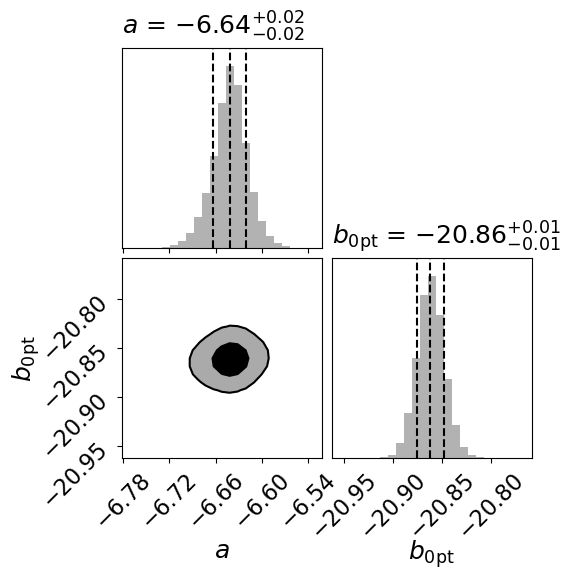

In [52]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples[0:2].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150,facecolor='none');

### Plot the HyperFit Results

In [53]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

-6.641044850284957


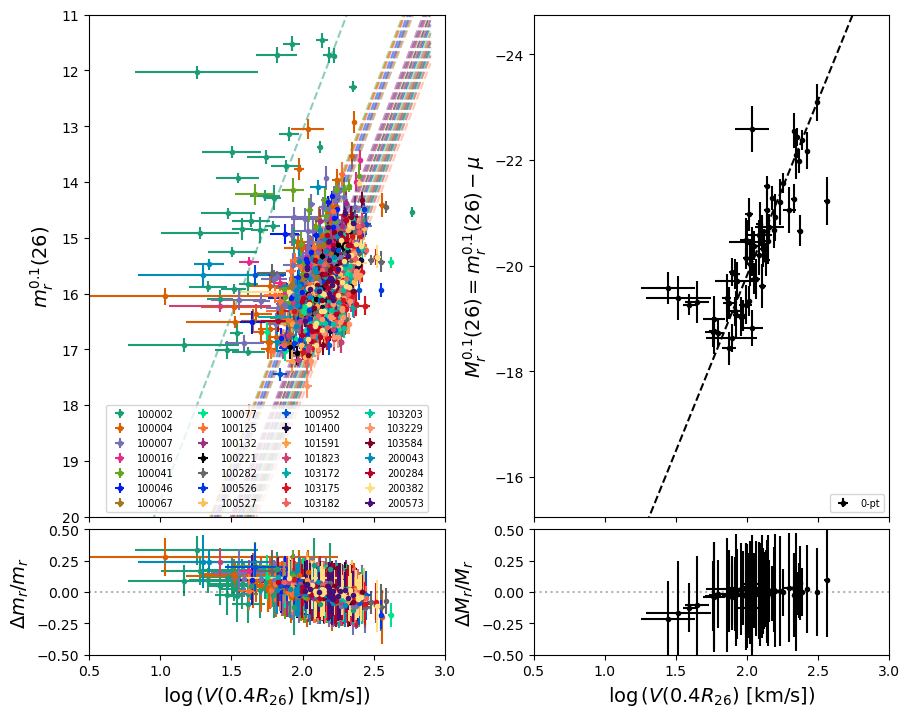

In [54]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[.5, 3],
       ylim=[20, 11]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower center', fontsize=7, ncol = 4);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[.5, 3],
       ylim=[-15.25, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=7)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='k.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150, facecolor='none')
print(a_)

33


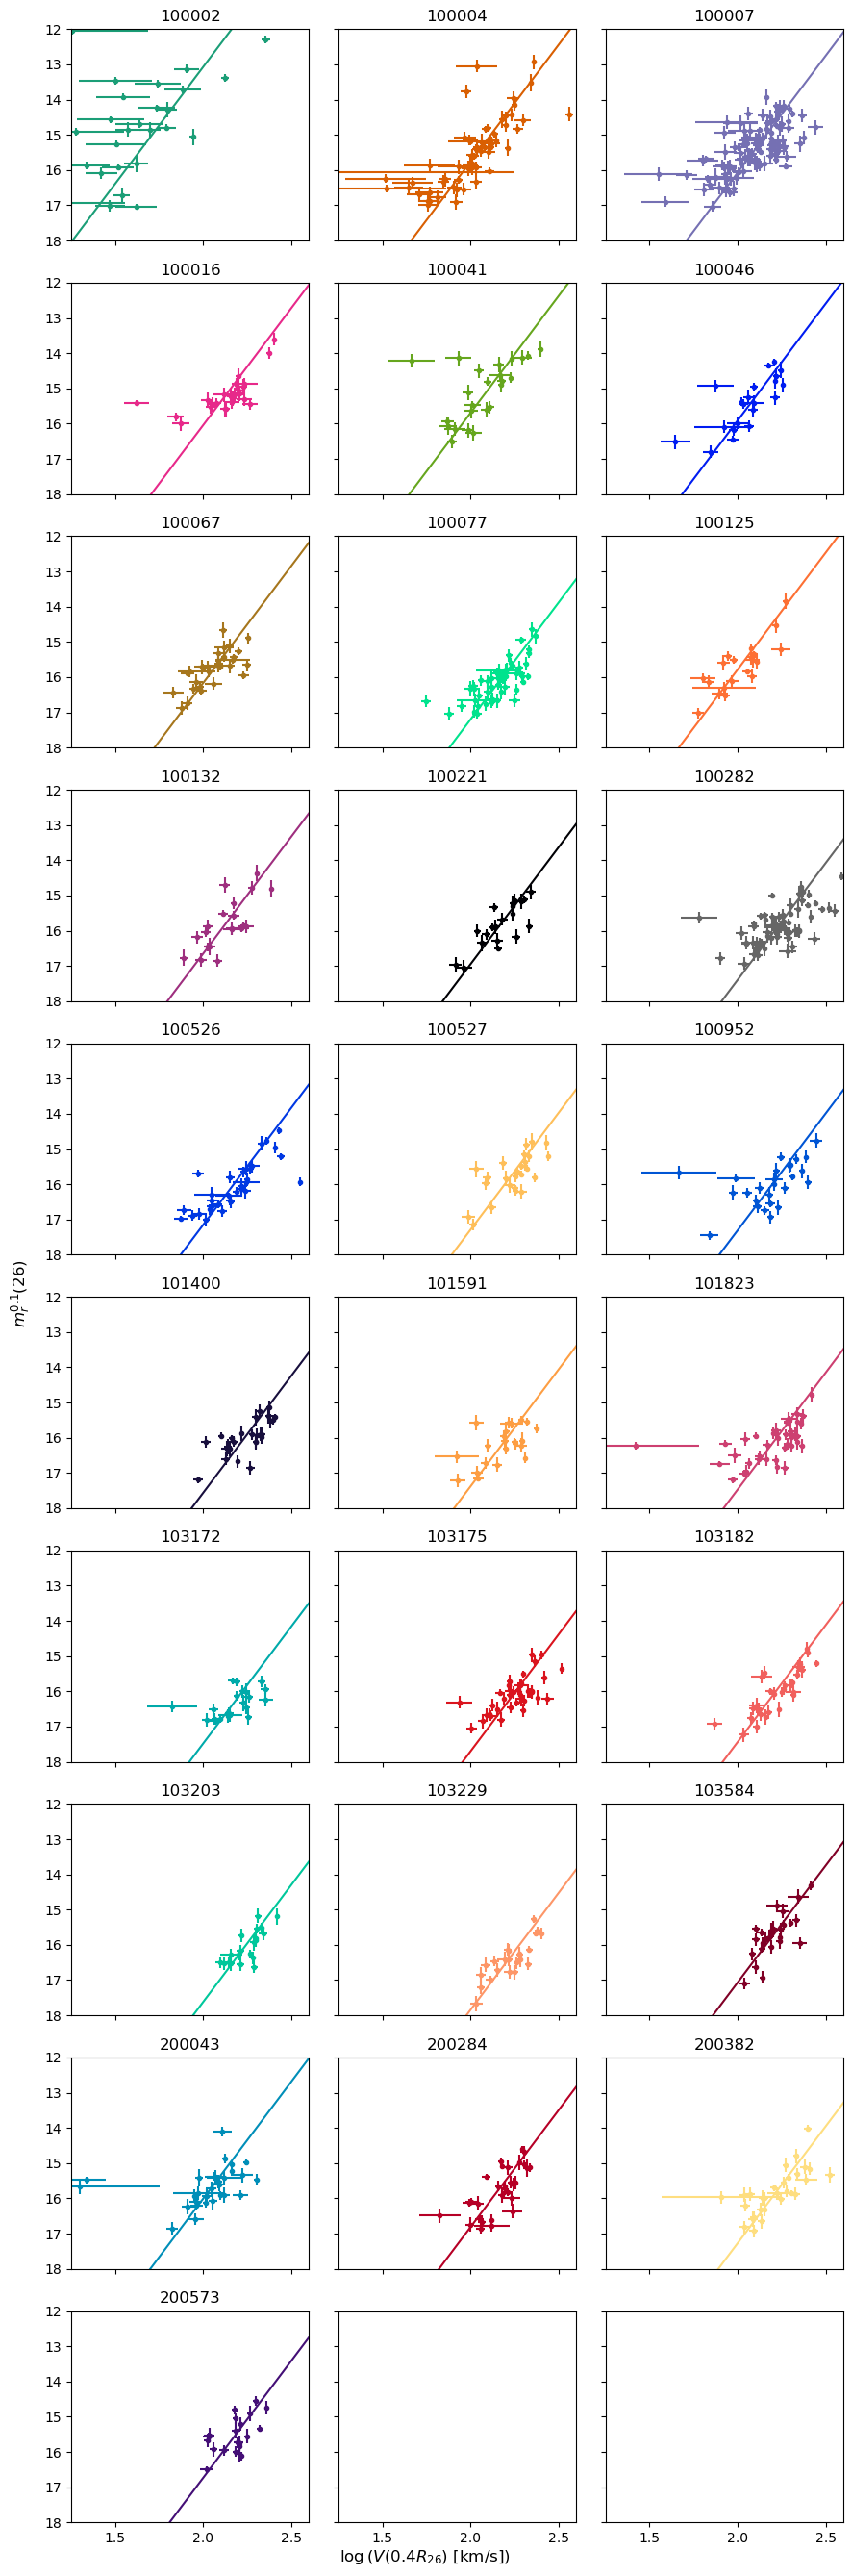

In [55]:
fig, axs = plt.subplots(nrows=10, ncols=3, sharex=True, sharey=True, figsize=(9,27), tight_layout=True)

print(len(tfcolor))
for i in range(len(_cluster_ids)):
    c = tfcolor[i]
    
    row = int(i/3)
    col = i%3
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 12], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [56]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

37.688281827498635 km/s


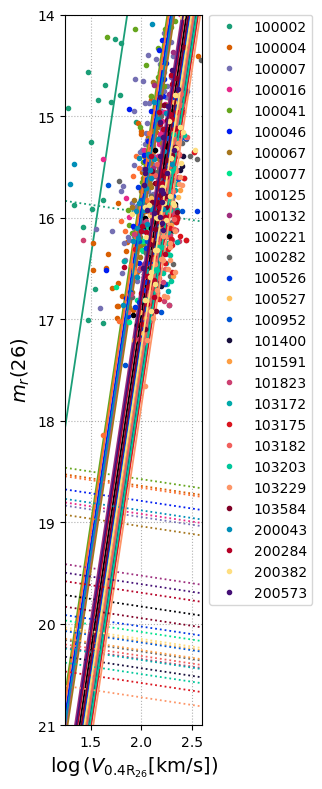

In [57]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 14)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [58]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
